In [88]:

""" 
21 MARCH 2024 
Theo Gauvrit
Testing if the responsivity pattern are different between WT and KO groups
"""

import percephone.core.recording as pc
import percephone.plts.behavior as pbh
import percephone.plts.stats as ppt
from percephone.analysis.utils import get_zscore
import percephone.analysis.mlr_models as mlr_m
import numpy as np
import pandas as pd
import scipy.stats as ss
from multiprocessing import Pool, cpu_count, pool
import os
import matplotlib
import matplotlib.pyplot as plt
import pingouin as pg
from statsmodels.formula.api import ols
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib as mpl
import copy


plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline
matplotlib.rc('pdf', fonttype=42)
save_figure = False

In [2]:
user = "Célien"

if user == "Célien":
    directory = "C:/Users/cvandromme/Desktop/Data/"
    roi_path = "C:/Users/cvandromme/Desktop/FmKO_ROIs&inhibitory.xlsx"
    server_address = "Z:/Current_members/Ourania_Semelidou/2p/Figures_paper/"
elif user == "Théo":
    directory = "/datas/Théo/Projects/Percephone/data/Amplitude_Detection/loop_format_tau_02/"
    roi_path = directory + "/FmKO_ROIs&inhibitory.xlsx"
    server_address = "/run/user/1004/gvfs/smb-share:server=engram.local,share=data/Current_members/Ourania_Semelidou/2p/Figures_paper/"
elif user == "Adrien":
    directory = "C:/Users/acorniere/Desktop/percephone_data/"
    roi_path = directory + "FmKO_ROIs&inhibitory.xlsx"

roi_info = pd.read_excel(roi_path)
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

def opening_rec(fil, i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, roi_path)
    return rec

workers = cpu_count()
if user == "Célien":
    pool = pool.ThreadPool(processes=workers)
elif user == "Théo":
   pool = Pool(processes=workers)
elif user == "Adrien":
    pool = pool.ThreadPool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file, i)) for i, file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorpor

In [3]:
def fraction_resp(pattern, n_type, ko_hypo_only=True, stim_ampl="all", no_go_normalize=True):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[n_type]["Responsivity"])
        no_go_filter = rec.stim_ampl_filter(stim_ampl=[0], include_no_go=True)
        ampl_filter = rec.stim_ampl_filter(stim_ampl=stim_ampl, include_no_go=False)
        ampl_det_filt = np.logical_and(rec.detected_stim, ampl_filter)
        ampl_undet_filt = np.logical_and(np.invert(rec.detected_stim), ampl_filter)
        #detected
        trials_no_go = resp_mat[:, no_go_filter]
        trials_detected = resp_mat[:, ampl_det_filt]
        trials_undetected = resp_mat[:, ampl_undet_filt]
        if pattern == 0:
            trials_detected[trials_detected!=0]=1
            trials_undetected[trials_undetected!=0]=1
            trials_no_go[trials_no_go!=0]=1
        else:
            trials_detected[trials_detected!=pattern]=0
            trials_undetected[trials_undetected!=pattern]=0
            trials_no_go[trials_no_go!=pattern]=0
        
        # The total number of neurons is computed
        total_n = rec.zscore_exc.shape[0] if n_type == "EXC" else rec.zscore_inh.shape[0]
        
        # Computation of the number of responsive neurons
        recruited_det = np.mean(np.count_nonzero(trials_detected, axis=0))
        recruited_undet = np.mean(np.count_nonzero(trials_undetected, axis=0))
        
        # Normalization by the number of responsive neurons for no-go trials
        if no_go_normalize:
            recruited_no_go = np.mean(np.count_nonzero(trials_no_go, axis=0))
            recruited_det -= recruited_no_go
            recruited_undet -= recruited_no_go
            recruited_det = 0 if recruited_det < 0 else recruited_det
            recruited_undet = 0 if recruited_undet < 0 else recruited_undet
        
        # Computation of the percentage of responsive neurons
        perc_n_det = (recruited_det/total_n)*100
        perc_n_undet = (recruited_undet/total_n)*100
        
        # Storing the computed percentage in the corresponding list
        if rec.genotype == "WT":
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet)
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
        elif rec.genotype == "KO" and not ko_hypo_only:
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    return np.array(wt_det), np.array(ko_det), np.array(wt_undet), np.array(ko_undet)

In [4]:
def plot_neuron_frac_wt_ko(pattern, ko_hypo_only=True, stim_ampl="all", ylim=[], no_go_normalize=True):
    if ko_hypo_only:
        ko_type = "KO-Hypo"
        color_ko = ppt.hypo_color
        light_color_ko = ppt.hypo_light_color
    else:
        ko_type = "(KO + KO-Hypo)"
        color_ko = ppt.all_ko_color
        light_color_ko = ppt.all_ko_light_color
        
    fig, axs = plt.subplots(2, 2, figsize=(12,16))
    for y_index, n_type in enumerate(["EXC", "INH"]):
        wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=pattern, n_type=n_type, ko_hypo_only=ko_hypo_only, stim_ampl=stim_ampl, no_go_normalize=no_go_normalize)
        ppt.boxplot(axs[y_index, 0], wt_det, ko_det, paired=False, ylabel="Neurons(%)", title=f"{n_type} Detected", ylim=ylim, 
                    colors=[ppt.wt_color, color_ko], det_marker=True)
        ppt.boxplot(axs[y_index, 1], wt_undet, ko_undet, paired=False, ylabel="Neurons(%)", title=f"{n_type} Undetected", ylim=ylim, 
                    colors=[ppt.wt_light_color, light_color_ko], det_marker=False)

    t_pattern = "recruited (1 and -1)" if pattern == 0 else ("activated (1)" if pattern == 1 else "inhibited (-1)")
    fig.suptitle(f"Percentage of neurons {t_pattern} during hit and miss trials (amplitude: {stim_ampl}) - WT vs. {ko_type}", fontsize=5)
    fig.tight_layout()
    if save_figure:
        title = f"Figure2/responsivity/fr_n_{t_pattern}_{stim_ampl}.pdf"
        fig.savefig(server_address + title)

# Comparison WT vs Ko-Hypo

## Fraction of neurons recruited ( 1 and -1) 


Boxplot plotting.
--- Neurons(%): EXC Detected ---
ShapiroResult(statistic=0.8675615606970442, pvalue=0.11576014816490549)
ShapiroResult(statistic=0.8662066942207569, pvalue=0.17191087408670935)
LeveneResult(statistic=0.48439053610034766, pvalue=0.49783243368658014)
Equal variances :TtestResult(statistic=1.9045266439670436, pvalue=0.07759565599254195, df=14.0)
Boxplot plotting.
--- Neurons(%): EXC Undetected ---
ShapiroResult(statistic=0.7591293184930419, pvalue=0.006916611377836169)
ShapiroResult(statistic=0.7472262316727625, pvalue=0.011867720858440073)
MannwhitneyuResult(statistic=33.0, pvalue=0.9120137031513722)
Boxplot plotting.
--- Neurons(%): INH Detected ---
ShapiroResult(statistic=0.7267357653993893, pvalue=0.0029094091984534502)
ShapiroResult(statistic=0.872026131969681, pvalue=0.19333979110858923)
MannwhitneyuResult(statistic=39.0, pvalue=0.4573923689532906)
Boxplot plotting.
--- Neurons(%): INH Undetected ---
ShapiroResult(statistic=0.5866456718332844, pvalue=6.668875799480

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Boxplot plotting.
--- Neurons(%): EXC Detected ---
ShapiroResult(statistic=0.9105961499463247, pvalue=0.32006934205027693)
ShapiroResult(statistic=0.841394362422665, pvalue=0.10237243188270079)
LeveneResult(statistic=1.8223670944824637, pvalue=0.19845480614437733)
Equal variances :TtestResult(statistic=1.5488985252936296, pvalue=0.14371054429418334, df=14.0)
Boxplot plotting.
Boxplot plotting.
--- Neurons(%): INH Detected ---
ShapiroResult(statistic=0.7887140997699567, pvalue=0.015166991539900823)
ShapiroResult(statistic=0.9295495888609321, pvalue=0.5470753686173454)
MannwhitneyuResult(statistic=36.0, pvalue=0.6710876611842307)
Boxplot plotting.


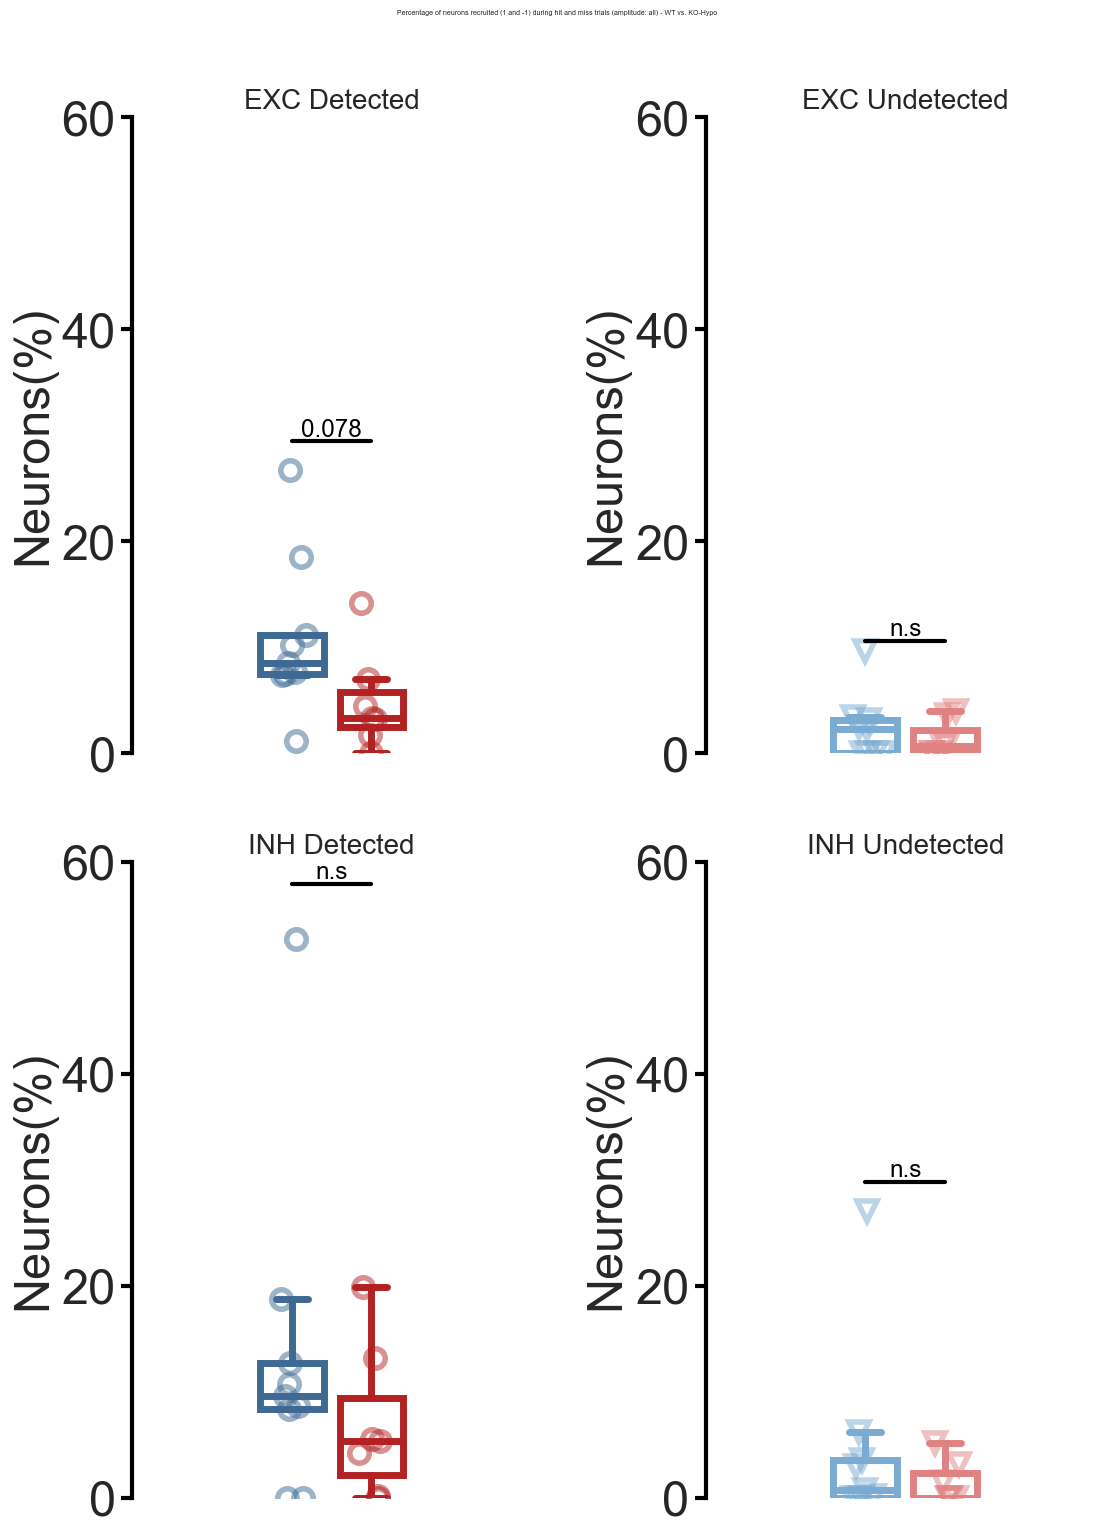

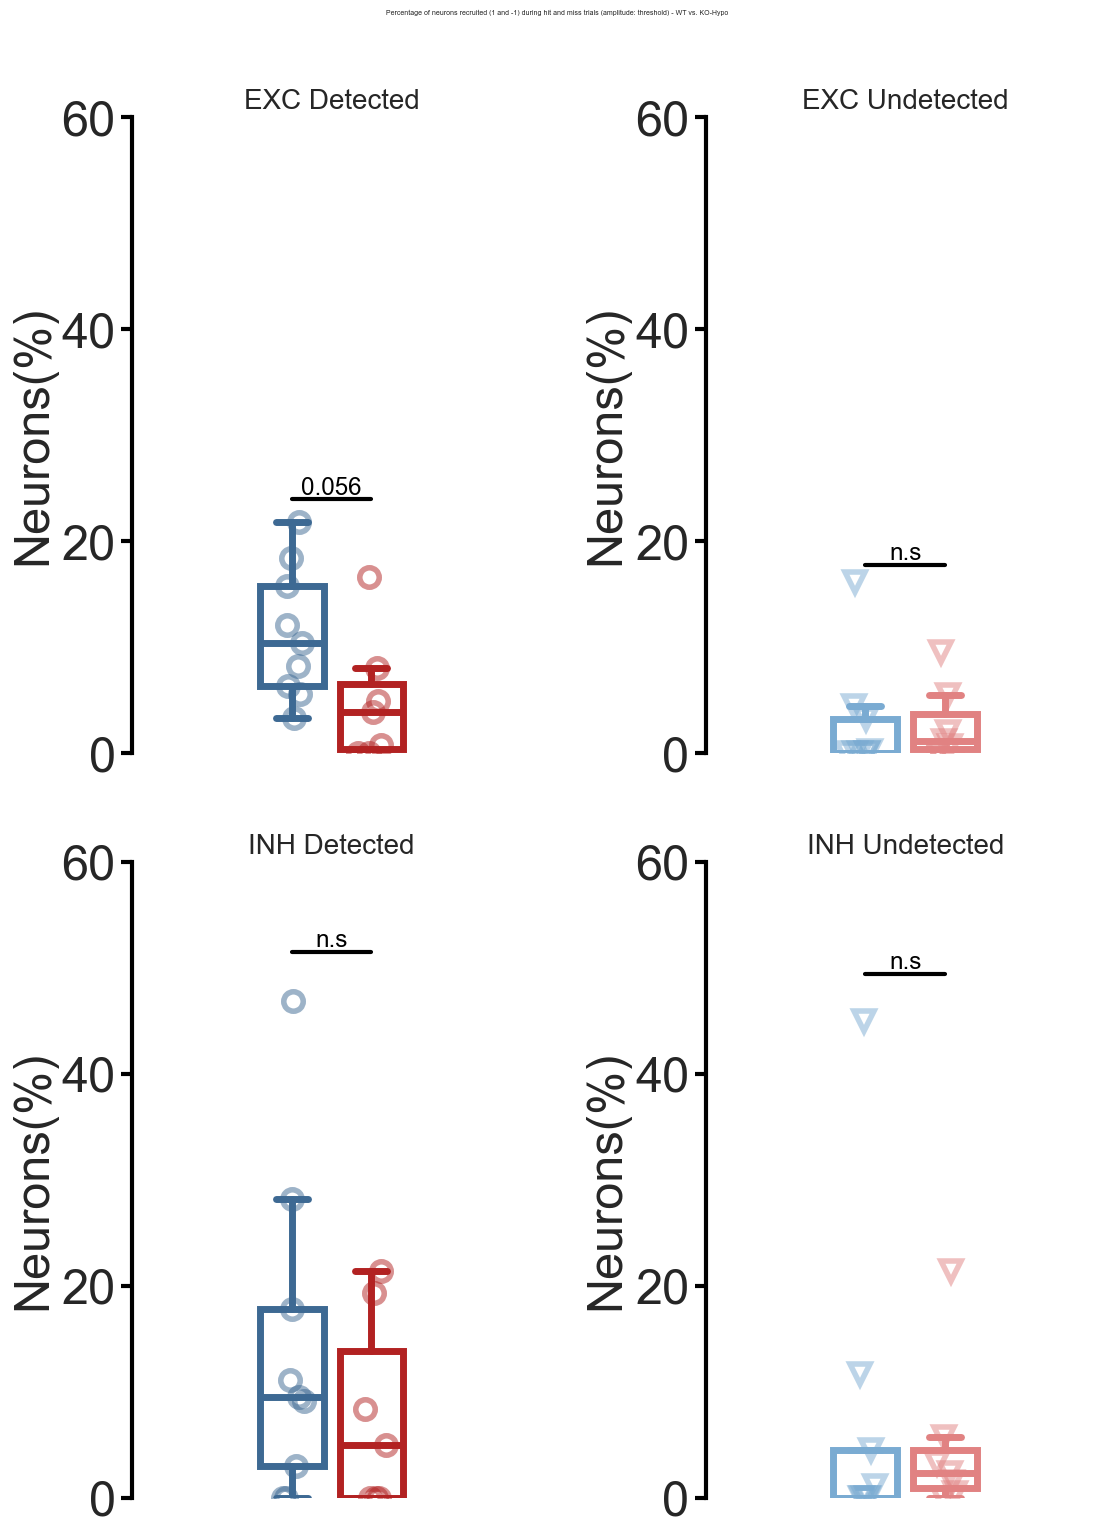

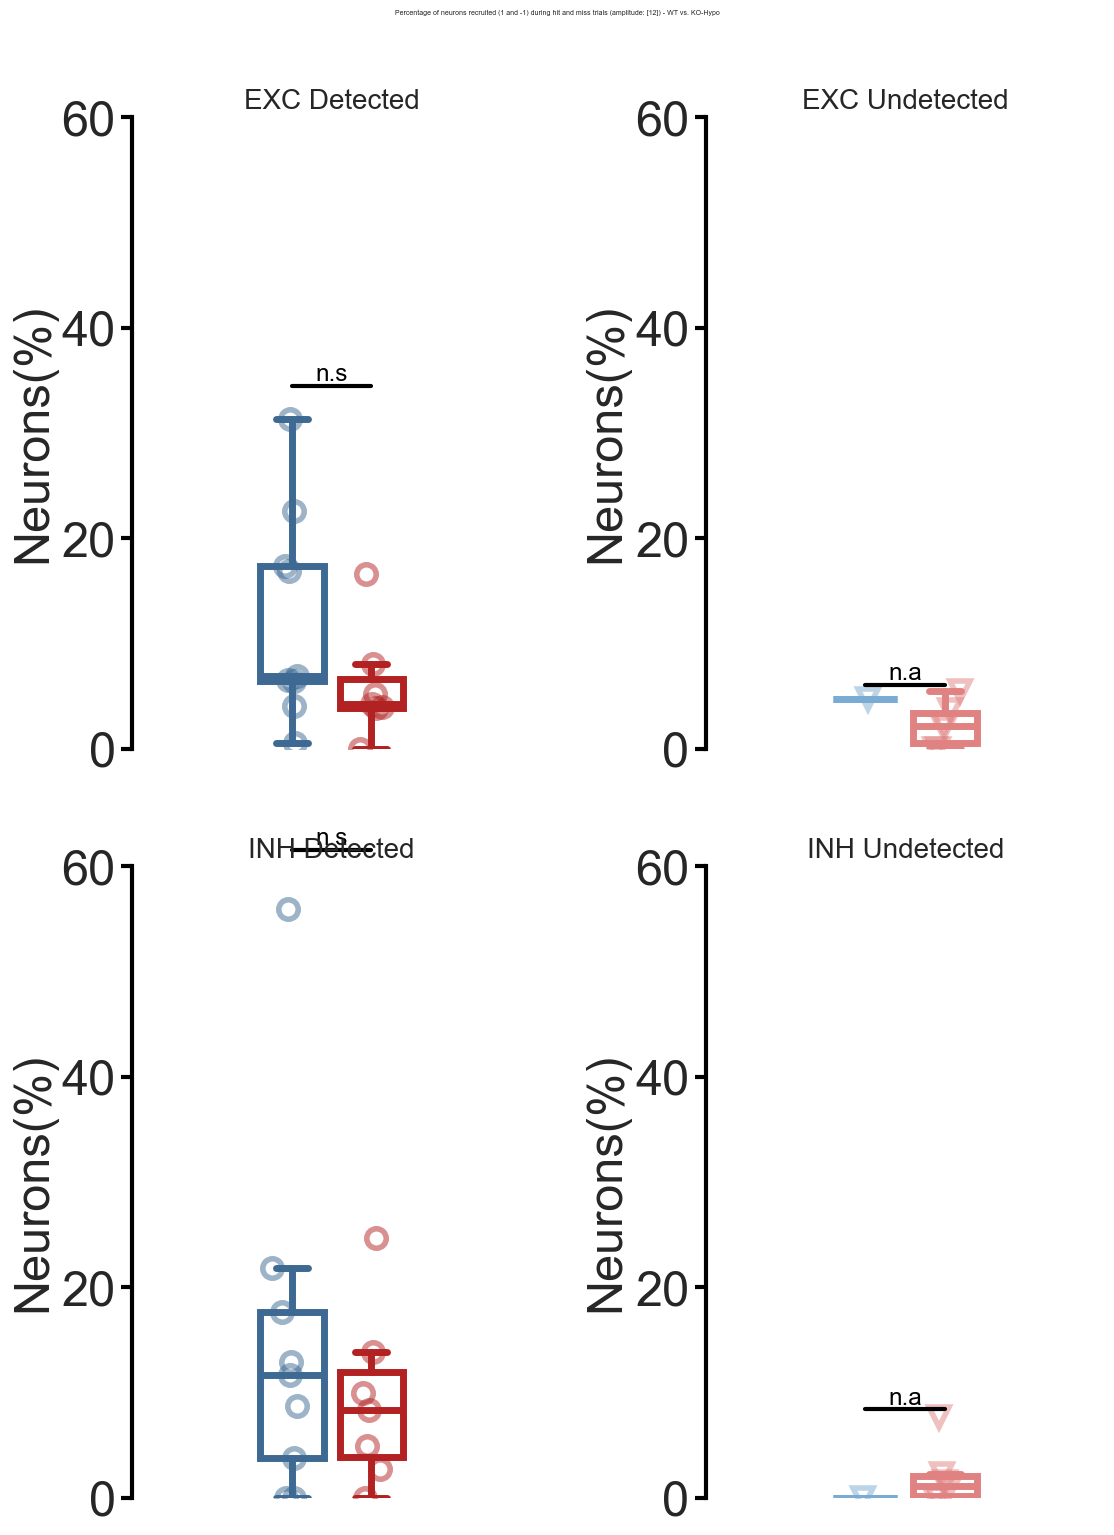

In [5]:
plot_neuron_frac_wt_ko(pattern=0, ko_hypo_only=True, stim_ampl="all", no_go_normalize=True, ylim=[0, 60])
plot_neuron_frac_wt_ko(pattern=0, ko_hypo_only=True, stim_ampl="threshold", no_go_normalize=True, ylim=[0, 60])
plot_neuron_frac_wt_ko(pattern=0, ko_hypo_only=True, stim_ampl=[12], no_go_normalize=True, ylim=[0, 60])

## Fraction of neurons activated (1) 

Boxplot plotting.
--- Neurons(%): EXC Detected ---
ShapiroResult(statistic=0.9836016023198251, pvalue=0.9802147108830375)
ShapiroResult(statistic=0.7355027702668262, pvalue=0.008930721412473343)
MannwhitneyuResult(statistic=48.0, pvalue=0.09073426573426574)
Boxplot plotting.
--- Neurons(%): EXC Undetected ---
ShapiroResult(statistic=0.87689508071603, pvalue=0.1456092842912433)
ShapiroResult(statistic=0.7588456843576243, pvalue=0.015682166842097823)
MannwhitneyuResult(statistic=39.0, pvalue=0.4553849754675213)
Boxplot plotting.
--- Neurons(%): INH Detected ---
ShapiroResult(statistic=0.8798206885102852, pvalue=0.15633951011524433)
ShapiroResult(statistic=0.9592661306954609, pvalue=0.8124141625501228)
LeveneResult(statistic=2.1646483786887867, pvalue=0.16333541214663347)
Equal variances :TtestResult(statistic=1.066644301500007, pvalue=0.3041819116705844, df=14.0)
Boxplot plotting.
--- Neurons(%): INH Undetected ---
ShapiroResult(statistic=0.897357972007691, pvalue=0.23708197857943808)
Sh

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


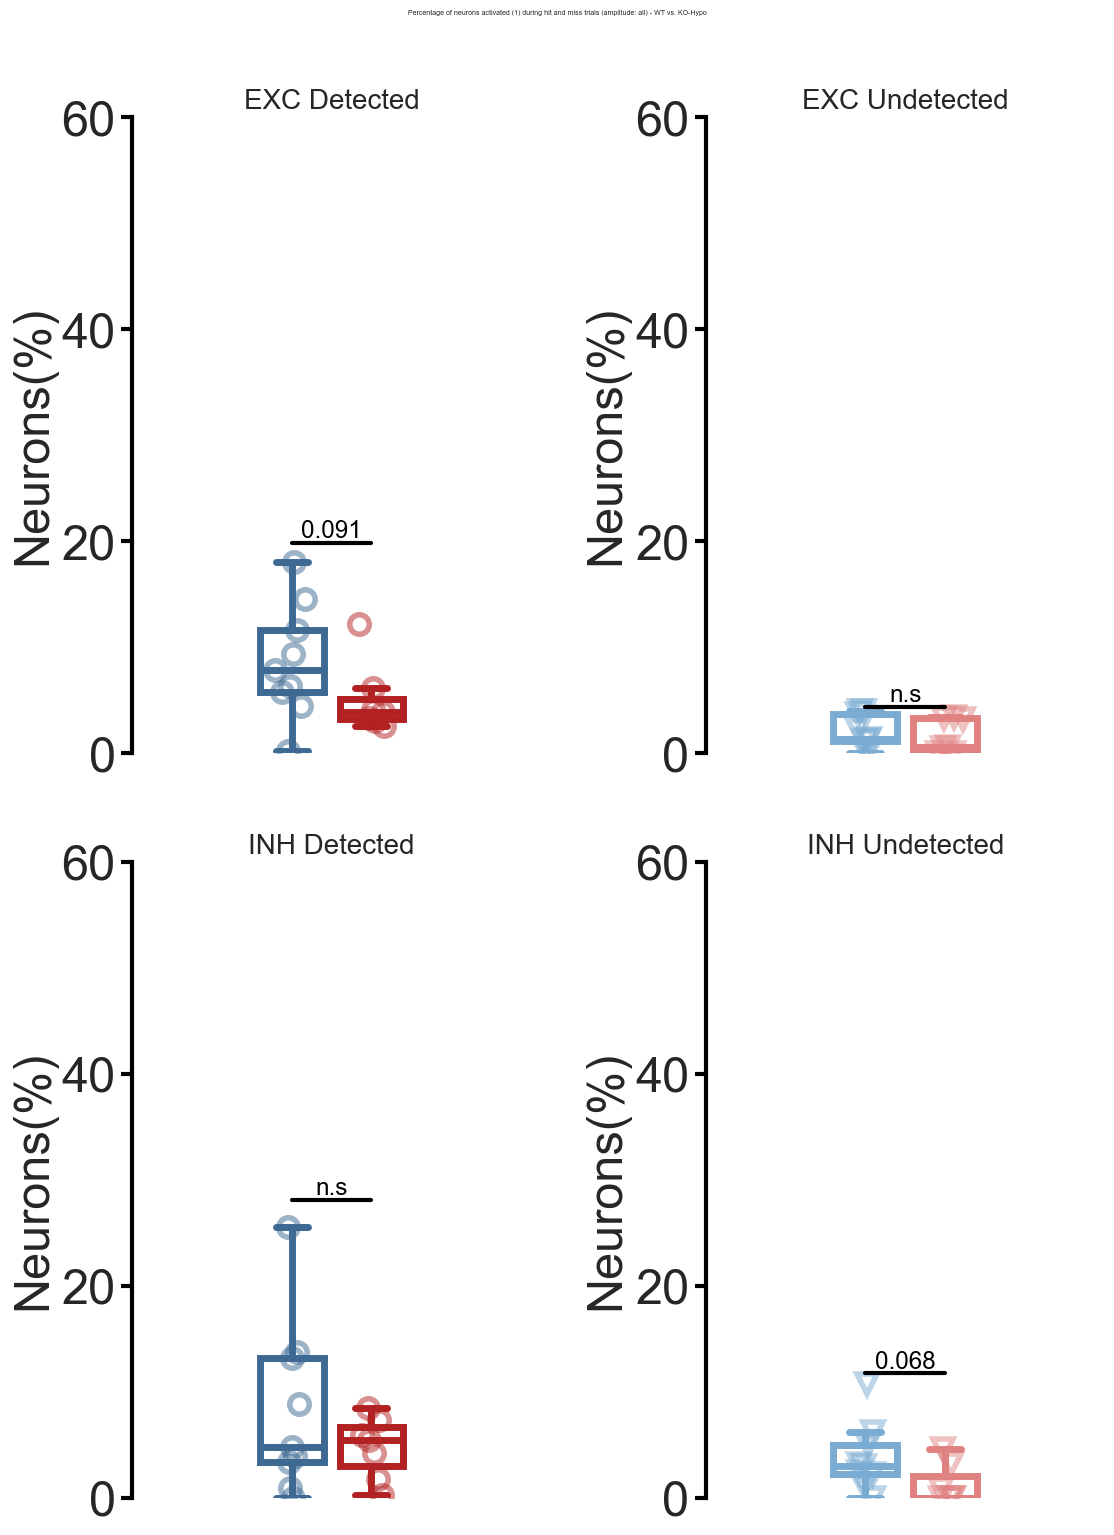

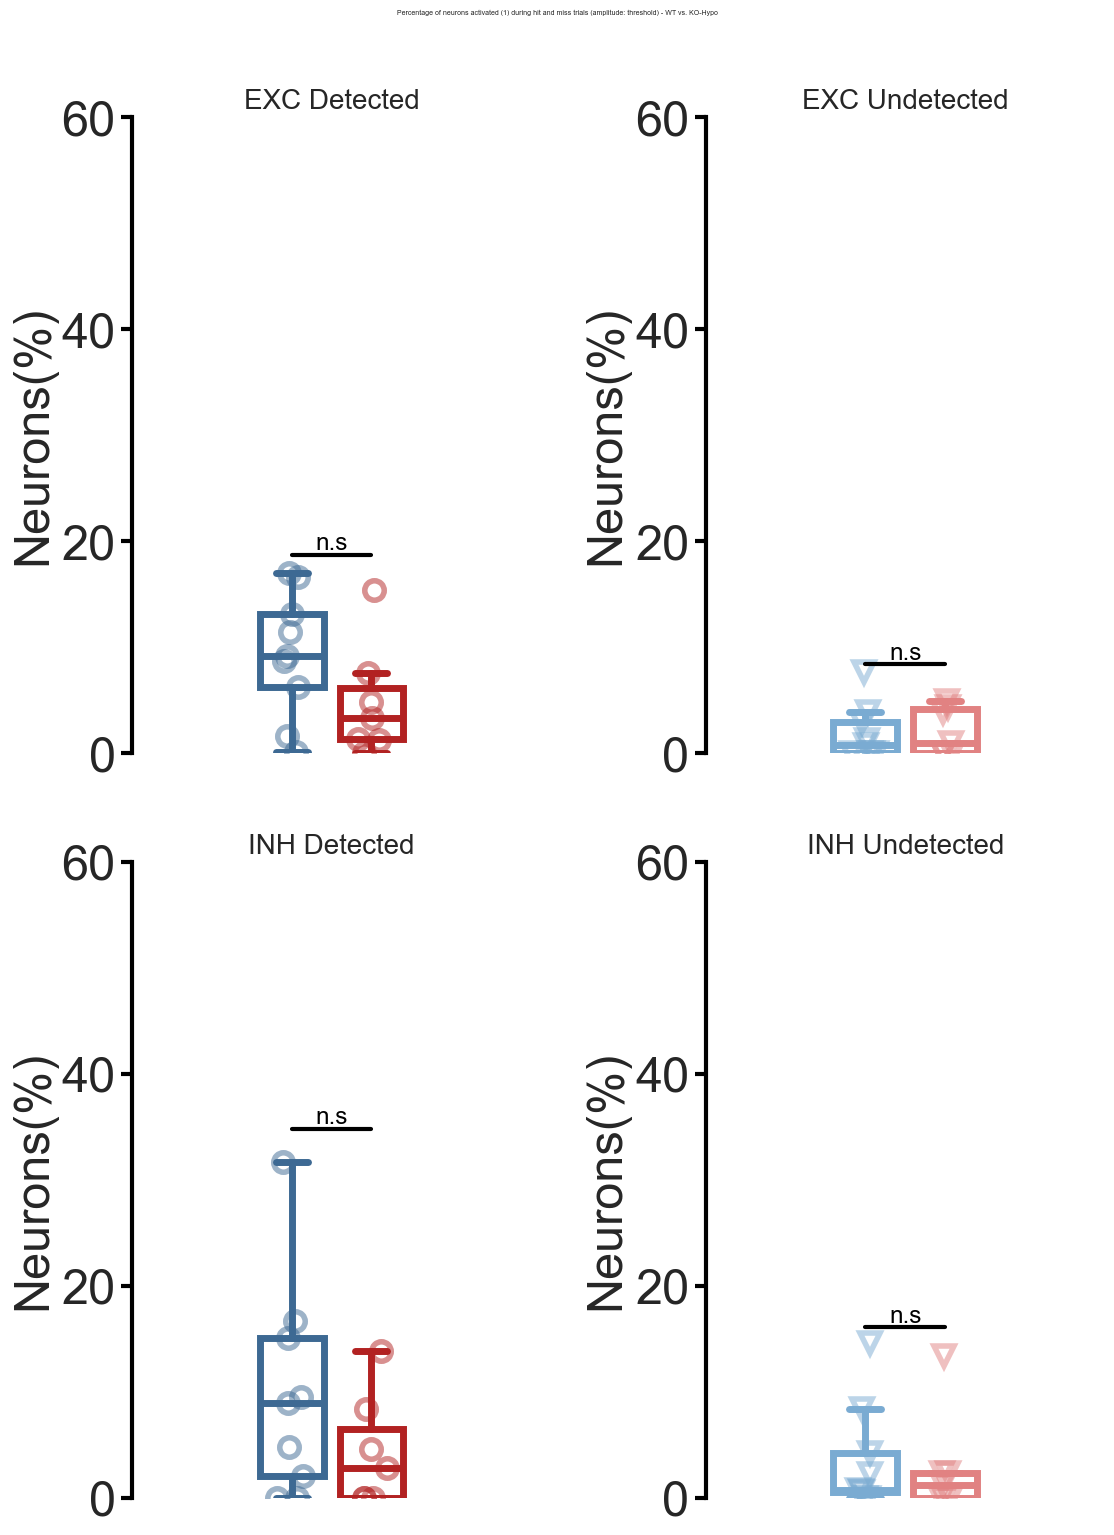

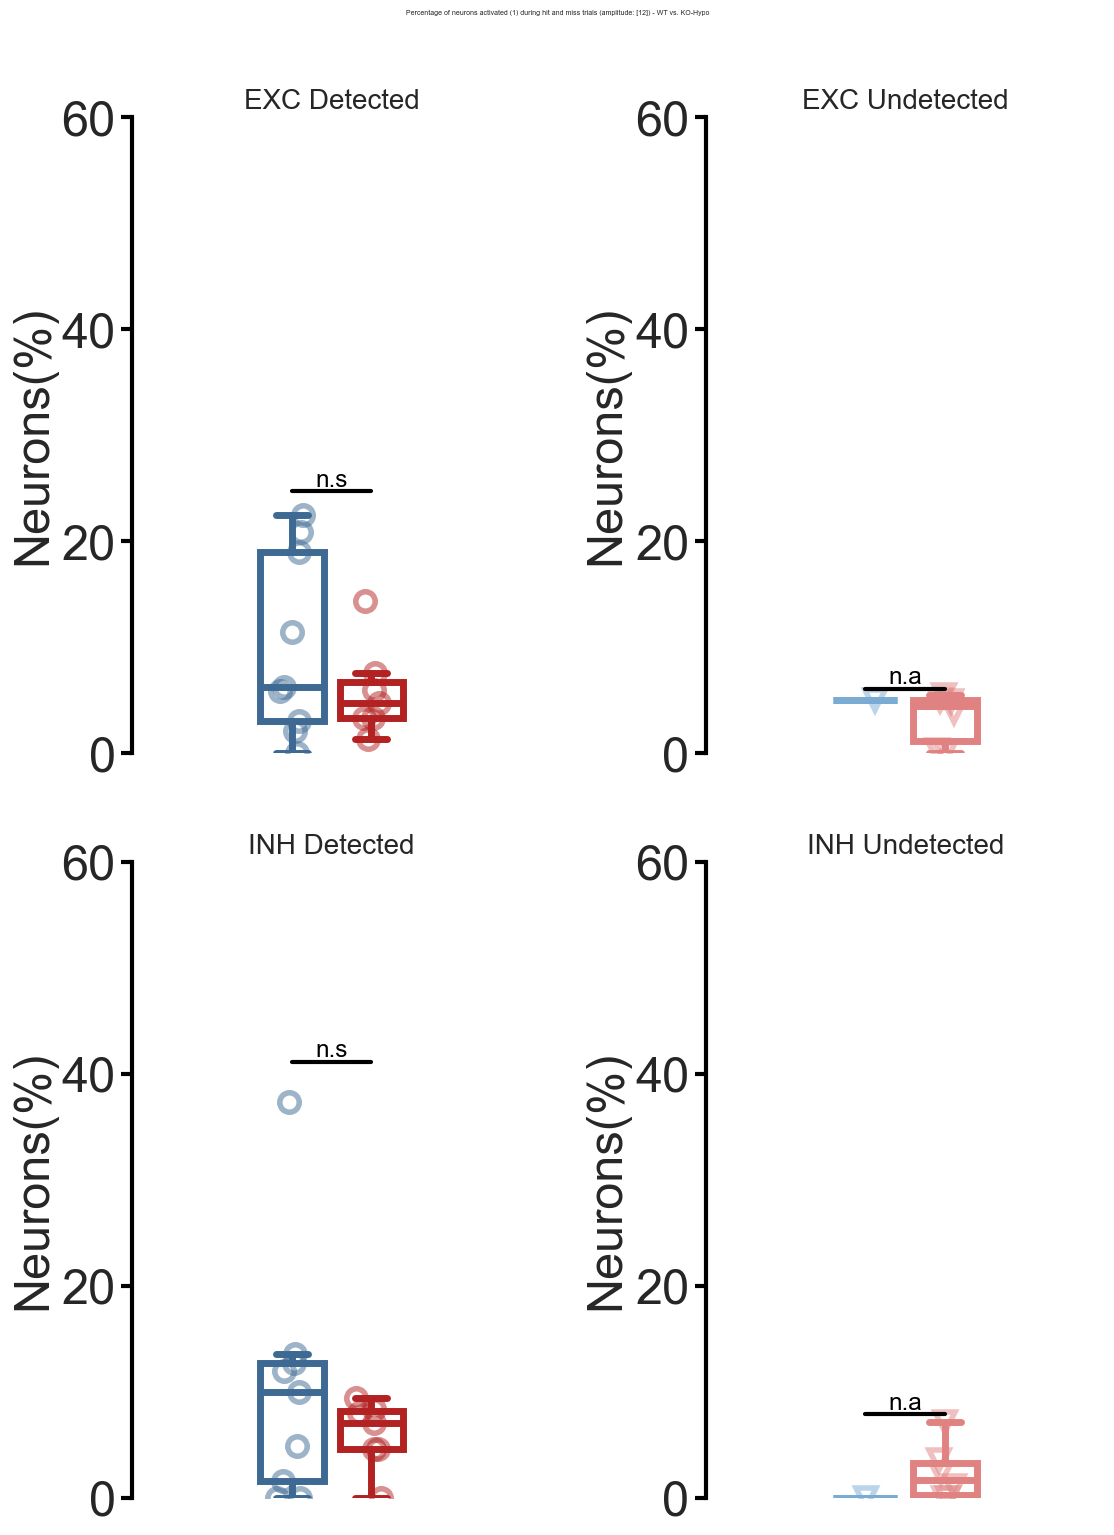

In [6]:
plot_neuron_frac_wt_ko(pattern=1, ko_hypo_only=True, no_go_normalize=True, stim_ampl="all", ylim=[0, 60])
plot_neuron_frac_wt_ko(pattern=1, ko_hypo_only=True, no_go_normalize=True, stim_ampl="threshold", ylim=[0, 60])
plot_neuron_frac_wt_ko(pattern=1, ko_hypo_only=True, no_go_normalize=True, stim_ampl=[12], ylim=[0, 60])

## Fraction of neurons inhibited (-1) 

Boxplot plotting.
--- Neurons(%): EXC Detected ---
ShapiroResult(statistic=0.5680232626348434, pvalue=4.0306150933334e-05)
ShapiroResult(statistic=0.7611266894331306, pvalue=0.016557895128488716)
MannwhitneyuResult(statistic=42.5, pvalue=0.2537888660005908)
Boxplot plotting.
--- Neurons(%): EXC Undetected ---
ShapiroResult(statistic=0.5359403861830357, pvalue=1.6919920176904313e-05)
ShapiroResult(statistic=0.7402178634073038, pvalue=0.01001637342513202)
MannwhitneyuResult(statistic=35.0, pvalue=0.7263934038022963)
Boxplot plotting.
--- Neurons(%): INH Detected ---
ShapiroResult(statistic=0.6111283963569594, pvalue=0.00012923819375612095)
ShapiroResult(statistic=0.613639430433425, pvalue=0.0003931102742140617)
MannwhitneyuResult(statistic=42.5, pvalue=0.23515669100197867)
Boxplot plotting.
--- Neurons(%): INH Undetected ---
ShapiroResult(statistic=0.4957647500755076, pvalue=5.700679396940689e-06)
ShapiroResult(statistic=0.6224927562751993, pvalue=0.0004980648490486538)
MannwhitneyuResul

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Boxplot plotting.
--- Neurons(%): EXC Detected ---
ShapiroResult(statistic=0.5398192768192194, pvalue=1.8792744704824024e-05)
ShapiroResult(statistic=0.8048303044314812, pvalue=0.04571326289367469)
MannwhitneyuResult(statistic=41.0, pvalue=0.33355025411190464)
Boxplot plotting.
Boxplot plotting.
--- Neurons(%): INH Detected ---
ShapiroResult(statistic=0.5946077073194642, pvalue=8.270256325928701e-05)
ShapiroResult(statistic=0.6320103570710638, pvalue=0.0006412808240022921)
MannwhitneyuResult(statistic=30.5, pvalue=0.9549177065523541)
Boxplot plotting.


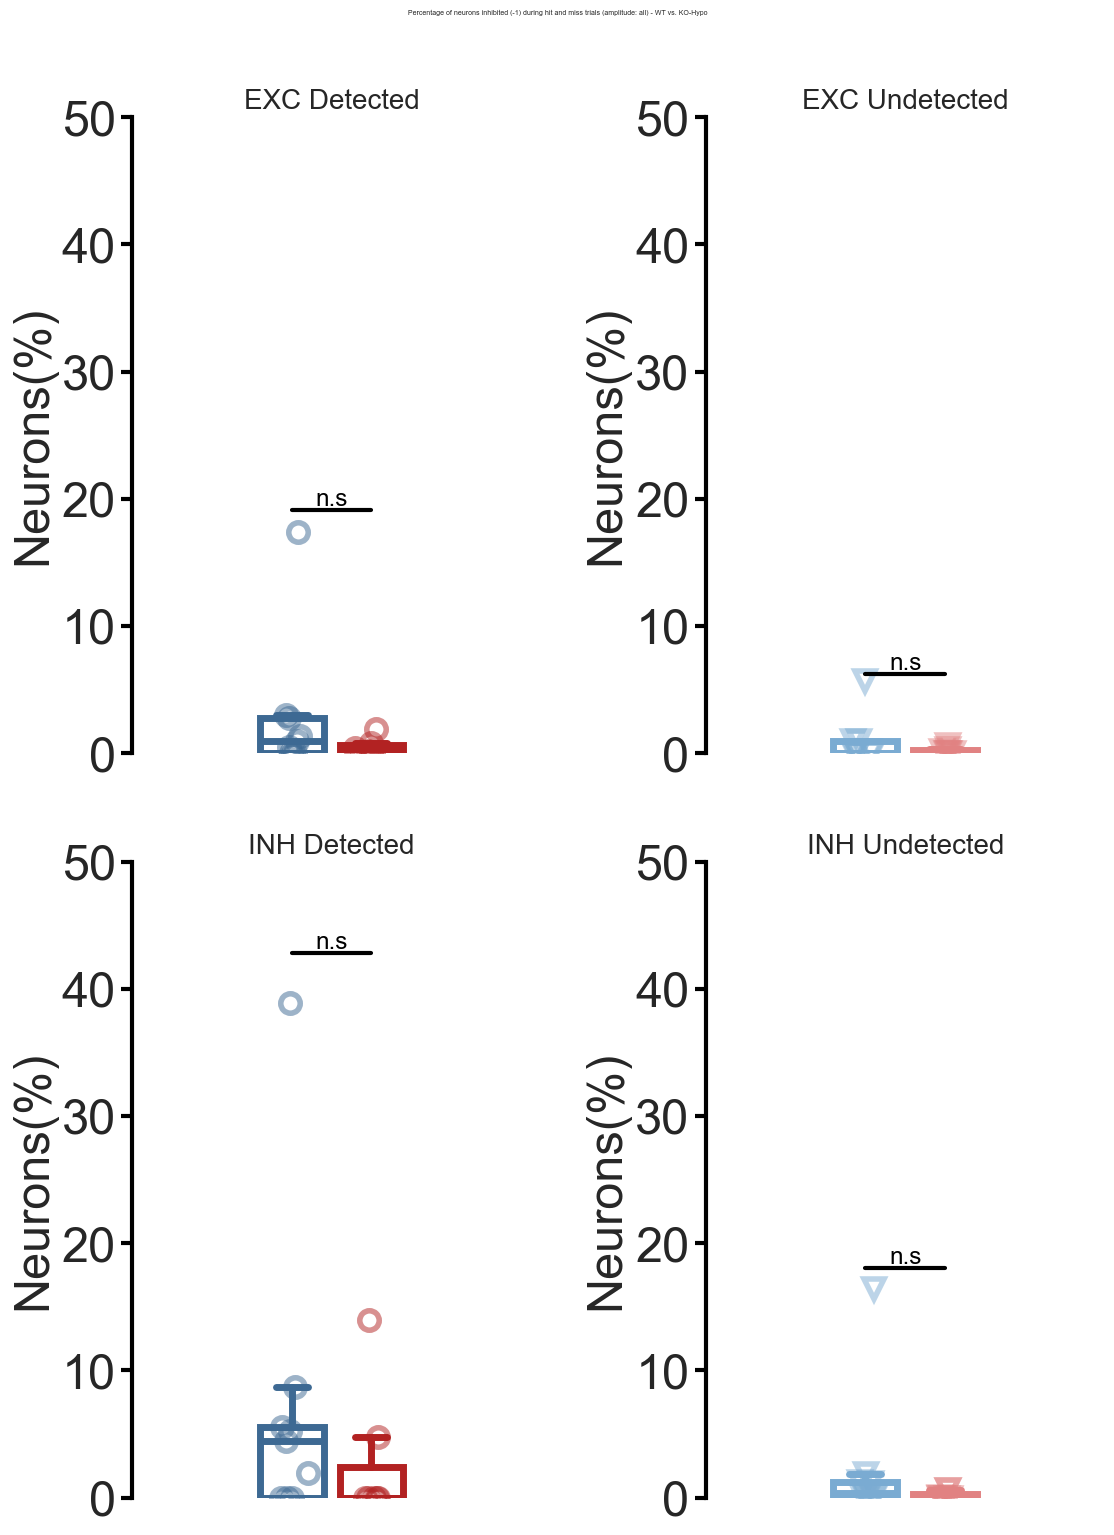

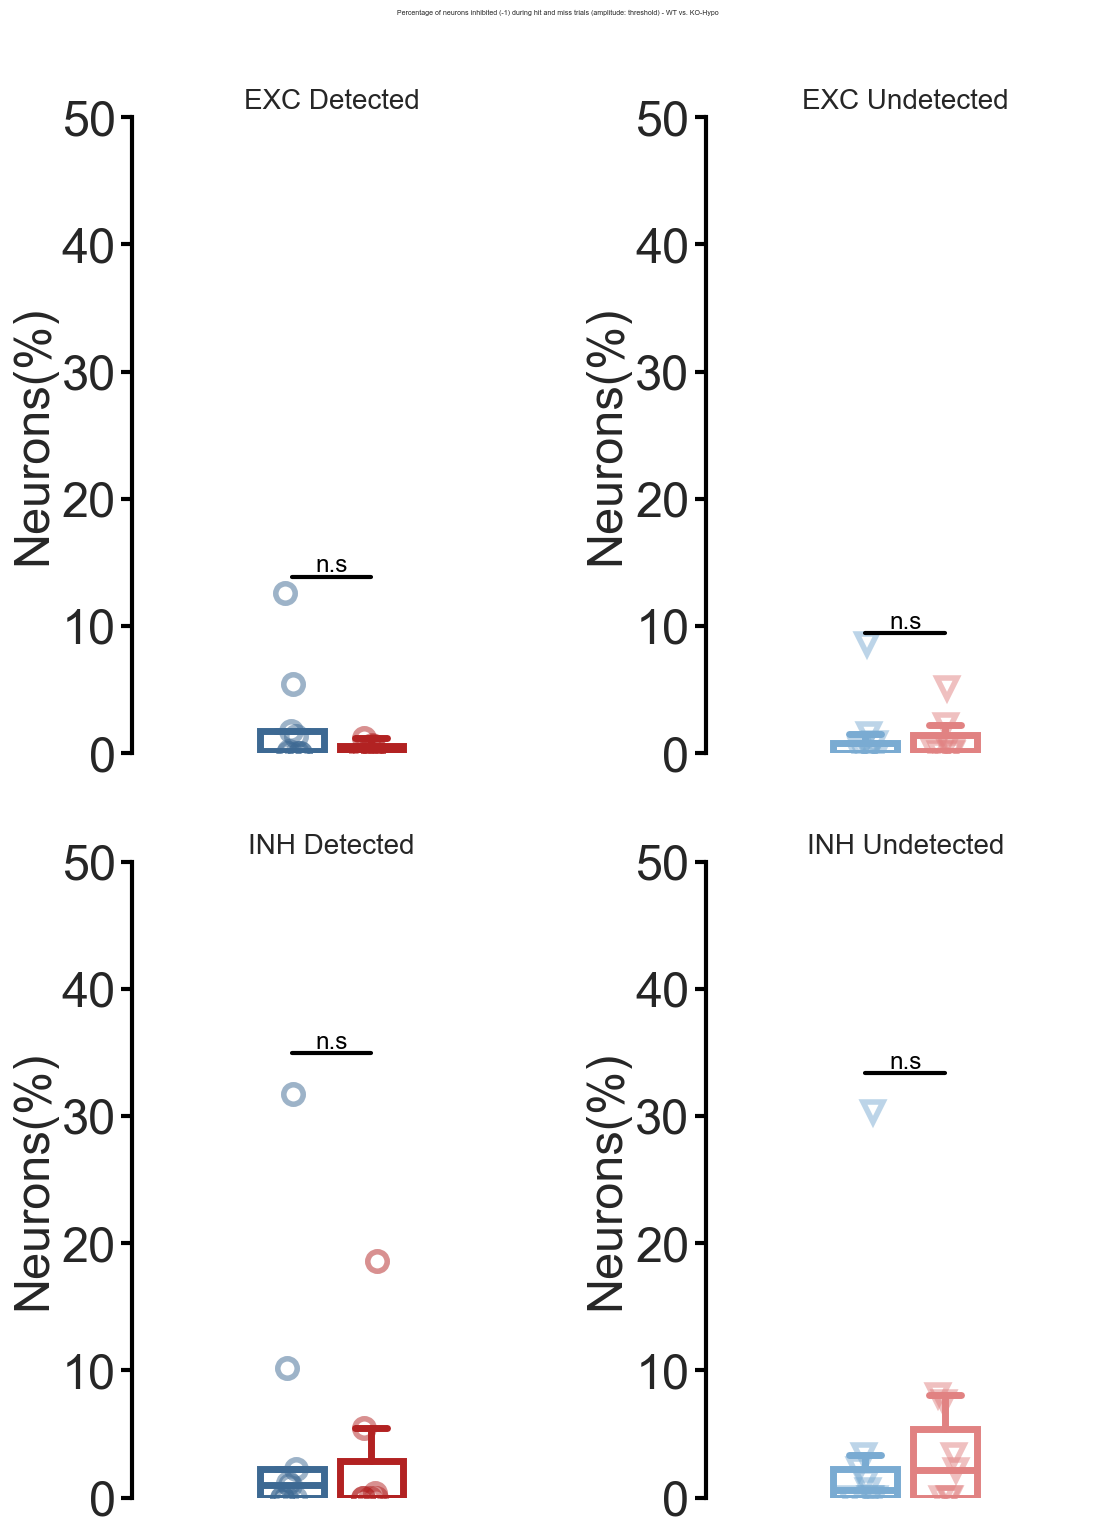

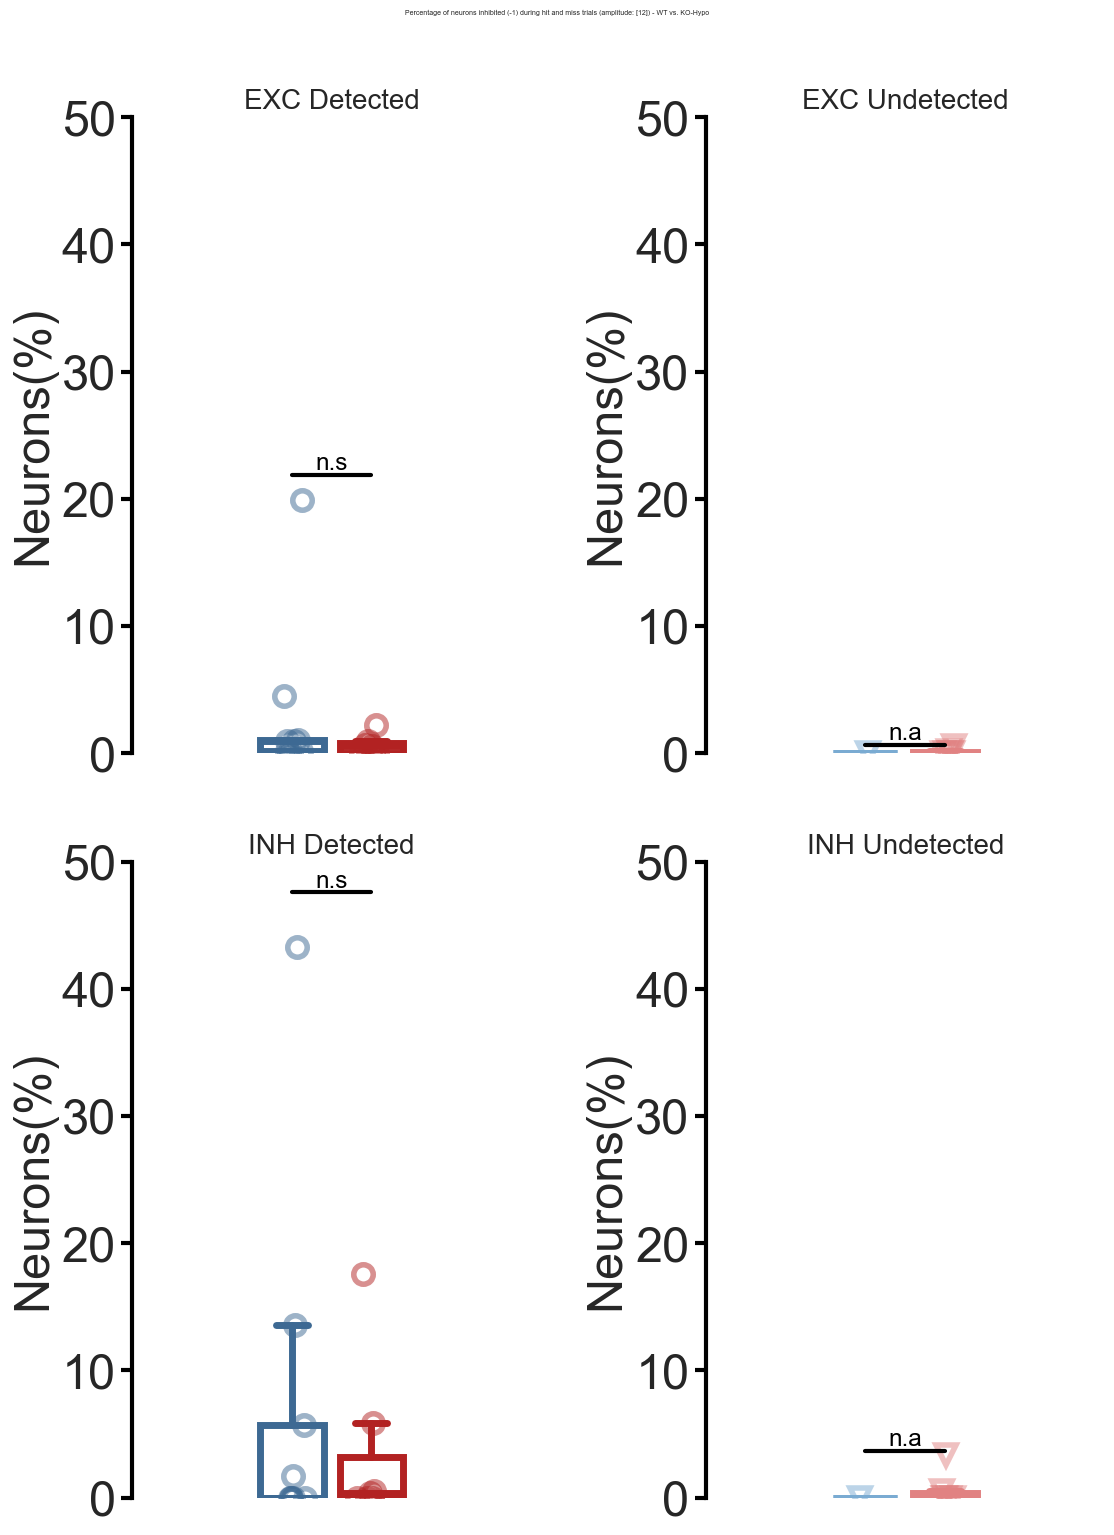

In [7]:
plot_neuron_frac_wt_ko(pattern=-1, ko_hypo_only=True, no_go_normalize=True, stim_ampl="all", ylim=[0, 50])
plot_neuron_frac_wt_ko(pattern=-1, ko_hypo_only=True, no_go_normalize=True, stim_ampl="threshold", ylim=[0, 50])
plot_neuron_frac_wt_ko(pattern=-1, ko_hypo_only=True, no_go_normalize=True, stim_ampl=[12], ylim=[0, 50])

# Comparison group det vs group undet


## Fraction of neurons recruited (1 and -1)

In [8]:
def plot_neuron_frac_det_undet(pattern, ko_hypo_only=True, stim_ampl="all", ylim=[], no_go_normalize=True):
    if ko_hypo_only:
        ko_type = "KO-Hypo"
        color_ko = ppt.hypo_color
        light_color_ko = ppt.hypo_light_color
    else:
        ko_type = "(KO + KO-Hypo)"
        color_ko = ppt.all_ko_color
        light_color_ko = ppt.all_ko_light_color
        
    fig, axs = plt.subplots(2, 2, figsize=(12,16))
    for y_index, n_type in enumerate(["EXC", "INH"]):
        wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=pattern, n_type=n_type, ko_hypo_only=ko_hypo_only, stim_ampl=stim_ampl, no_go_normalize=no_go_normalize)
        ppt.boxplot(axs[y_index, 0], wt_det, wt_undet, paired=True, ylabel="Neurons(%)", title=f"{n_type} - WT", ylim=ylim, 
                    colors=[ppt.wt_color, ppt.wt_light_color])
        ppt.boxplot(axs[y_index, 1], ko_det, ko_undet, paired=True, ylabel="Neurons(%)", title=f"{n_type} - {ko_type}", ylim=ylim, 
                    colors=[color_ko, light_color_ko])

    t_pattern = "recruited (1 and -1)" if pattern == 0 else ("activated (1)" if pattern == 1 else "inhibited (-1)")
    fig.suptitle(f"Comparison of neurons {t_pattern} between hit and miss trials (amplitude: {stim_ampl}) - WT & {ko_type}", fontsize=5)
    fig.tight_layout()
    if save_figure:
        title = f"Figure2/responsivity/paired_fr_n_{t_pattern}_{stim_ampl}.pdf"
        fig.savefig(server_address + title)

Boxplot plotting.
--- Neurons(%): EXC - WT ---
ShapiroResult(statistic=0.8675615606970442, pvalue=0.11576014816490549)
ShapiroResult(statistic=0.7591293184930419, pvalue=0.006916611377836169)
WilcoxonResult(statistic=0.0, pvalue=0.00390625)
Boxplot plotting.
--- Neurons(%): EXC - KO-Hypo ---
ShapiroResult(statistic=0.8662066942207569, pvalue=0.17191087408670935)
ShapiroResult(statistic=0.7472262316727625, pvalue=0.011867720858440073)
WilcoxonResult(statistic=1.0, pvalue=0.03125)
Boxplot plotting.
--- Neurons(%): INH - WT ---
ShapiroResult(statistic=0.7267357653993893, pvalue=0.0029094091984534502)
ShapiroResult(statistic=0.5866456718332844, pvalue=6.668875799480987e-05)
WilcoxonResult(statistic=1.0, pvalue=0.017290280592906253)
Boxplot plotting.
--- Neurons(%): INH - KO-Hypo ---
ShapiroResult(statistic=0.872026131969681, pvalue=0.19333979110858923)
ShapiroResult(statistic=0.7629009697882614, pvalue=0.017271267407980552)
WilcoxonResult(statistic=0.0, pvalue=0.027707849358079864)
Boxplot

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\

Boxplot plotting.
Boxplot plotting.
--- Neurons(%): EXC - KO-Hypo ---
ShapiroResult(statistic=0.859066591102016, pvalue=0.1859867500314304)
ShapiroResult(statistic=0.9282458707850685, pvalue=0.5666253371466489)
TtestResult(statistic=1.908484007532986, pvalue=0.11460892760947392, df=5)
Boxplot plotting.
Boxplot plotting.
--- Neurons(%): INH - KO-Hypo ---
ShapiroResult(statistic=0.9569810884504389, pvalue=0.7961982701803101)
ShapiroResult(statistic=0.7533080461521149, pvalue=0.02145798564108874)
WilcoxonResult(statistic=1.0, pvalue=0.0625)


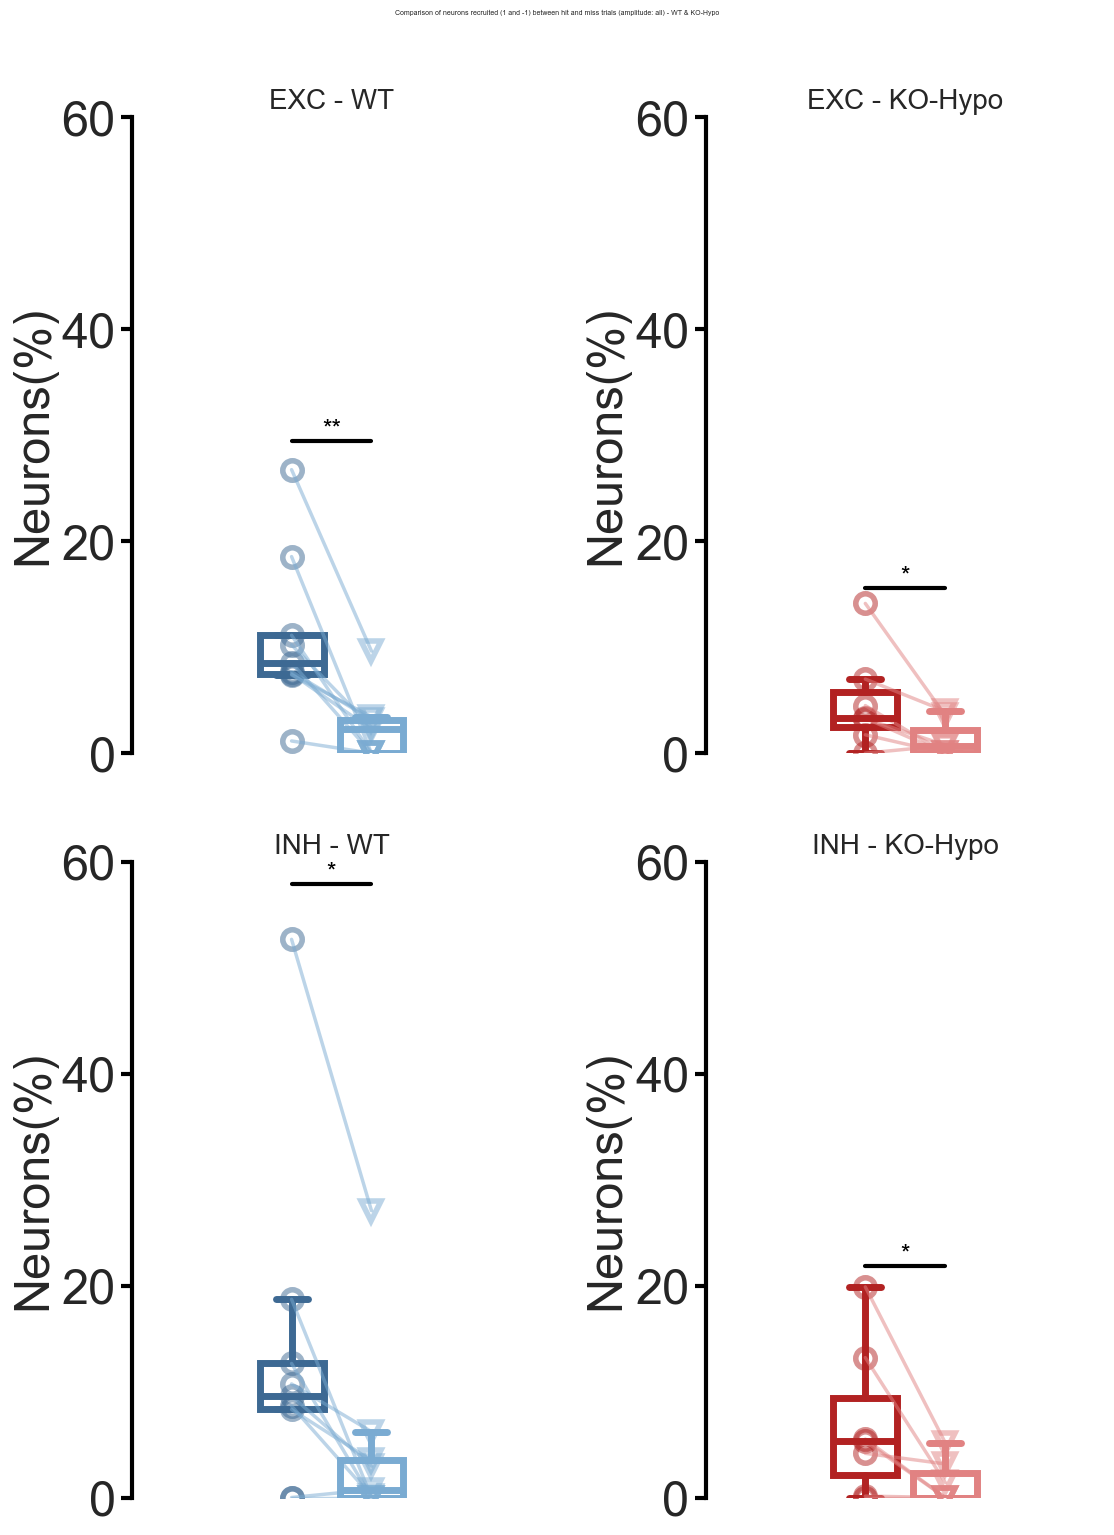

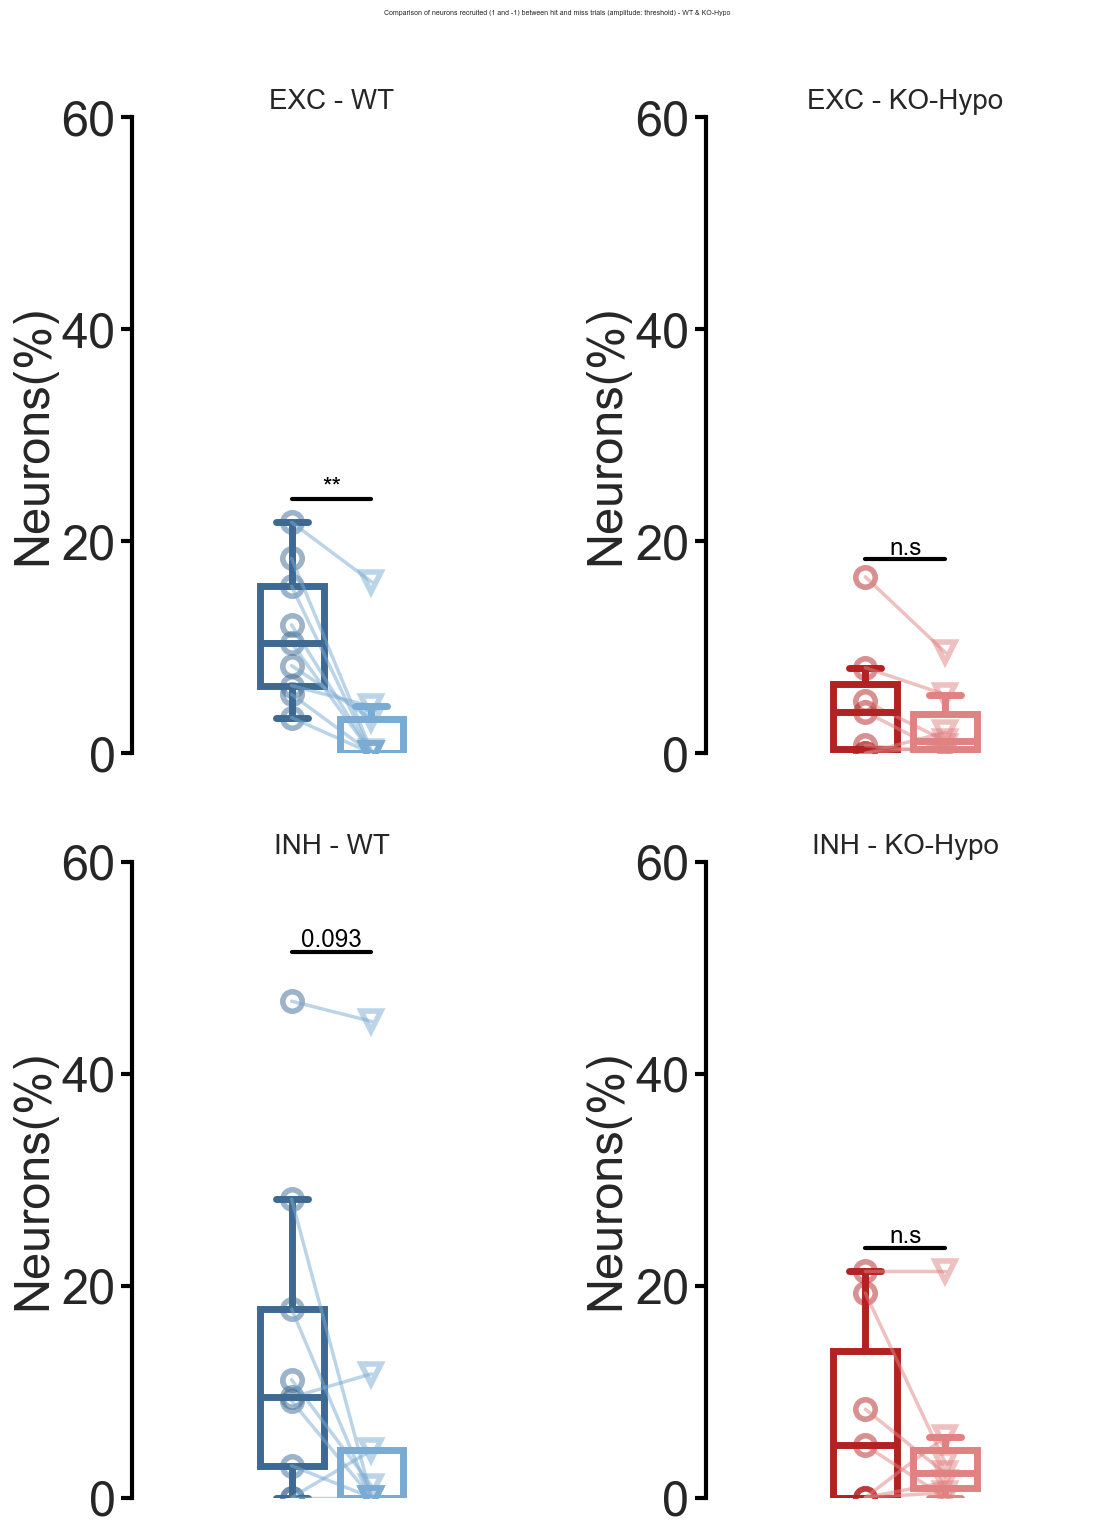

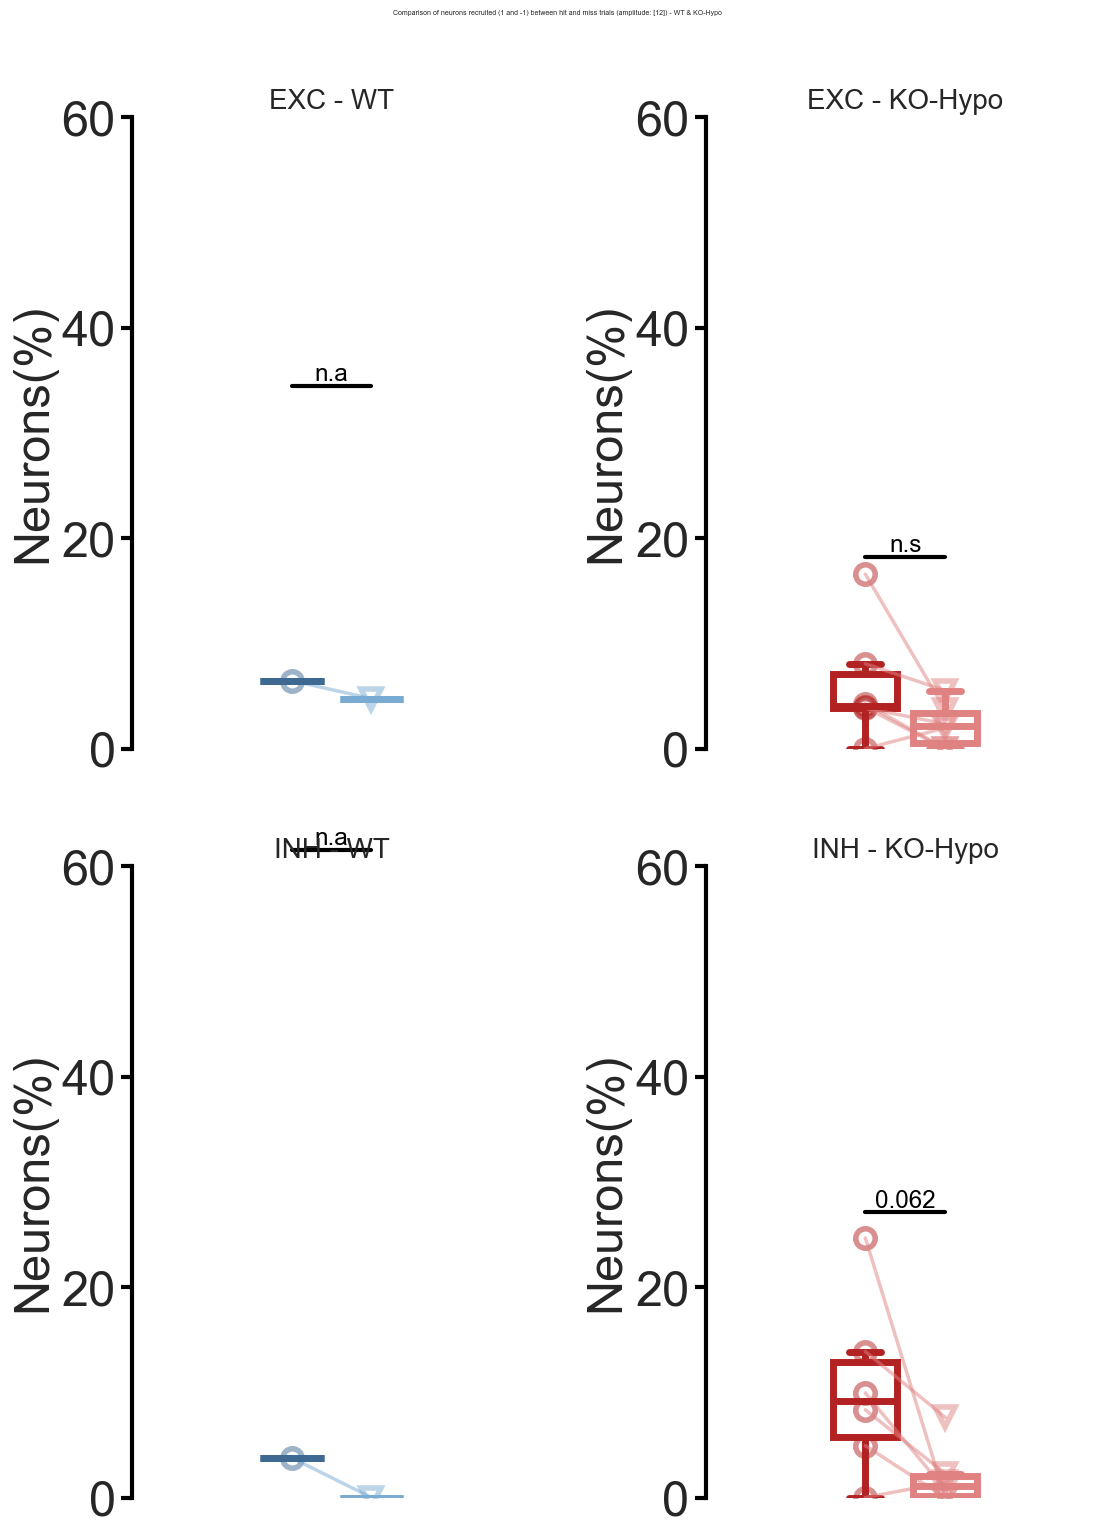

In [9]:
plot_neuron_frac_det_undet(0, ko_hypo_only=True, stim_ampl="all", ylim=[0,60], no_go_normalize=True)
plot_neuron_frac_det_undet(0, ko_hypo_only=True, stim_ampl="threshold", ylim=[0,60], no_go_normalize=True)
plot_neuron_frac_det_undet(0, ko_hypo_only=True, stim_ampl=[12], ylim=[0,60], no_go_normalize=True)

## Fraction of neurons activated(1)

Boxplot plotting.
--- Neurons(%): EXC - WT ---
ShapiroResult(statistic=0.9836016023198251, pvalue=0.9802147108830375)
ShapiroResult(statistic=0.87689508071603, pvalue=0.1456092842912433)
TtestResult(statistic=3.877638344869663, pvalue=0.004690414488300317, df=8)
Boxplot plotting.
--- Neurons(%): EXC - KO-Hypo ---
ShapiroResult(statistic=0.7355027702668262, pvalue=0.008930721412473343)
ShapiroResult(statistic=0.7588456843576243, pvalue=0.015682166842097823)
WilcoxonResult(statistic=1.0, pvalue=0.03125)
Boxplot plotting.
--- Neurons(%): INH - WT ---
ShapiroResult(statistic=0.8798206885102852, pvalue=0.15633951011524433)
ShapiroResult(statistic=0.897357972007691, pvalue=0.23708197857943808)
TtestResult(statistic=1.644508980827301, pvalue=0.13869209243808814, df=8)
Boxplot plotting.
--- Neurons(%): INH - KO-Hypo ---
ShapiroResult(statistic=0.9592661306954609, pvalue=0.8124141625501228)
ShapiroResult(statistic=0.7294639461935726, pvalue=0.007704846979215882)
WilcoxonResult(statistic=0.0, pv

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty sl

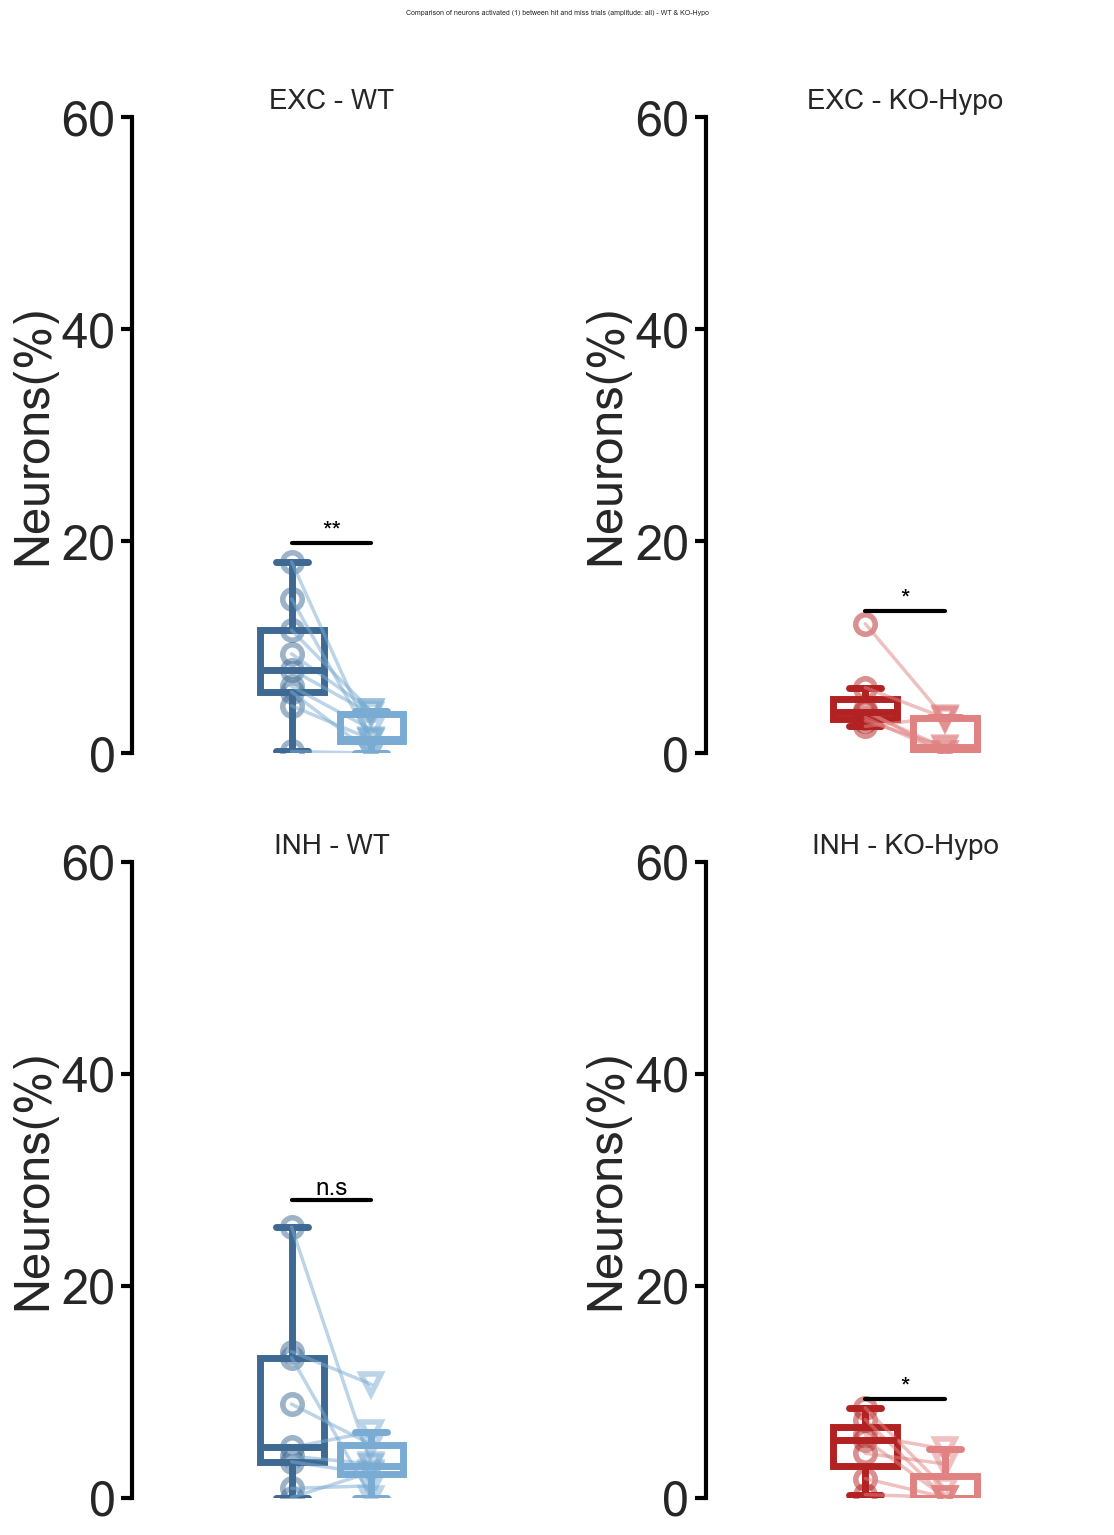

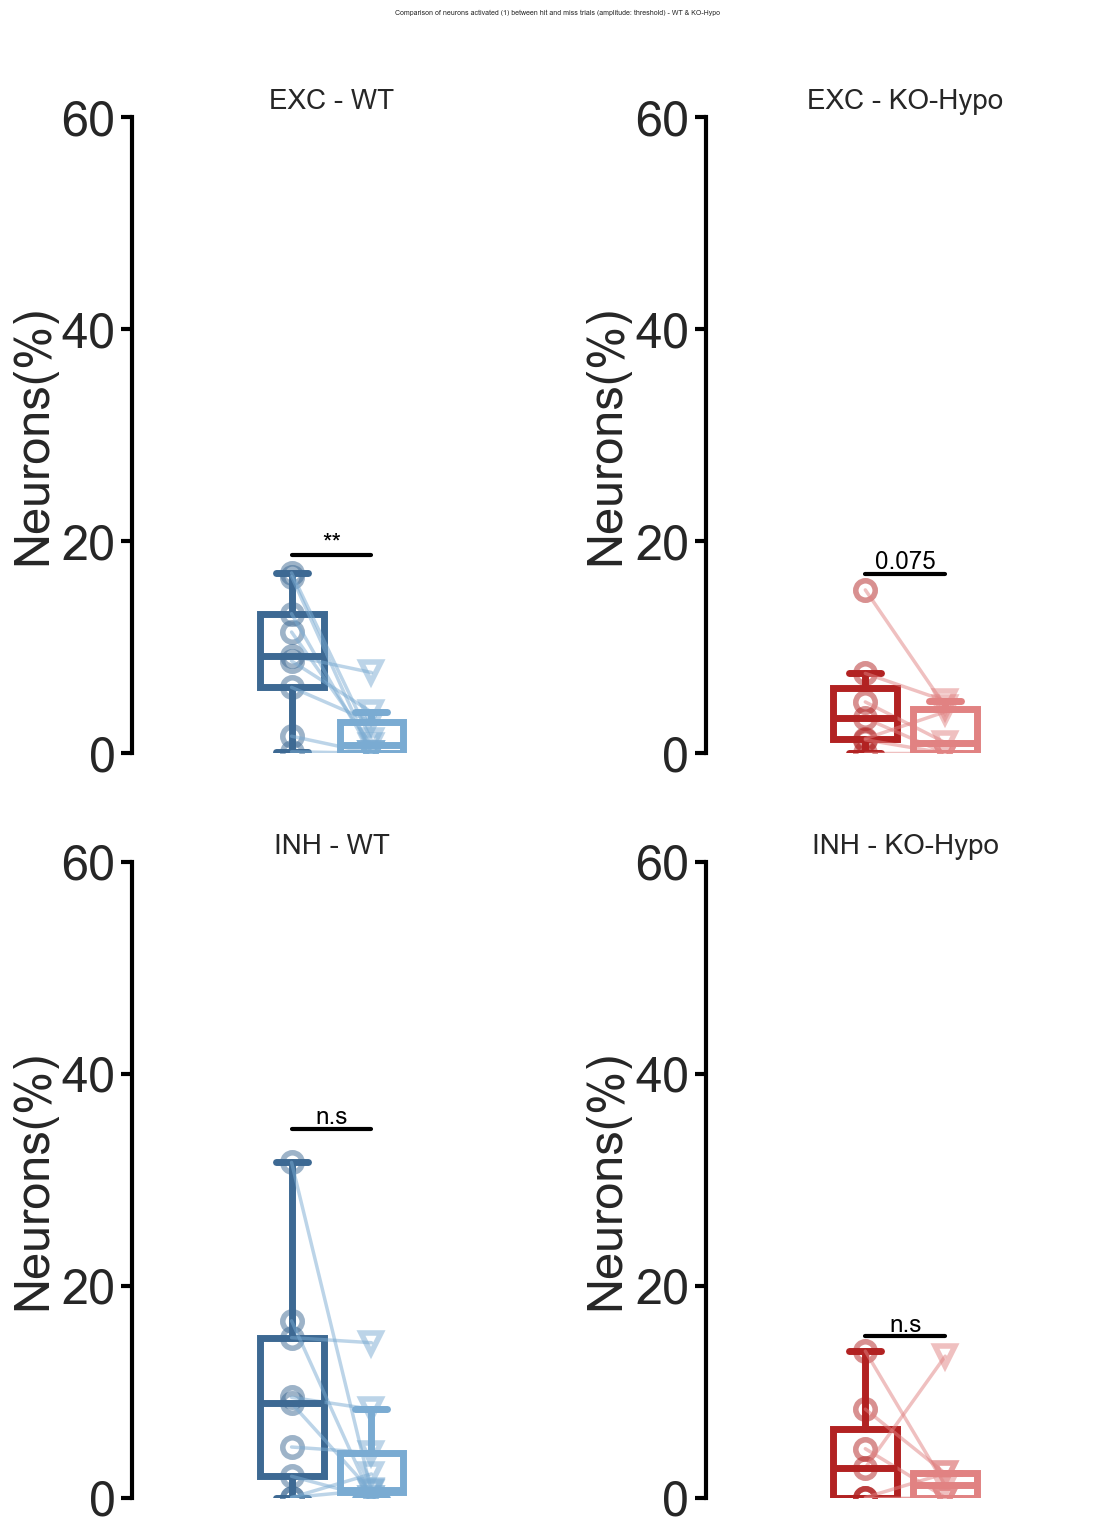

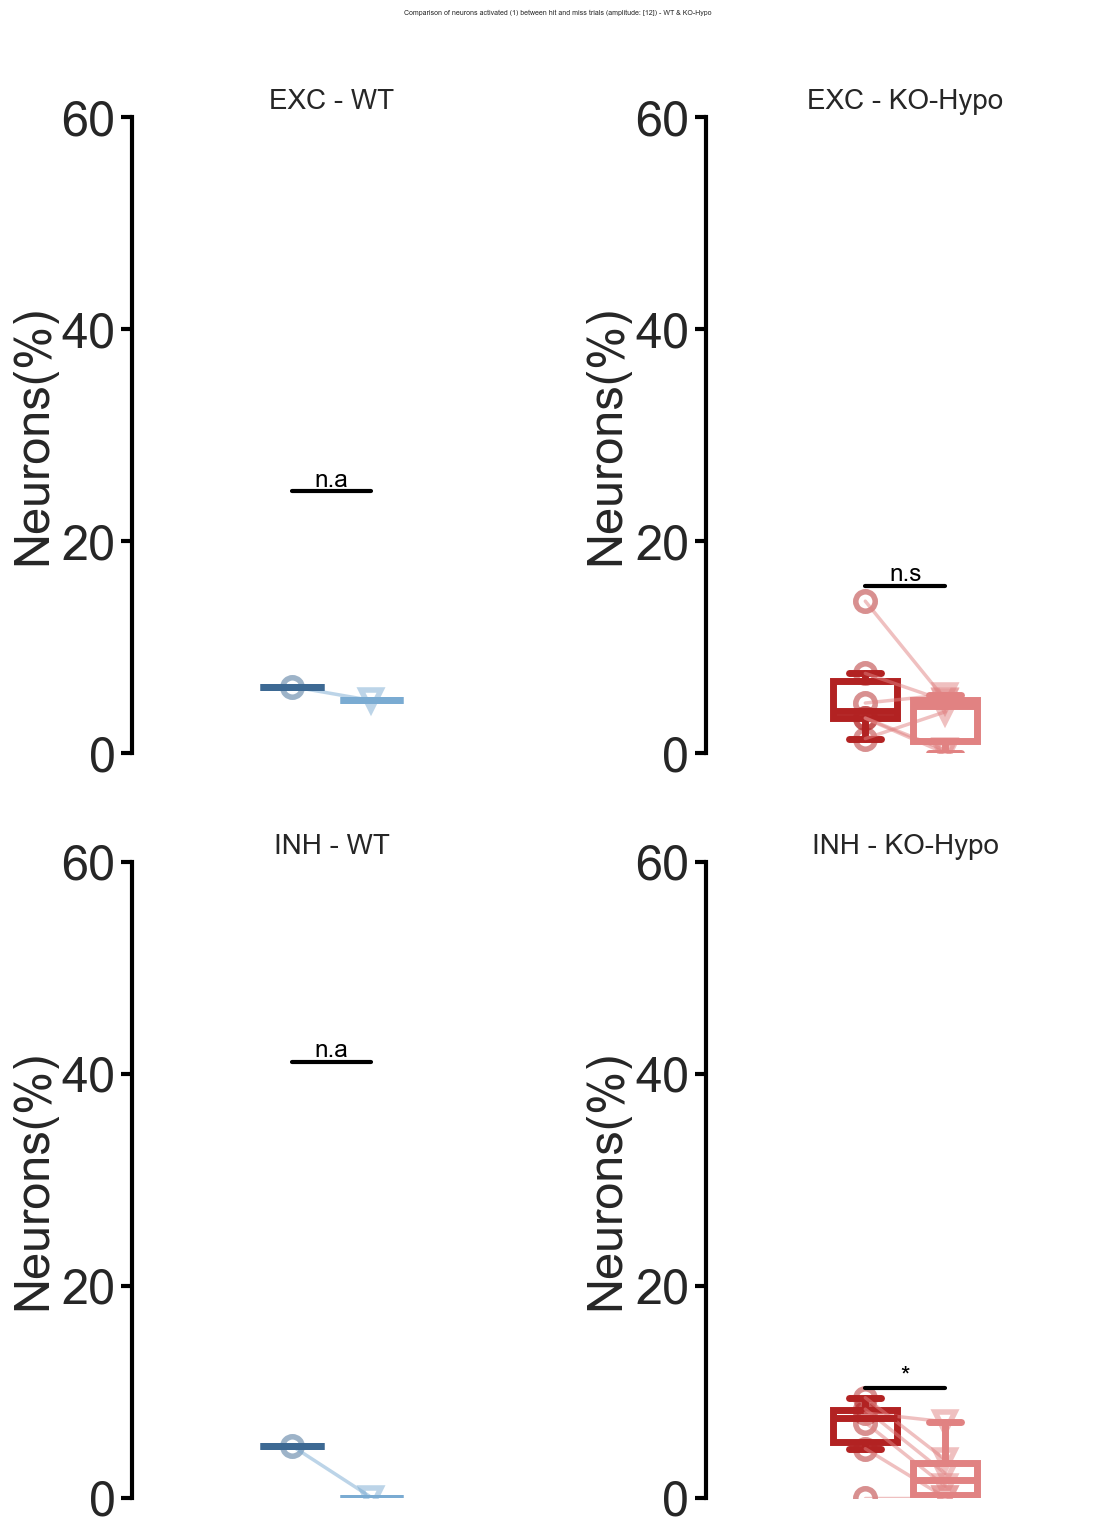

In [10]:
plot_neuron_frac_det_undet(1, ko_hypo_only=True, stim_ampl="all", ylim=[0,60], no_go_normalize=True)
plot_neuron_frac_det_undet(1, ko_hypo_only=True, stim_ampl="threshold", ylim=[0,60], no_go_normalize=True)
plot_neuron_frac_det_undet(1, ko_hypo_only=True, stim_ampl=[12], ylim=[0,60], no_go_normalize=True)

## Fraction of neurons inhibited (-1)

Boxplot plotting.
--- Neurons(%): EXC - WT ---
ShapiroResult(statistic=0.5680232626348434, pvalue=4.0306150933334e-05)
ShapiroResult(statistic=0.5359403861830357, pvalue=1.6919920176904313e-05)
WilcoxonResult(statistic=0.0, pvalue=0.027707849358079864)
Boxplot plotting.
--- Neurons(%): EXC - KO-Hypo ---
ShapiroResult(statistic=0.7611266894331306, pvalue=0.016557895128488716)
ShapiroResult(statistic=0.7402178634073038, pvalue=0.01001637342513202)
WilcoxonResult(statistic=0.0, pvalue=0.06788915486182899)
Boxplot plotting.
--- Neurons(%): INH - WT ---
ShapiroResult(statistic=0.6111283963569594, pvalue=0.00012923819375612095)
ShapiroResult(statistic=0.4957647500755076, pvalue=5.700679396940689e-06)
WilcoxonResult(statistic=0.0, pvalue=0.027707849358079864)
Boxplot plotting.
--- Neurons(%): INH - KO-Hypo ---
ShapiroResult(statistic=0.613639430433425, pvalue=0.0003931102742140617)
ShapiroResult(statistic=0.6224927562751993, pvalue=0.0004980648490486538)
WilcoxonResult(statistic=1.0, pvalue=0

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\

Boxplot plotting.
Boxplot plotting.
--- Neurons(%): EXC - KO-Hypo ---
ShapiroResult(statistic=0.8525479204549054, pvalue=0.1650277120875535)
ShapiroResult(statistic=0.650403168201247, pvalue=0.00177833449524729)
WilcoxonResult(statistic=1.0, pvalue=0.14412703481601533)
Boxplot plotting.
Boxplot plotting.
--- Neurons(%): INH - KO-Hypo ---
ShapiroResult(statistic=0.6852467256205228, pvalue=0.0043053614294846)
ShapiroResult(statistic=0.5812588566993151, pvalue=0.00027071765341387153)
WilcoxonResult(statistic=3.0, pvalue=0.22491588401596185)


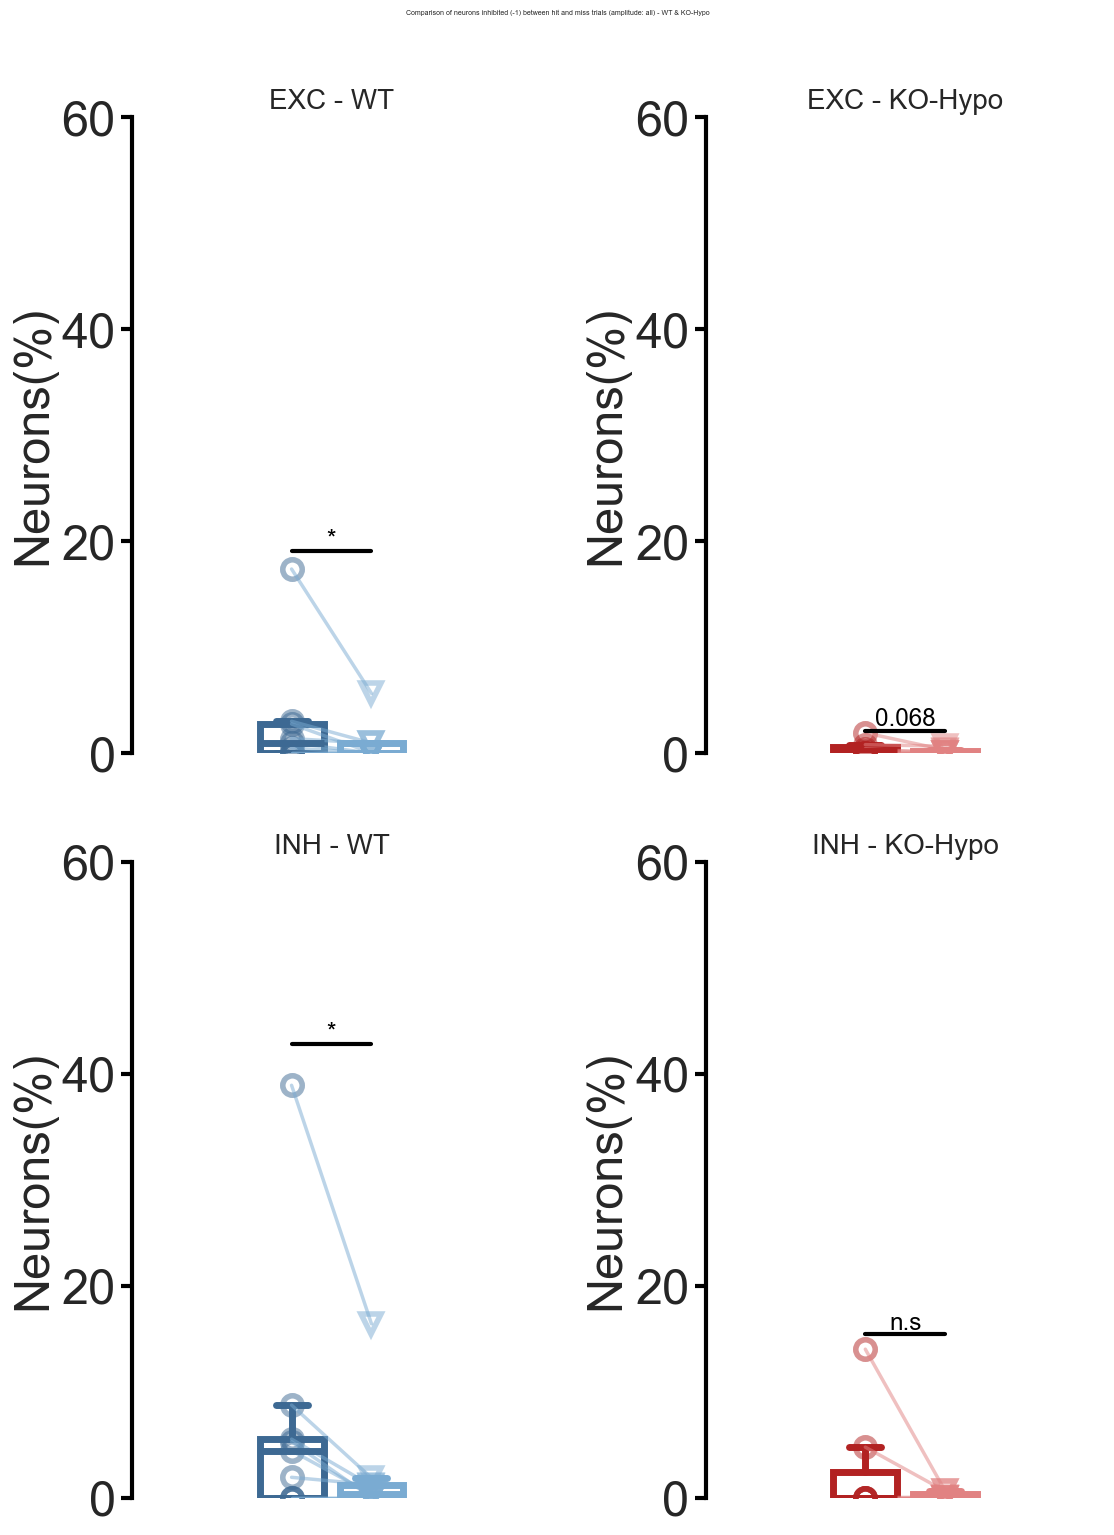

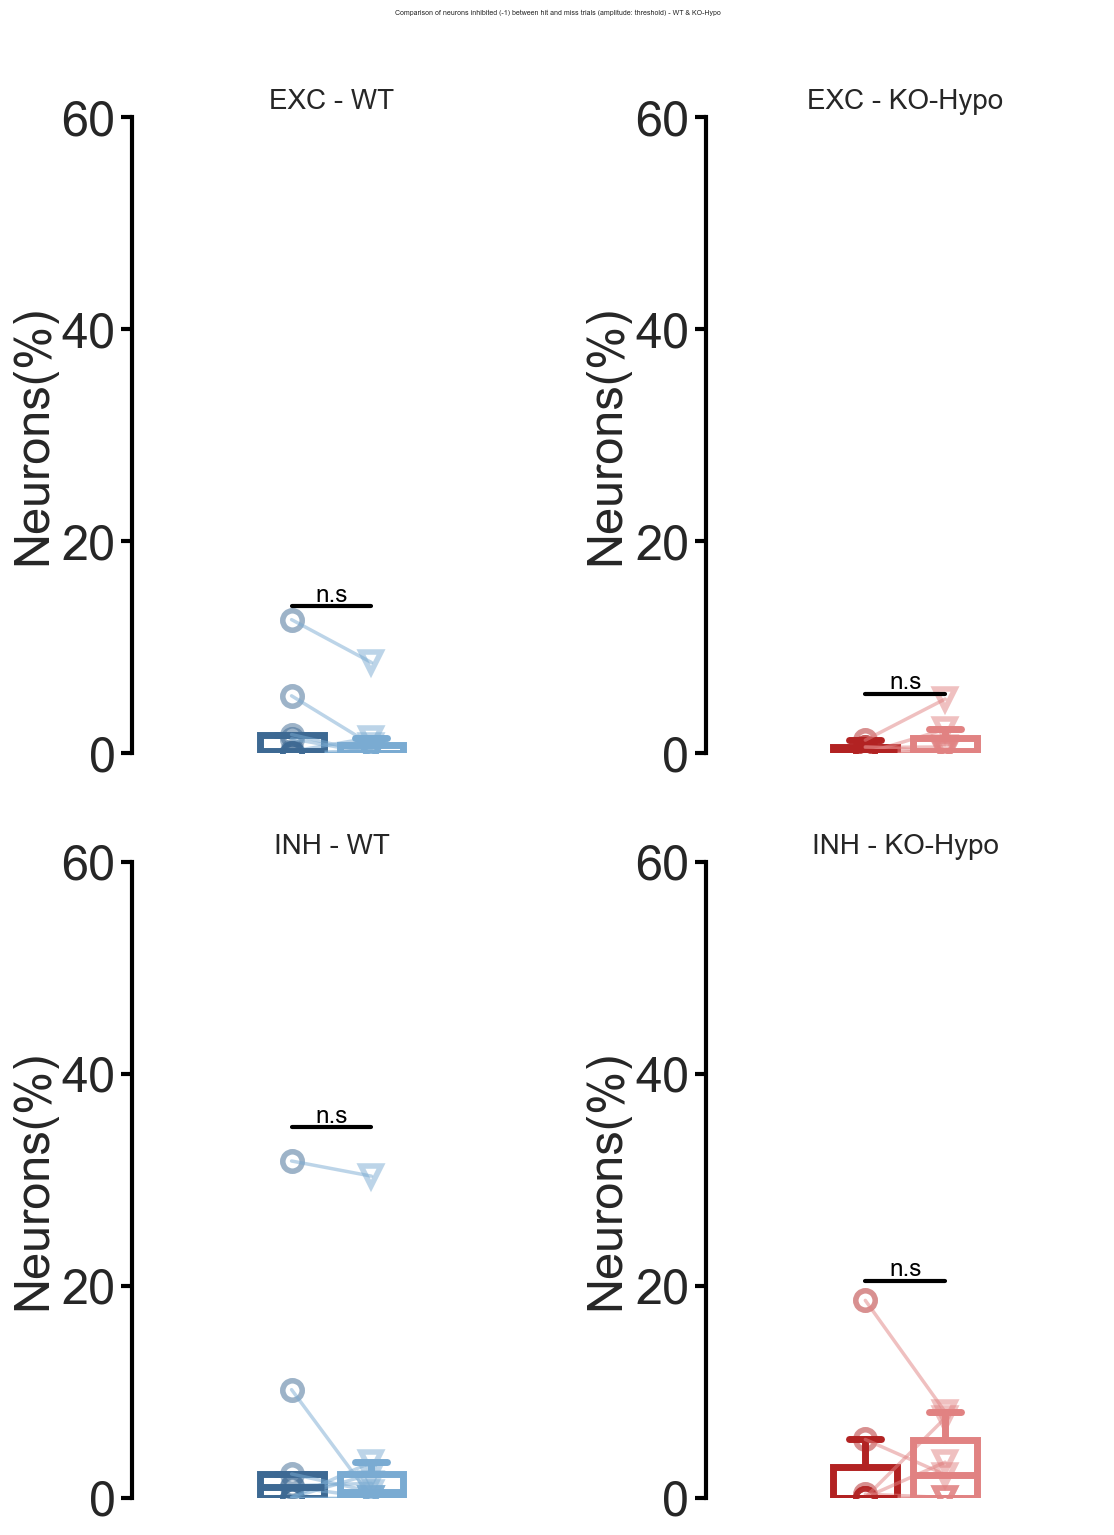

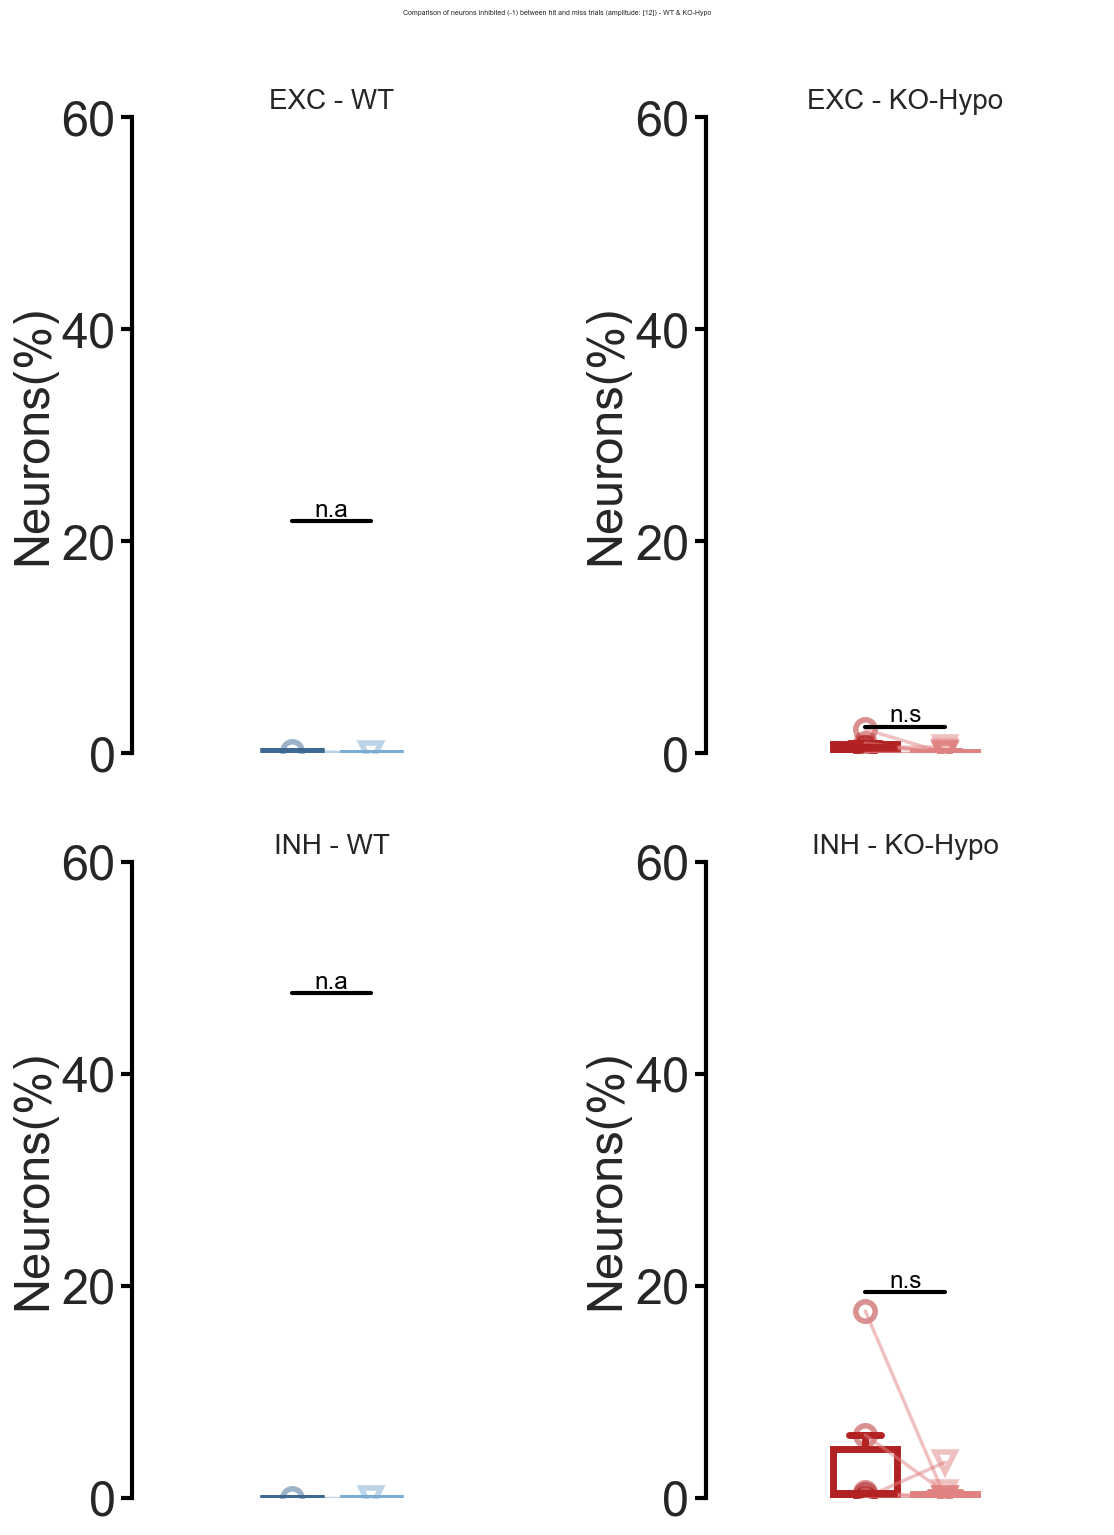

In [11]:
plot_neuron_frac_det_undet(-1, ko_hypo_only=True, stim_ampl="all", ylim=[0,60], no_go_normalize=True)
plot_neuron_frac_det_undet(-1, ko_hypo_only=True, stim_ampl="threshold", ylim=[0,60], no_go_normalize=True)
plot_neuron_frac_det_undet(-1, ko_hypo_only=True, stim_ampl=[12], ylim=[0,60], no_go_normalize=True)

# Responsivity contrast between det and undet trials

## Ratio

### responsivity contrast of neurons recruited

In [12]:
def resp_contrast(pattern="recruited", stim_ampl="all", method="ratio", ylim=[]):
    pat_dict = {"recruited": 0, "activated": 1, "inhibited": -1}
    fig, axs = plt.subplots(1,2,figsize=(12,8))
    for i, type in enumerate(["EXC", "INH"]):
        wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=pat_dict[pattern], n_type=type, ko_hypo_only=True, stim_ampl=stim_ampl)
        if method == "ratio":
            wt_nan = np.logical_and(wt_det>0, wt_undet>0)
            ko_nan = np.logical_and(ko_det>0, ko_undet>0)
            wt_det, ko_det, wt_undet, ko_undet = wt_det[wt_nan], ko_det[ko_nan], wt_undet[wt_nan], ko_undet[ko_nan]
            wt = wt_det/wt_undet
            ko = ko_det/ko_undet
        elif method == "delta":
            wt = wt_det - wt_undet
            ko = ko_det - ko_undet
        ppt.boxplot(axs[i], wt, ko, ylabel=f"{method} nb neuron Hit/Miss", paired=False, ylim=ylim)
        fig.suptitle(f"Comparaison of {method} of {pattern} neurons between detected and undetected trials for {stim_ampl} stimulus", fontsize=10)
    fig.tight_layout()
    if save_figure:
        fig.savefig(server_address + f"Figure2/responsivity/contrast_resp_{method}({pattern})_{stim_ampl}.pdf")
    plt.show()

Boxplot plotting.
--- ratio nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.9465892148441256, pvalue=0.712813750722129)
ShapiroResult(statistic=0.8306949773928767, pvalue=0.19009941643159312)
LeveneResult(statistic=0.16083535718909267, pvalue=0.702280391382836)
Equal variances :TtestResult(statistic=-0.46339456776864657, pvalue=0.6594145742240731, df=6.0)
Boxplot plotting.
--- ratio nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.5706300932631168, pvalue=0.0002451823364387041)
ShapiroResult(statistic=0.9579403969598815, pvalue=0.6055187121987158)
MannwhitneyuResult(statistic=7.0, pvalue=1.0)


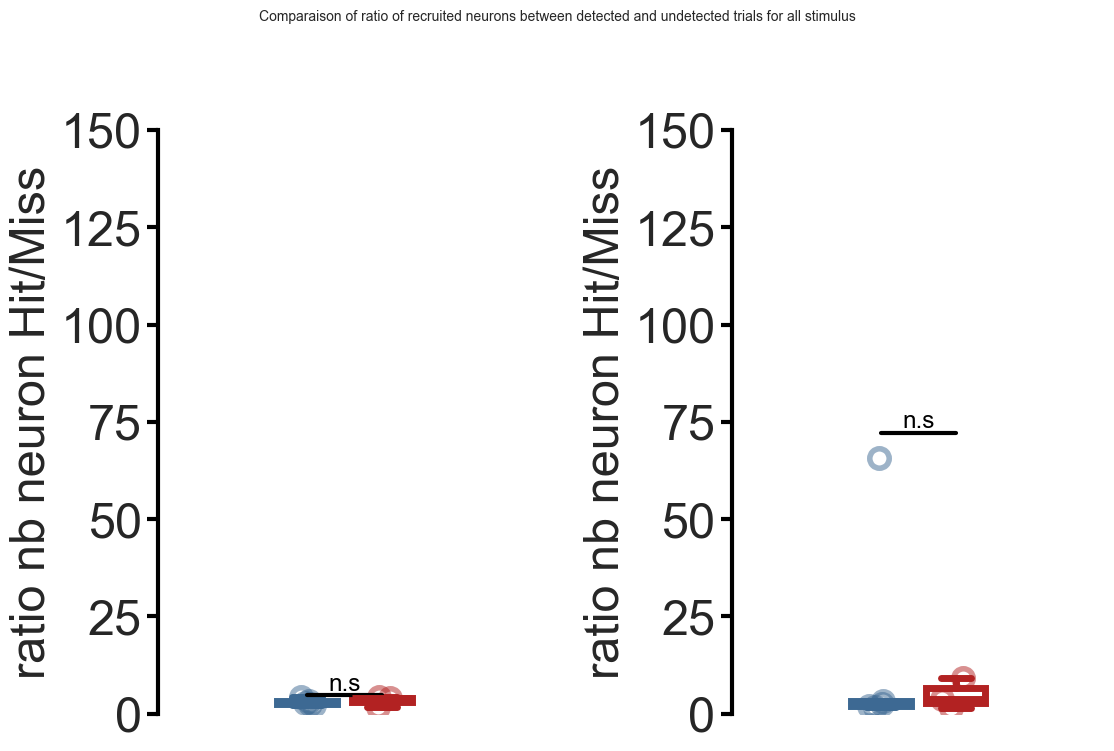

Boxplot plotting.
--- ratio nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.6398717942816137, pvalue=0.0017997164226543272)
ShapiroResult(statistic=0.8279763302513562, pvalue=0.18319875414526376)
MannwhitneyuResult(statistic=5.0, pvalue=0.8571428571428571)
Boxplot plotting.
--- ratio nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.7689918645719924, pvalue=0.04244146252053105)
ShapiroResult(statistic=0.9969856819894498, pvalue=0.8950906159737703)
MannwhitneyuResult(statistic=4.0, pvalue=1.0)


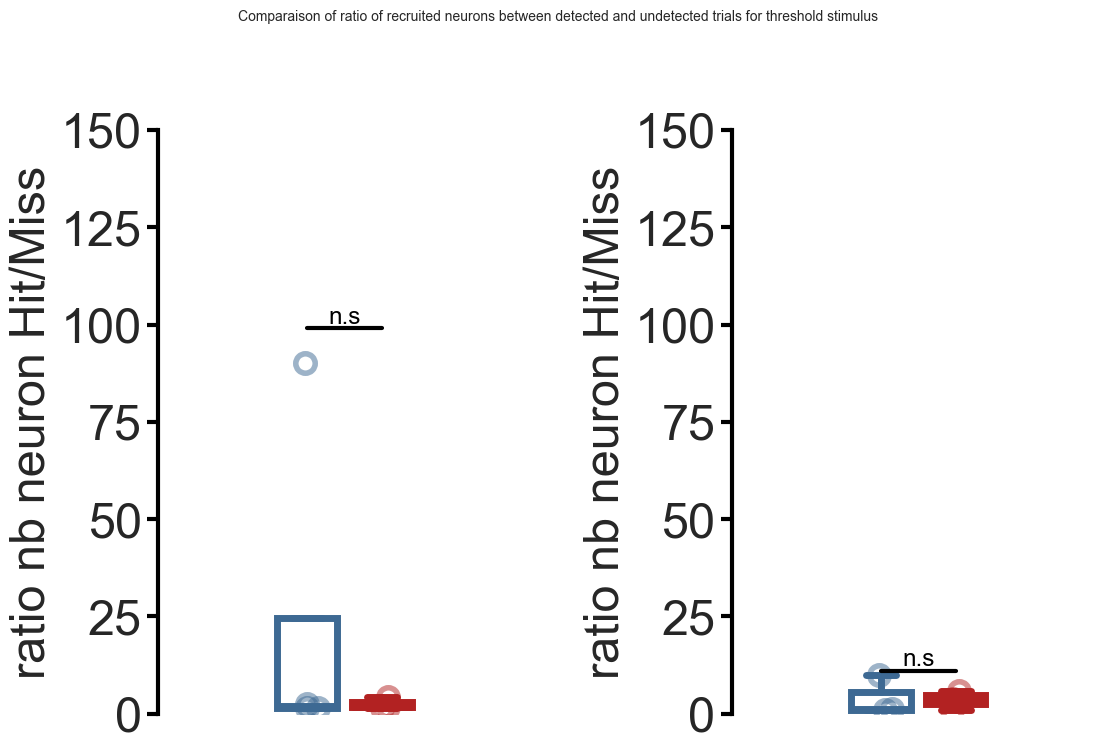

In [13]:
resp_contrast(pattern="recruited", stim_ampl="all", method="ratio", ylim=[0, 150])
resp_contrast(pattern="recruited", stim_ampl="threshold", method="ratio", ylim=[0, 150])

### responsivity contrast of neurons activated

Boxplot plotting.
--- ratio nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.6907560176456239, pvalue=0.002936163147864207)
ShapiroResult(statistic=0.9667278322262819, pvalue=0.8538662193645428)
MannwhitneyuResult(statistic=20.0, pvalue=0.7550505050505051)
Boxplot plotting.
--- ratio nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.5756183779341395, pvalue=0.00013990705643903141)
ShapiroResult(statistic=0.752233766891016, pvalue=0.0049335407880019)
MannwhitneyuResult(statistic=7.0, pvalue=0.5166666666666666)


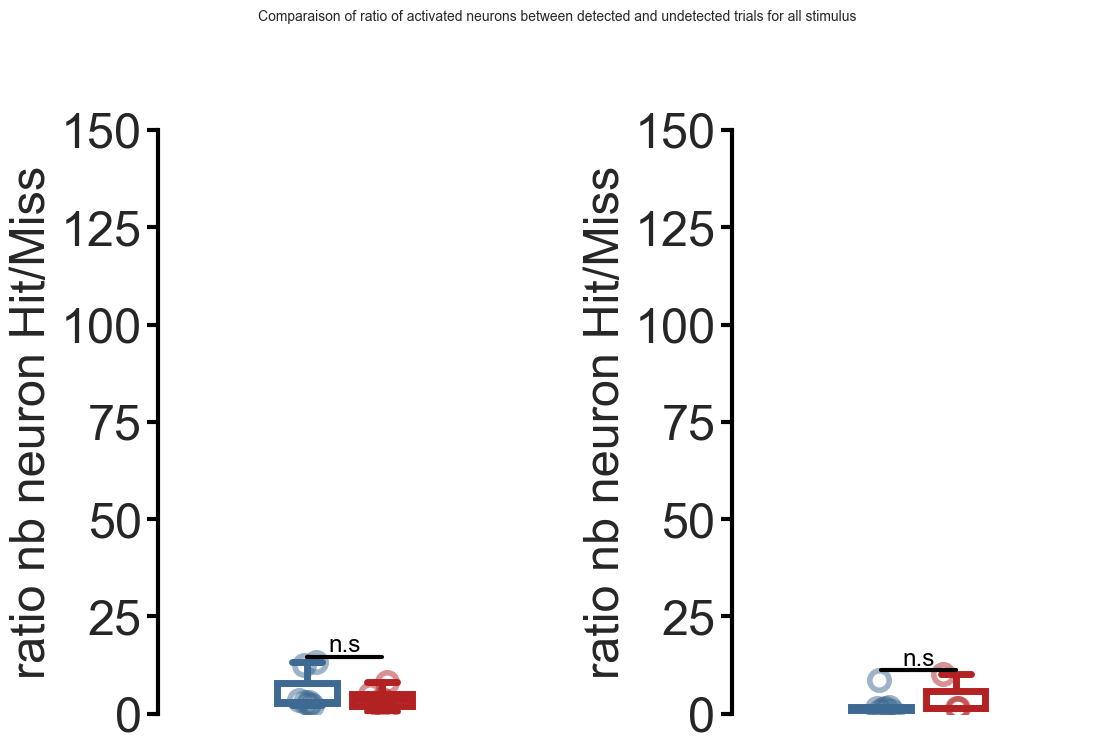

Boxplot plotting.
--- ratio nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.7465597552772303, pvalue=0.027649539021555775)
ShapiroResult(statistic=0.9687092597076206, pvalue=0.8334746799287625)
MannwhitneyuResult(statistic=13.0, pvalue=0.5555555555555556)
Boxplot plotting.
--- ratio nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.7139708681774555, pvalue=0.013331899730263526)
ShapiroResult(statistic=0.9450123777506902, pvalue=0.5479392968656098)
MannwhitneyuResult(statistic=9.0, pvalue=0.7857142857142857)


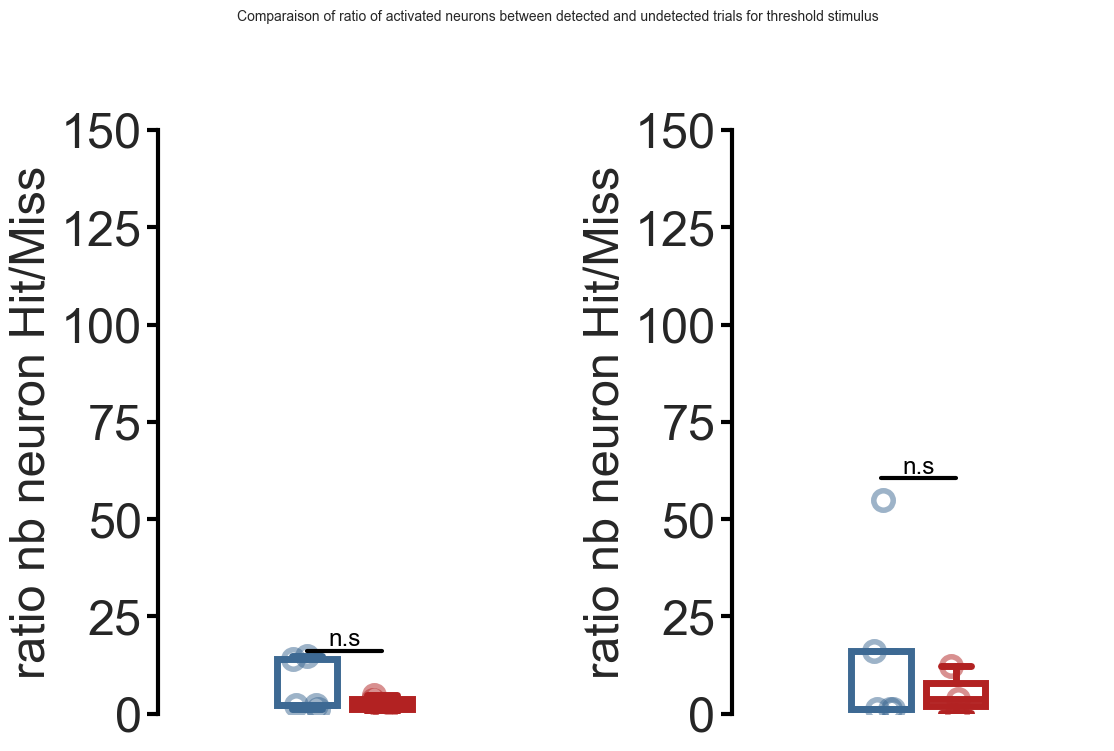

In [14]:
resp_contrast(pattern="activated", stim_ampl="all", method="ratio", ylim=[0, 150])
resp_contrast(pattern="activated", stim_ampl="threshold", method="ratio", ylim=[0, 150])

### responsivity contrast of neurons inhibited


Boxplot plotting.
--- ratio nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.6527691269442958, pvalue=0.00281566699043895)
ShapiroResult(statistic=0.7560452434331374, pvalue=0.0133862769082157)
MannwhitneyuResult(statistic=9.0, pvalue=0.4)
Boxplot plotting.


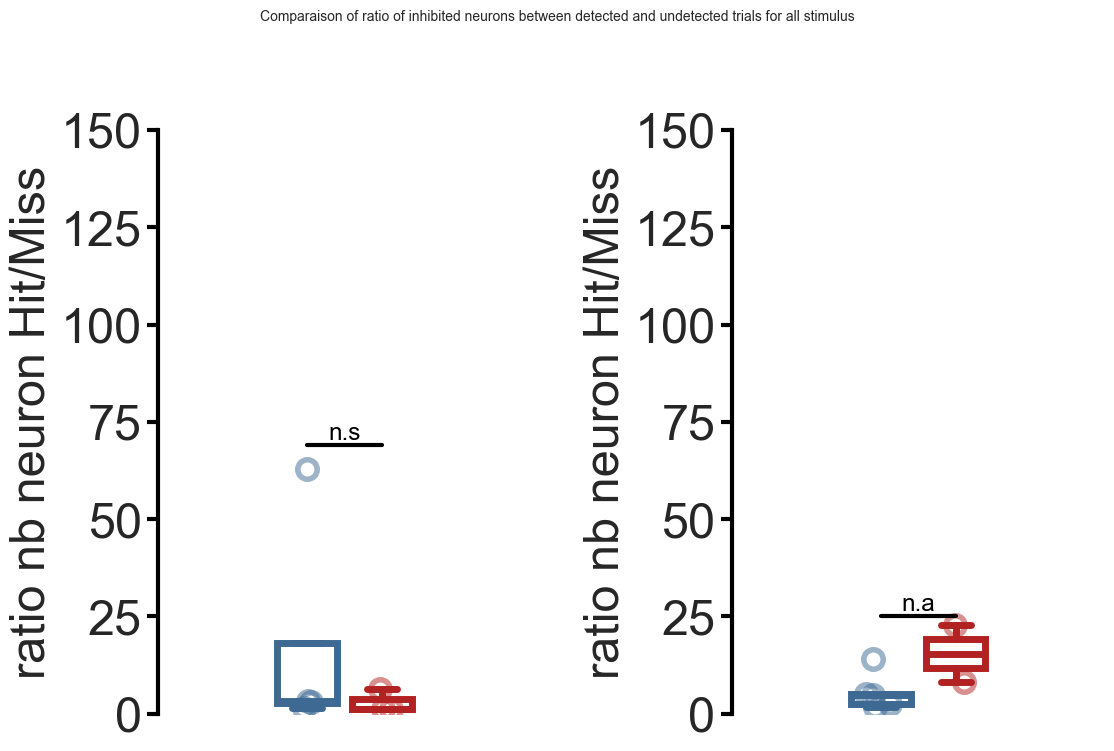

Boxplot plotting.
--- ratio nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.8944506924858702, pvalue=0.3680493736910603)
ShapiroResult(statistic=0.7795814753170031, pvalue=0.07036087051787016)
LeveneResult(statistic=0.6734947865859777, pvalue=0.4491777706282824)
Equal variances :TtestResult(statistic=0.7753787133071968, pvalue=0.47317446201275104, df=5.0)
Boxplot plotting.


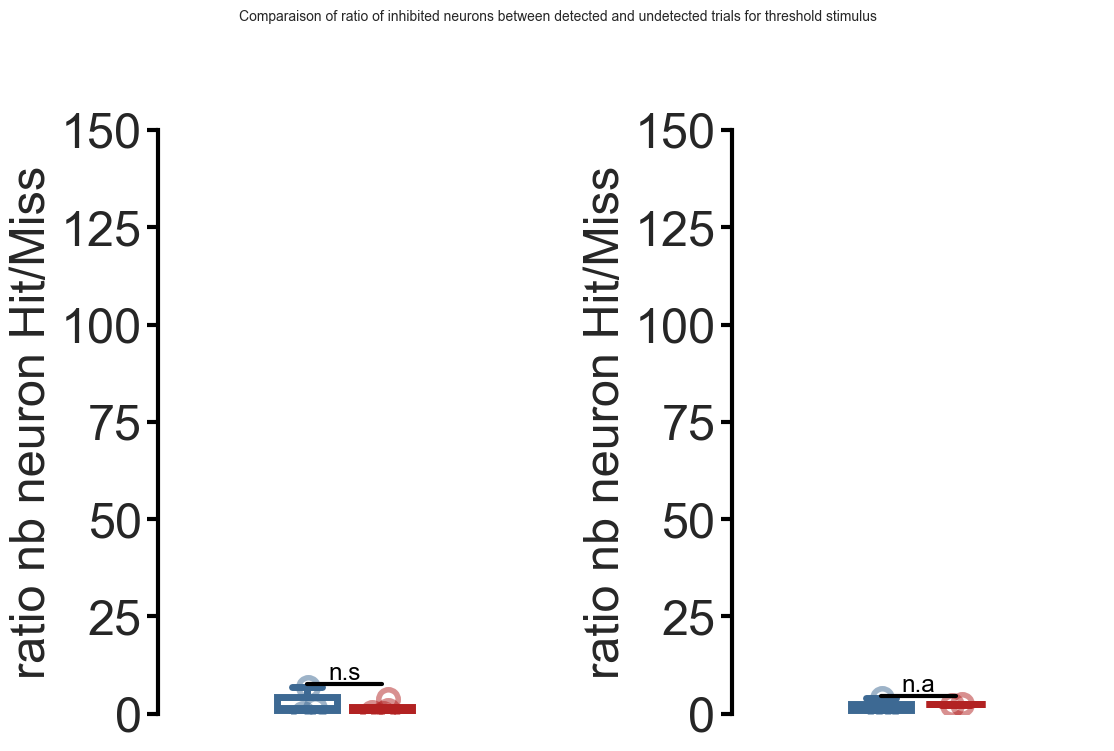

In [15]:
resp_contrast(pattern="inhibited", stim_ampl="all", method="ratio", ylim=[0, 150])
resp_contrast(pattern="inhibited", stim_ampl="threshold", method="ratio", ylim=[0, 150])

## Delta

### Recruited

Boxplot plotting.
--- delta nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.917860122902165, pvalue=0.3748177728621313)
ShapiroResult(statistic=0.8715474991537433, pvalue=0.19149324883022412)
LeveneResult(statistic=2.043477744928536, pvalue=0.17479430917614008)
Equal variances :TtestResult(statistic=2.0091627382499686, pvalue=0.0642057257148876, df=14.0)
Boxplot plotting.
--- delta nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.9193345474801017, pvalue=0.3867586580558987)
ShapiroResult(statistic=0.8728338849407247, pvalue=0.19649119871848786)
LeveneResult(statistic=0.5595914133254767, pvalue=0.4668060351381095)
Equal variances :TtestResult(statistic=0.9085796692394149, pvalue=0.3789473921416162, df=14.0)


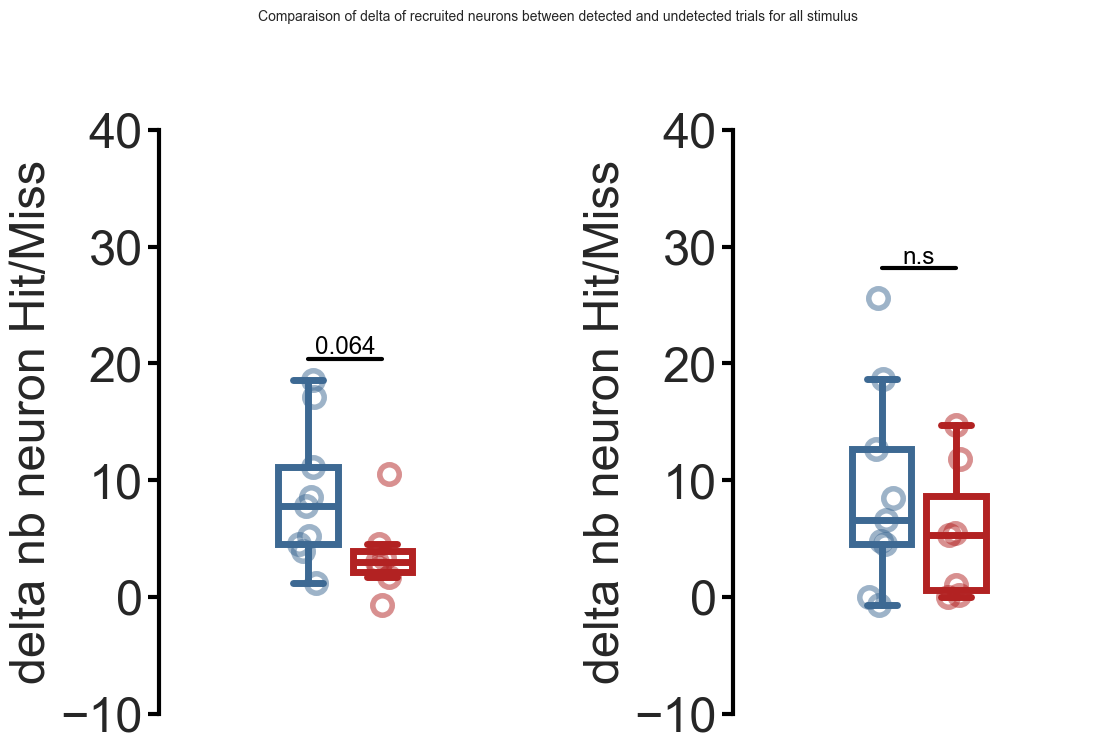

Boxplot plotting.
--- delta nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.912424432175384, pvalue=0.3332140013535213)
ShapiroResult(statistic=0.9728445240035146, pvalue=0.918152620339356)
LeveneResult(statistic=1.3652589745106773, pvalue=0.26214059501145337)
Equal variances :TtestResult(statistic=2.6914182036631784, pvalue=0.017549039435413055, df=14.0)
Boxplot plotting.
--- delta nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.908585639685034, pvalue=0.30610055803054886)
ShapiroResult(statistic=0.9195360956683563, pvalue=0.4657967321042545)
LeveneResult(statistic=0.653365841076725, pvalue=0.4324332661028085)
Equal variances :TtestResult(statistic=0.9206416620138277, pvalue=0.3728297813906577, df=14.0)


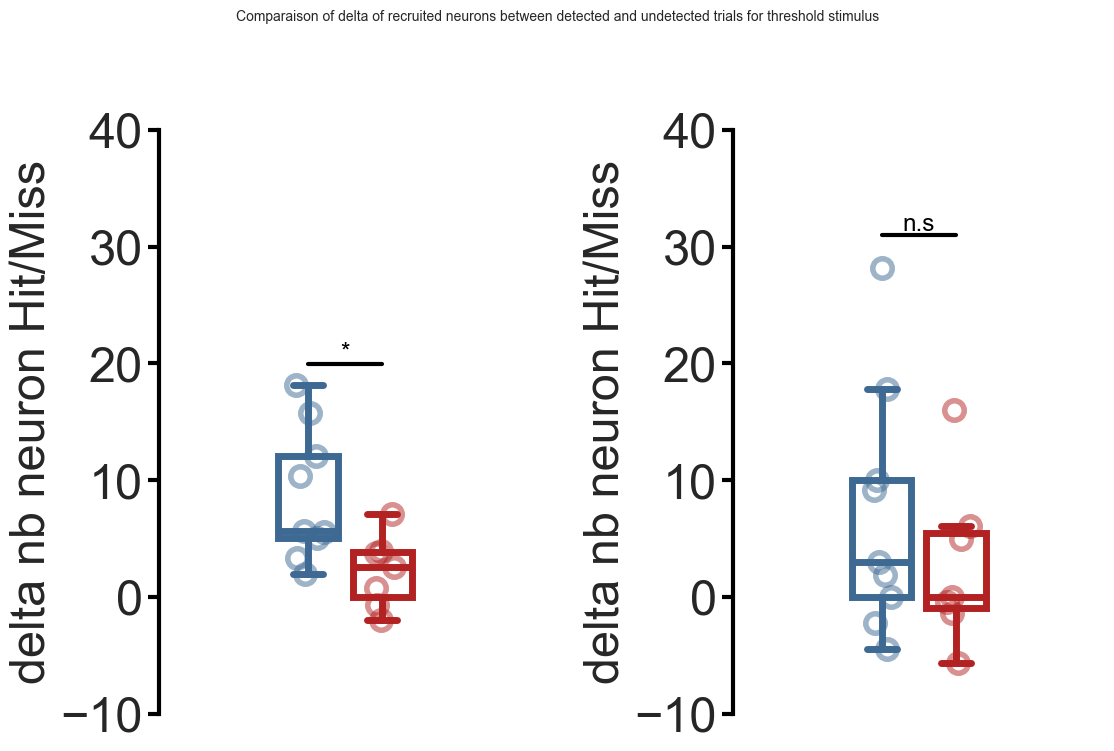

In [16]:
resp_contrast(pattern="recruited", stim_ampl="all", method="delta", ylim=[-10, 40])
resp_contrast(pattern="recruited", stim_ampl="threshold", method="delta", ylim=[-10, 40])

### Activated

Boxplot plotting.
--- delta nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.8930513295517778, pvalue=0.21441180139039362)
ShapiroResult(statistic=0.8817873854499125, pvalue=0.23450095888576566)
LeveneResult(statistic=1.2473929425173587, pvalue=0.28285276731915776)
Equal variances :TtestResult(statistic=1.4836301968661387, pvalue=0.16006870781035182, df=14.0)
Boxplot plotting.
--- delta nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.783062493975208, pvalue=0.013061669472922347)
ShapiroResult(statistic=0.8363950655689112, pvalue=0.09193836149866437)
MannwhitneyuResult(statistic=25.0, pvalue=0.5360139860139861)


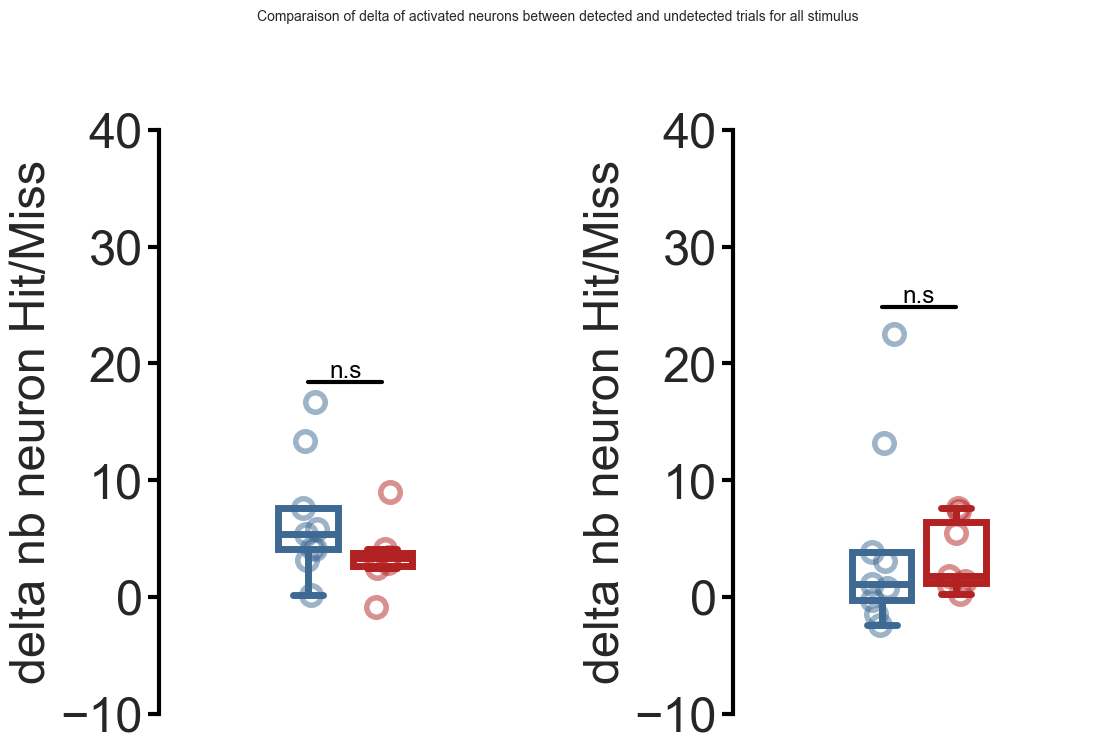

Boxplot plotting.
--- delta nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.8737956996239373, pvalue=0.13498511875686697)
ShapiroResult(statistic=0.9105376715130584, pvalue=0.3996095604697749)
LeveneResult(statistic=2.2069718999761285, pvalue=0.1595561350158635)
Equal variances :TtestResult(statistic=1.6558506156020822, pvalue=0.11998593067238762, df=14.0)
Boxplot plotting.
--- delta nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.7559573217497302, pvalue=0.006355802983375998)
ShapiroResult(statistic=0.9755236049817374, pvalue=0.935125154021161)
MannwhitneyuResult(statistic=40.0, pvalue=0.39675373905434974)


C:\Users\cvandromme\PycharmProjects\Percephone\percephone\plts\stats.py:126: UserWarning: The ylim you have set don't cover the data range.
  warnings.warn("The ylim you have set don't cover the data range.")


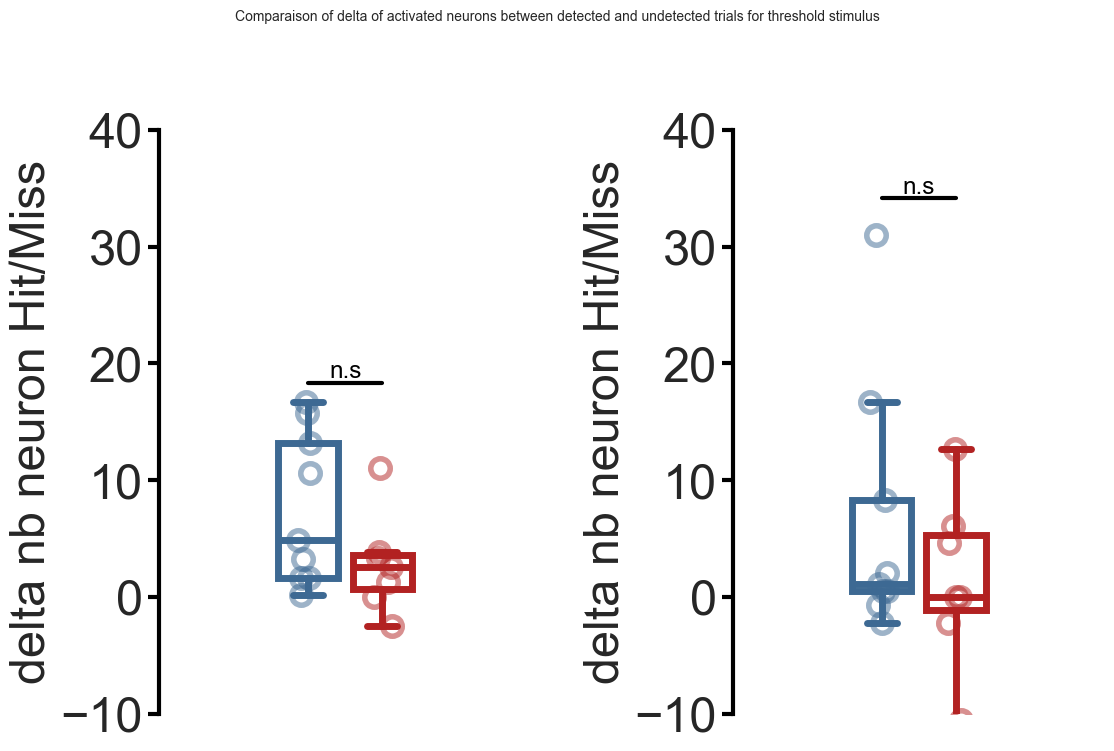

In [17]:
resp_contrast(pattern="activated", stim_ampl="all", method="delta", ylim=[-10, 40])
resp_contrast(pattern="activated", stim_ampl="threshold", method="delta", ylim=[-10, 40])

### Inhibited

Boxplot plotting.
--- delta nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.6018492508775599, pvalue=0.00010057968720174022)
ShapiroResult(statistic=0.6327134938827242, pvalue=0.000653322416025981)
MannwhitneyuResult(statistic=43.5, pvalue=0.21134337771623746)
Boxplot plotting.
--- delta nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.7035151334749161, pvalue=0.0015599064949888902)
ShapiroResult(statistic=0.6057849677643549, pvalue=0.00031827212803494184)
MannwhitneyuResult(statistic=44.0, pvalue=0.18484397422753407)


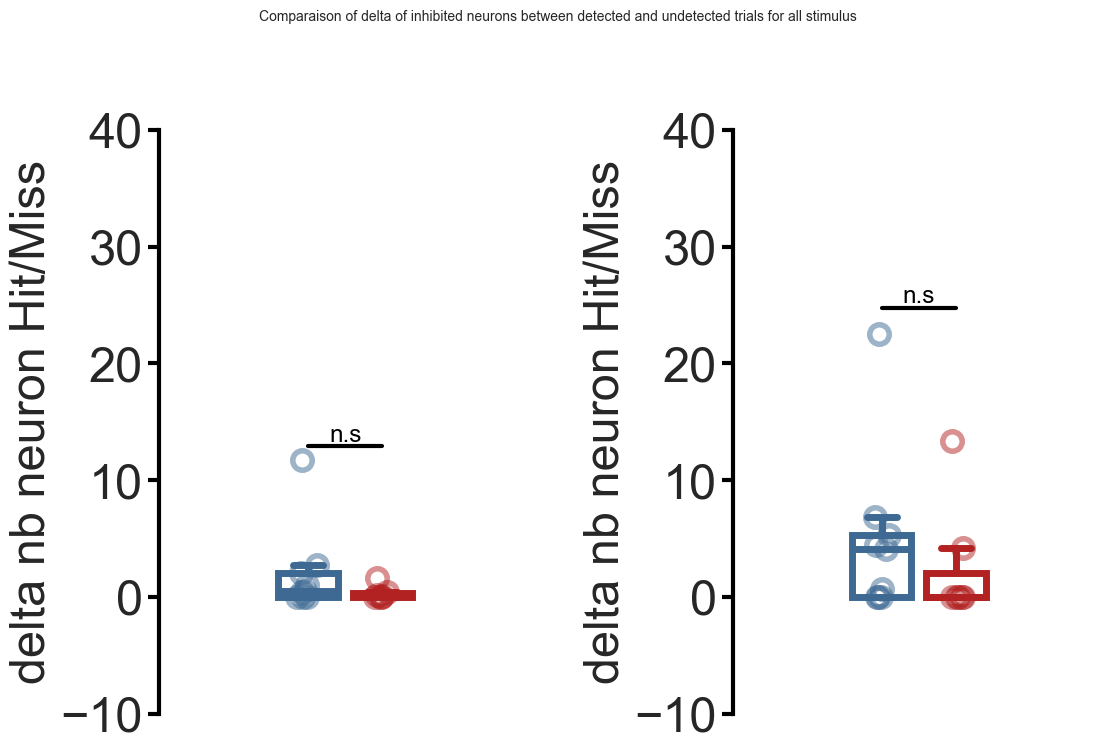

Boxplot plotting.
--- delta nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.8764494137166448, pvalue=0.1440355089600182)
ShapiroResult(statistic=0.743115243004723, pvalue=0.010745334121423993)
MannwhitneyuResult(statistic=47.0, pvalue=0.10703901034709812)
Boxplot plotting.
--- delta nb neuron Hit/Miss:  ---
ShapiroResult(statistic=0.7905348057512522, pvalue=0.015913988694593005)
ShapiroResult(statistic=0.9416219981362584, pvalue=0.653370542692235)
MannwhitneyuResult(statistic=32.5, pvalue=0.9574459103276607)


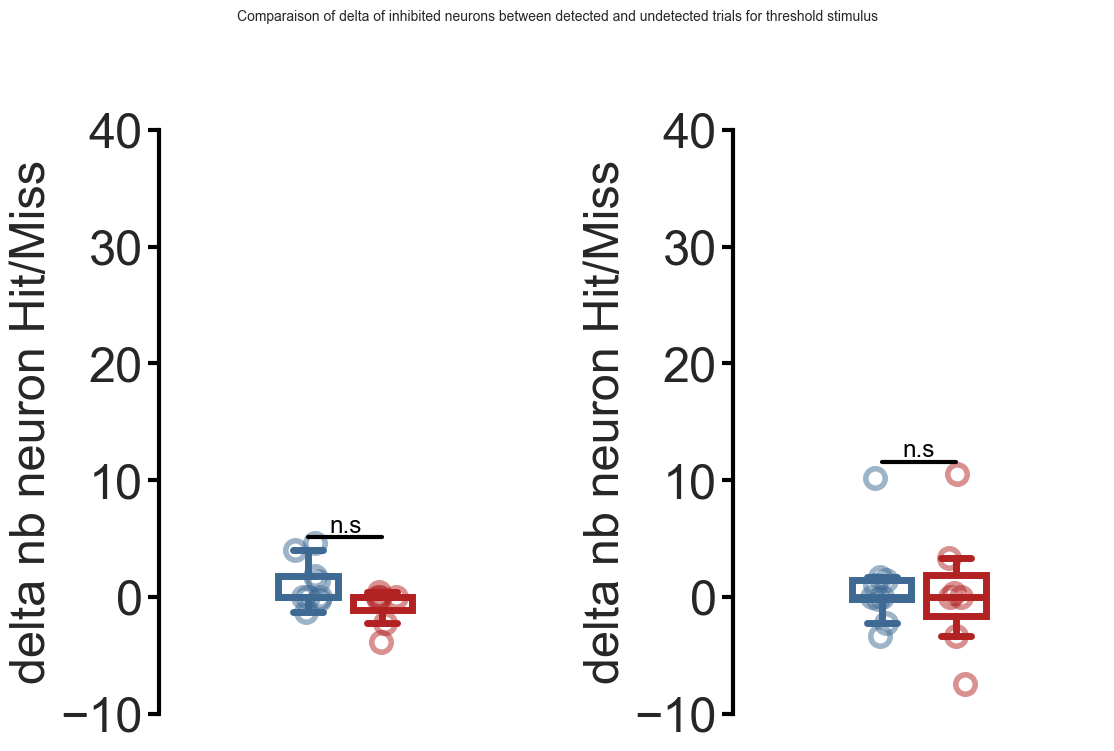

In [18]:
resp_contrast(pattern="inhibited", stim_ampl="all", method="delta", ylim=[-10, 40])
resp_contrast(pattern="inhibited", stim_ampl="threshold", method="delta", ylim=[-10, 40])

# Responsivity per amplitude line graphs 22/03/2024

## Graph of activated neurons from amplitude

In [19]:
def plot_neuron_perc_amp(recs, pattern="recruited", detected_trials=True, undetected_trials=True, ylim=[], signif=False, sign_exc_inh=[[], []]):
    pat_dict = {"recruited": 0, "activated": 1, "inhibited": -1}
    assert detected_trials or undetected_trials
    genotype_dict = {"WT": 0, "KO": 1, "KO-Hypo": 2}
    anova_arr = np.empty((0, 4))
    fig, axs = plt.subplots(2, 1, figsize=(12, 16))
    labels = {"EXC":"Excitatory neurons" , "INH": "Inhibitory neurons"}
    amps = np.arange(2, 14, 2)
    
    for i, n_type in enumerate(["EXC","INH"]):
        wt, ko, ko_hypo = [], [], []
        for rec in recs.values():
            resp_mat = np.array(rec.matrices[n_type]["Responsivity"])
            resp_p = []
            # The no-go trials are used to normalized
            trials_no_go = resp_mat[:, rec.stim_ampl_filter(stim_ampl=[0], include_no_go=True)]
            # The total number of neurons is computed
            total_n = rec.zscore_exc.shape[0] if n_type == "EXC" else rec.zscore_inh.shape[0]
            
            trials_no_go[trials_no_go != 1] = 0
            recruited_no_go = np.mean(np.count_nonzero(trials_no_go,axis=0))
            # For each amplitude, the number of activated neurons is computed
            for amp in amps:
                if detected_trials and undetected_trials:
                    stim_filter = rec.stim_ampl == amp
                elif detected_trials:
                    stim_filter = np.logical_and(rec.detected_stim, rec.stim_ampl == amp)
                elif undetected_trials:
                    stim_filter = np.logical_and(np.invert(rec.detected_stim), rec.stim_ampl == amp)
                    
                trials = resp_mat[:, stim_filter]
                if pattern != "recruited":
                    trials[trials != pat_dict[pattern]] = 0
                recruited_det = np.mean(np.count_nonzero(trials, axis=0))
                # recruited_det -= recruited_no_go
                # recruited_det = 0 if recruited_det < 0 else recruited_det
                
                perc_n_det = (recruited_det/total_n)*100
                anova_arr = np.row_stack((anova_arr, np.array([genotype_dict[rec.genotype], perc_n_det, amp, rec.filename])))
                anova_df = pd.DataFrame(anova_arr, columns=["Genotype", "Neurons", "Amplitude", "ID"], dtype=float)
                if np.isfinite(perc_n_det):
                    resp_p.append(perc_n_det)
                else: 
                    resp_p.append(0)
                    
            if rec.genotype == "WT":
                wt.append(resp_p)
            elif rec.genotype =="KO-Hypo":
                ko_hypo.append(resp_p)
            elif rec.genotype =="KO":
                ko.append(resp_p)

        axs[i].errorbar(amps,np.nanmean(wt,axis=0),linestyle="-.",color="#326993",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw =3)
        axs[i].errorbar(amps,np.nanmean(ko,axis=0),linestyle="-.", color="#c57c9a",yerr=ss.sem(ko,axis=0),capsize=6,markersize=15, lw =3)
        axs[i].errorbar(amps,np.nanmean(ko_hypo,axis=0),linestyle="-.", color="firebrick",yerr=ss.sem(ko_hypo,axis=0),capsize=6,markersize=15, lw =3)
        axs[i].grid(False)
        axs[i].set_facecolor("white")
        axs[i].spines["left"].set_color("black")
        axs[i].spines["bottom"].set_color("black")
        axs[i].tick_params(axis='both', which='major', length=6, width=3, left=True, bottom=True)
        axs[i].set_ylabel("Neurons (%)")
        axs[i].set_xlabel("Stimulus amplitude")
        axs[i].set_xlim([0, 14])
        if ylim:
            axs[i].set_ylim(ylim)
        axs[i].set_title(labels[n_type])
        axs[i].tick_params(axis='both')
        axs[i].set_xticks(amps)
        axs[i].spines[['right', 'top',]].set_visible(False)
        axs[0].get_xaxis().set_visible(False)
        
        if signif:
            # print(ss.shapiro(wt, axis=1).pvalue)
            # print(ss.shapiro(ko).pvalue)
            # print(ss.shapiro(ko_hypo).pvalue)
            print(f"===== ANOVA Results for {labels[n_type]} =====")
            print("!! Please provide manually the significance levels to plot from table reading !!")
            aov = pg.mixed_anova(dv="Neurons", within="Amplitude", between="Genotype", subject="ID", data=anova_df)
            pg.print_table(aov)
            posthocs = pg.pairwise_tests(dv="Neurons", within="Amplitude", between="Genotype", subject="ID", data=anova_df)
            pg.print_table(posthocs)
            
            # for genotype in genotype_dict.keys():
            #     print(f"______________RM ANOVA ({genotype})______________")
            #     aov_wt = pg.rm_anova(dv="Neurons", within="Amplitude", subject="ID", data=anova_df.loc[anova_df['Genotype'] == genotype_dict[genotype]])
            #     pg.print_table(aov_wt)
            #     posthocs_wt = pg.pairwise_tests(dv="Neurons", within="Amplitude", subject="ID", data=anova_df.loc[anova_df['Genotype'] == genotype_dict[genotype]])
            #     pg.print_table(posthocs_wt)
            
            model_formula = "Neurons ~ ID + Genotype + Amplitude + Genotype:Amplitude"
            model = ols(model_formula, data=anova_df).fit()
            print(model.summary())  # View ANOVA table
            residuals = model.resid
            statistic, pvalue = ss.shapiro(residuals)
            print(f"\n Normality of the residuals -> pvalue: {pvalue} \n")
        
        if sign_exc_inh != [[], []]:
            for (x, y, sign) in zip(amps, np.max(np.array([np.nanmean(wt, axis=0), np.nanmean(ko, axis=0), np.nanmean(ko_hypo, axis=0)]), axis=0), sign_exc_inh[i]):
                if sign != "n.s":
                    axs[i].annotate(sign, xy=(x, y * 1.25), horizontalalignment="center", verticalalignment="center")

        trials_name = "all" if (detected_trials and undetected_trials) else "detected" if detected_trials else "undetected" if undetected_trials else "none"

        # data export
        # excel_df = pd.DataFrame(data={"Amplitude": amps, "WT": np.nanmean(wt,axis=0), "KO": np.nanmean(ko,axis=0), "Hypo": np.nanmean(ko_hypo,axis=0)})
        # excel_df.to_csv(f"{server_address}data/ampcurv_{pattern}_{trials_name}_{n_type}.csv", sep=",")

    fig.suptitle(f"Percentage of activated neurons for {trials_name} trials", fontsize=10)
    plt.tight_layout()
    if save_figure:
        title = f"Figure2/responsivity/ampcurv_{pattern}_{trials_name}.pdf"
        fig.savefig(server_address + title)

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source            SS    DF1    DF2       MS       F    p-unc    np2      eps
-----------  -------  -----  -----  -------  ------  -------  -----  -------
Genotype     343.680      2     15  171.840   3.111    0.074  0.293  nan
Amplitude    356.123      5     75   71.225  11.336    0.000  0.430    0.662
Interaction   63.750     10     75    6.375   1.015    0.439  0.119  nan



C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)



POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric         T     dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  ------  ------  -------------  -------  -------  --------
Amplitude             -             2.000   4.000  True      True          -0.361  17.000  two-sided        0.723    0.258    -0.098
Amplitude             -             2.000   6.000  True      True          -1.006  17.000  two-sided        0.328    0.378    -0.213
Amplitude             -             2.000   8.000  True      True          -4.260  17.000  two-sided        0.001   65.126    -0.864
Amplitude             -             2.000  10.000  True      True          -4.266  17.000  two-sided        0.001   65.806    -1.015
Amplitude             -             2.000  12.000  True      True          -4.407  17.000  two-sided        0.000   85.788    -1.016
Amplitude             -             4.000   6.000  T

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)



POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric         T     dof  alternative      p-unc    BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  ------  ------  -------------  -------  ------  --------
Amplitude             -             2.000   4.000  True      True           0.180  17.000  two-sided        0.859   0.247     0.045
Amplitude             -             2.000   6.000  True      True          -0.889  17.000  two-sided        0.386   0.344    -0.158
Amplitude             -             2.000   8.000  True      True          -3.591  17.000  two-sided        0.002  18.578    -0.621
Amplitude             -             2.000  10.000  True      True          -3.889  17.000  two-sided        0.001  32.405    -0.782
Amplitude             -             2.000  12.000  True      True          -3.374  17.000  two-sided        0.004  12.442    -0.719
Amplitude             -             4.000   6.000  True    

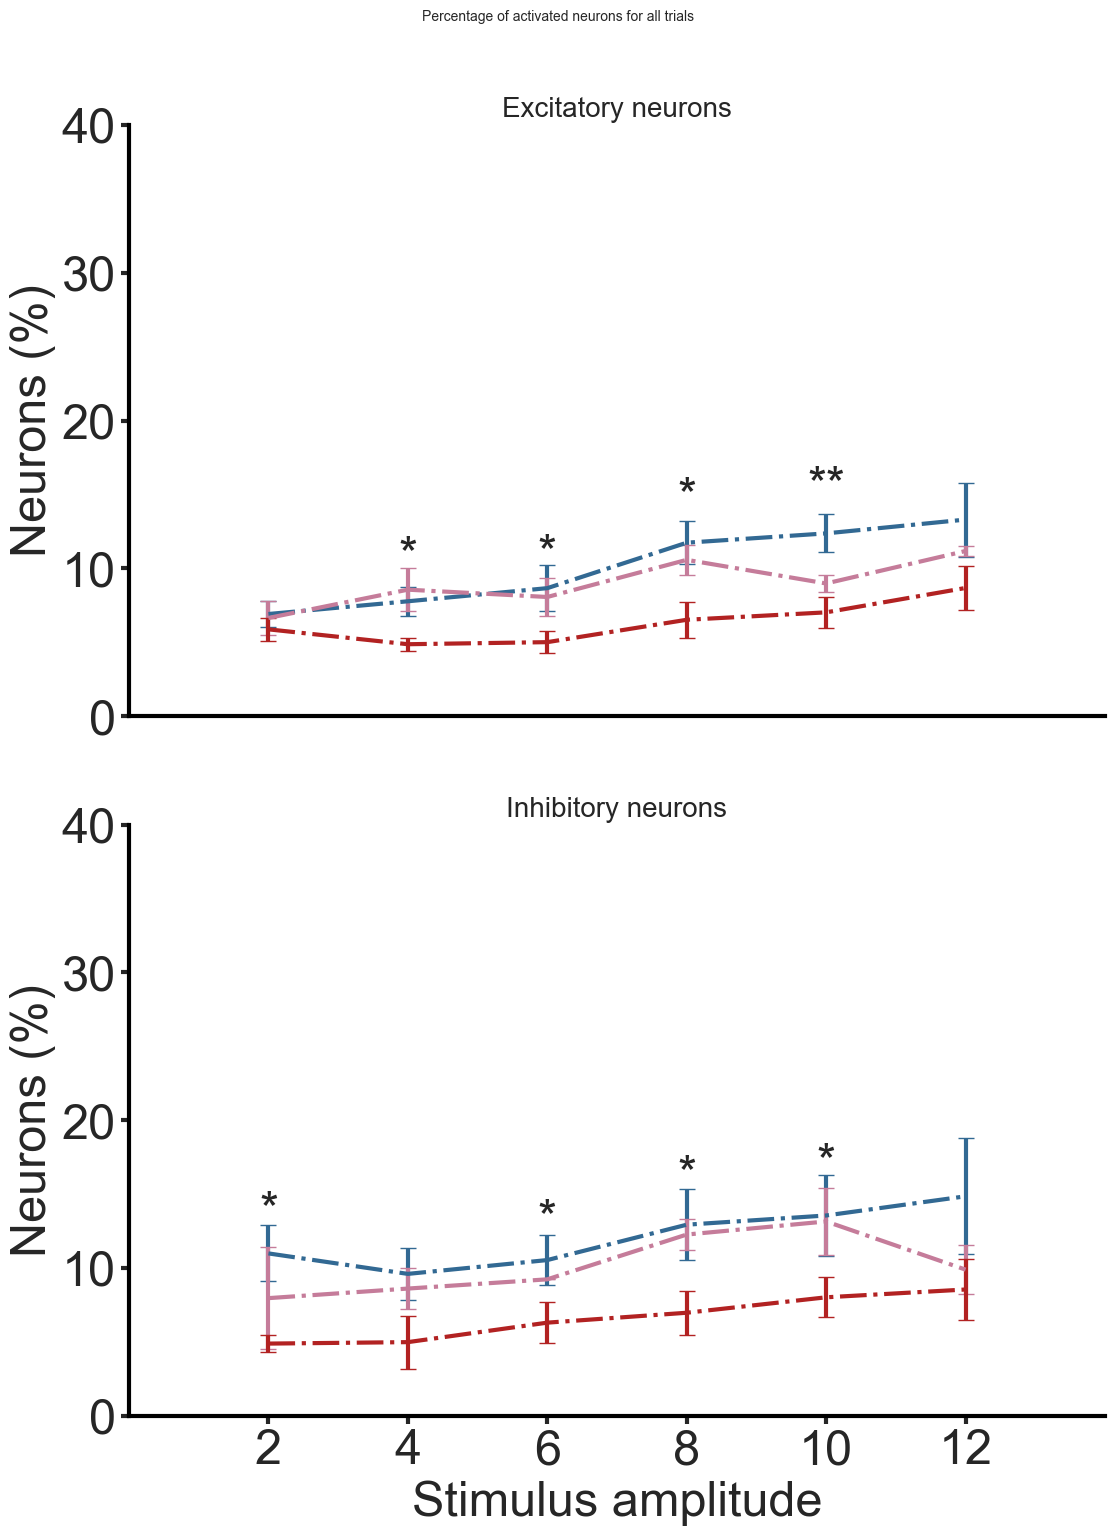

In [20]:
plot_neuron_perc_amp(recs, pattern="activated", detected_trials=True, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "*", "*", "*", "**", "n.s"], ["*", "n.s", "*", "*", "*", "n.s"]])

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percep

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source            SS    DF1    DF2      MS      F    p-unc    np2      eps
-----------  -------  -----  -----  ------  -----  -------  -----  -------
Genotype      98.618      2      6  49.309  0.418    0.676  0.122  nan
Amplitude    159.599      5     30  31.920  2.674    0.041  0.308    0.611
Interaction   62.221     10     30   6.222  0.521    0.861  0.148  nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  -------------  -------  -------  --------
Amplitude             -             2.000   4.000  True      True            2.490  8.000  two-sided        0.038    2.269     0.967
Amplitude             -             2.000   6.000  True      True     

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / dof)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\parametric.py:257: RuntimeWarning: Degrees of freedom <= 0 for slice
  vx, vy = x.var(ddof=1), y.var(ddof=1)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= 

                            OLS Regression Results                            
Dep. Variable:                Neurons   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     2.798
Date:                Fri, 05 Jul 2024   Prob (F-statistic):             0.0306
Time:                        14:55:31   Log-Likelihood:                -280.03
No. Observations:                  95   AIC:                             570.1
Df Residuals:                      90   BIC:                             582.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.9558      4

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\parametric.py:257: RuntimeWarning: Degrees of freedom <= 0 for slice
  vx, vy = x.var(ddof=1), y.var(ddof=1)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  -------------  -------  -------  --------
Amplitude             -             2.000   4.000  True      True            1.049  8.000  two-sided        0.325    0.500     0.452
Amplitude             -             2.000   6.000  True      True            0.611  8.000  two-sided        0.558    0.376     0.262
Amplitude             -             2.000   8.000  True      True           -0.136  8.000  two-sided        0.895    0.324    -0.039
Amplitude             -             2.000  10.000  True      True           -0.810  8.000  two-sided        0.441    0.421    -0.185
Amplitude             -             2.000  12.000  True      True           -0.420  8.000  two-sided        0.685    0.347    -0.107
Amplitude             -             4.000   6.000  T

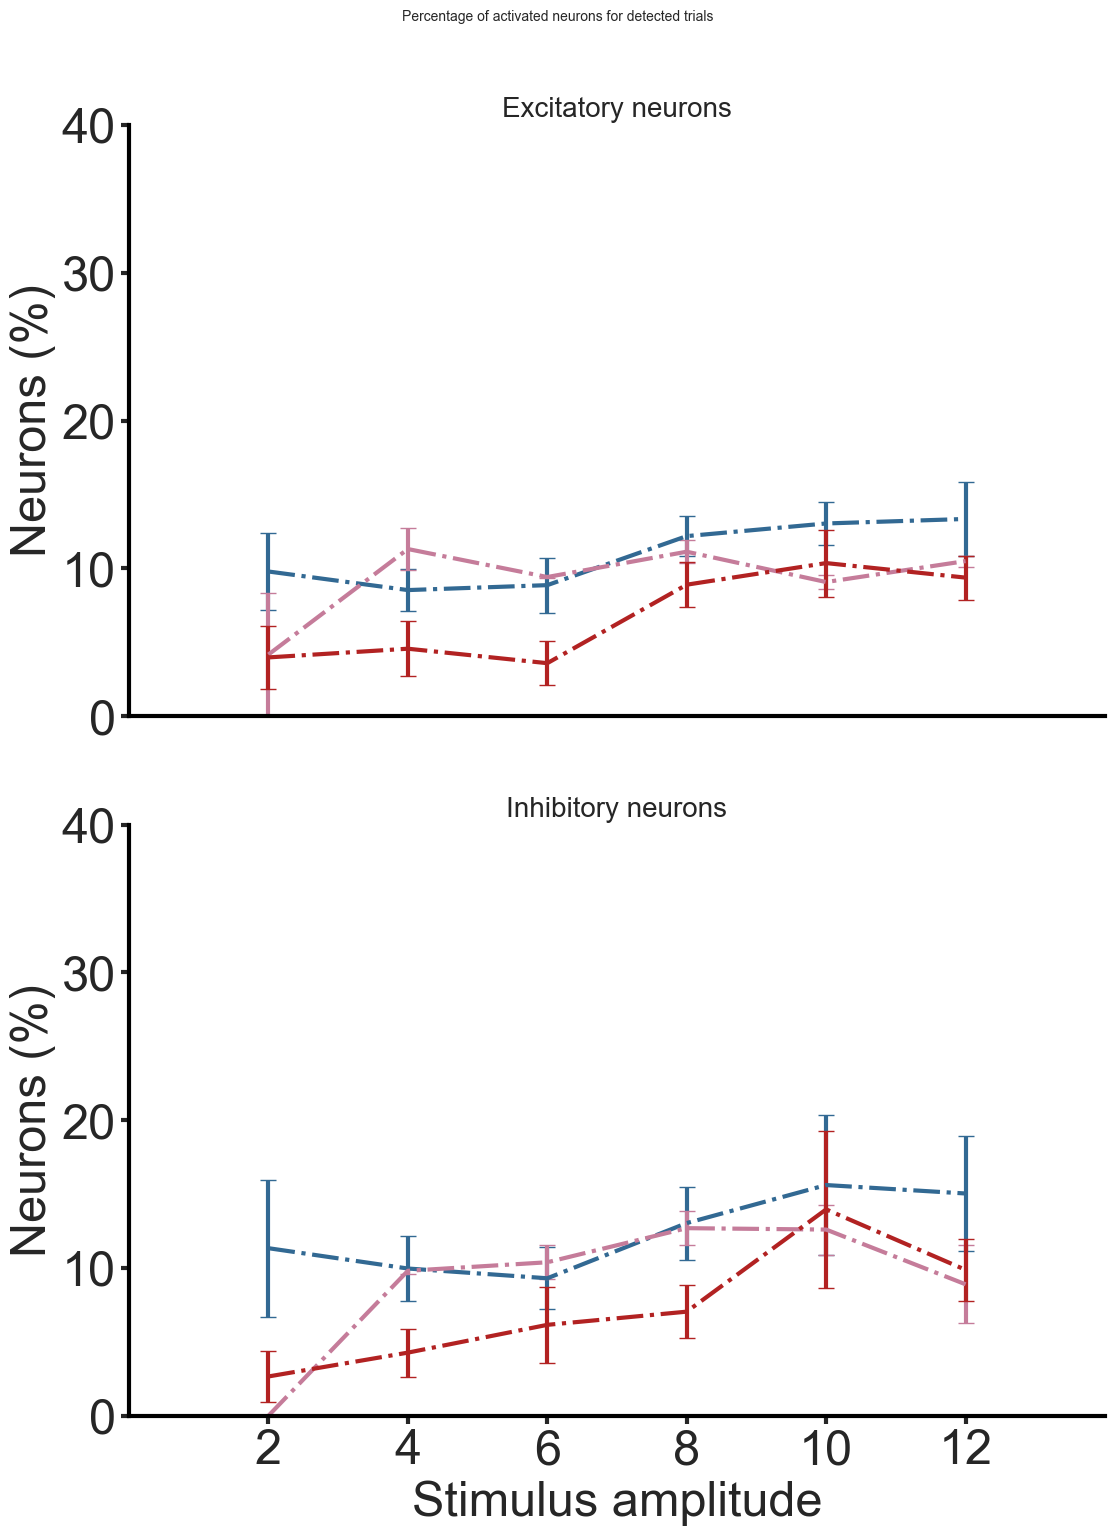

In [21]:
plot_neuron_perc_amp(recs, pattern="activated", detected_trials=True, undetected_trials=False, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percep

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source           SS    DF1    DF2      MS      F    p-unc    np2      eps
-----------  ------  -----  -----  ------  -----  -------  -----  -------
Genotype     59.212      1      5  59.212  4.104    0.099  0.451  nan
Amplitude    30.358      5     25   6.072  2.668    0.046  0.348    0.389
Interaction  91.224      5     25  18.245  8.017    0.000  0.616  nan



C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\parametric.py:257: RuntimeWarning: Degrees of freedom <= 0 for slice
  vx, vy = x.var(ddof=1), y.var(ddof=1)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  -------------  -------  -------  --------
Amplitude             -             2.000   4.000  True      True            0.761  6.000  two-sided        0.476    0.446     0.281
Amplitude             -             2.000   6.000  True      True            0.083  6.000  two-sided        0.937    0.354     0.036
Amplitude             -             2.000   8.000  True      True           -0.891  6.000  two-sided        0.407    0.484    -0.460
Amplitude             -             2.000  10.000  True      True           -0.962  6.000  two-sided        0.373    0.508    -0.530
Amplitude             -             2.000  12.000  True      True           -1.321  6.000  two-sided        0.235    0.672    -0.648
Amplitude             -             4.000   6.000  T

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)



 Normality of the residuals -> pvalue: 3.9481921361849034e-13 



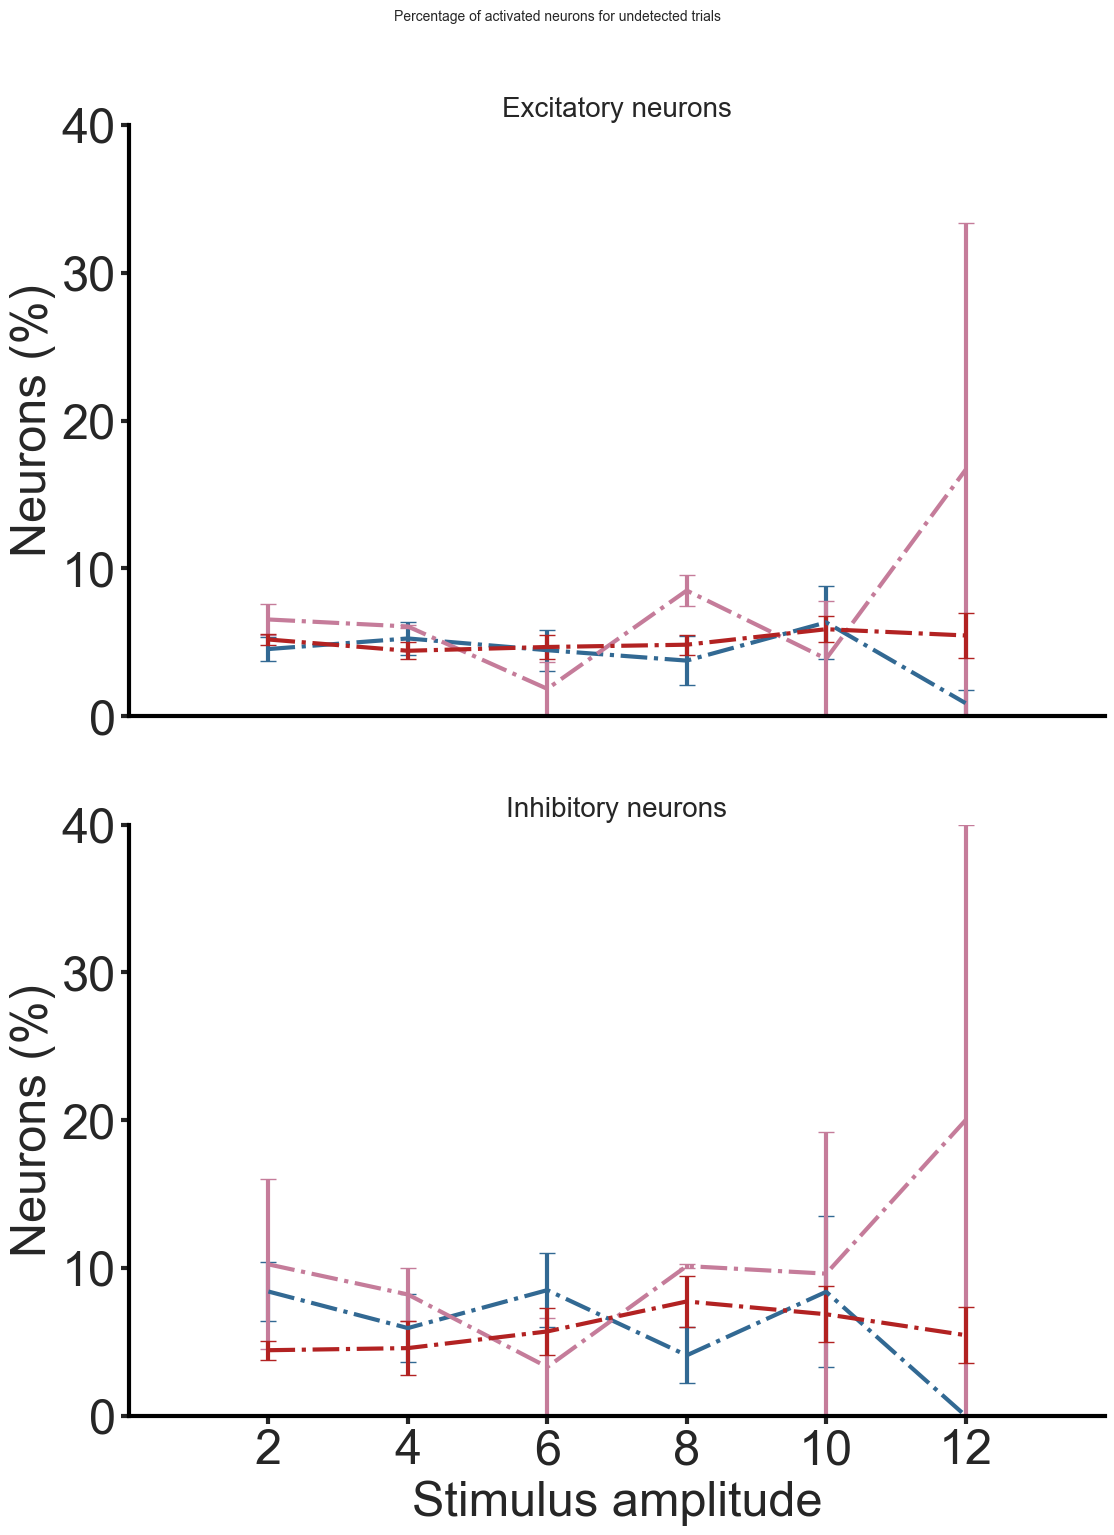

In [22]:
plot_neuron_perc_amp(recs, pattern="activated", detected_trials=False, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

## Graph of recruited neurons per amplitude

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source            SS    DF1    DF2       MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  -------  -----  -----  -------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
Genotype     878.736      2     15  439.368   2.981    0.081      nan      0.284  nan           nan        nan        nan
Amplitude    549.529      5     75  109.906  11.833    0.000        0.000  0.441    0.620         0.000      0.149      0.012
Interaction  114.462     10     75   11.446   1.232    0.285      nan      0.141  nan           nan        nan        nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric         T     dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  ------

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)



ANOVA SUMMARY

Source             SS    DF1    DF2       MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  --------  -----  -----  -------  -----  -------  -----------  -----  -------  ------------  ---------  ---------
Genotype     1793.240      2     15  896.620  2.463    0.119      nan      0.247  nan           nan        nan        nan
Amplitude     696.853      5     75  139.371  8.520    0.000        0.000  0.362    0.560         0.000      0.038      0.000
Interaction   122.294     10     75   12.229  0.748    0.678      nan      0.091  nan           nan        nan        nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric         T     dof  alternative      p-unc    BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  ------  ------  -------------  -------  ------  --------
Amplitude             -             2.000   4.000  True      True          -0.48

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)


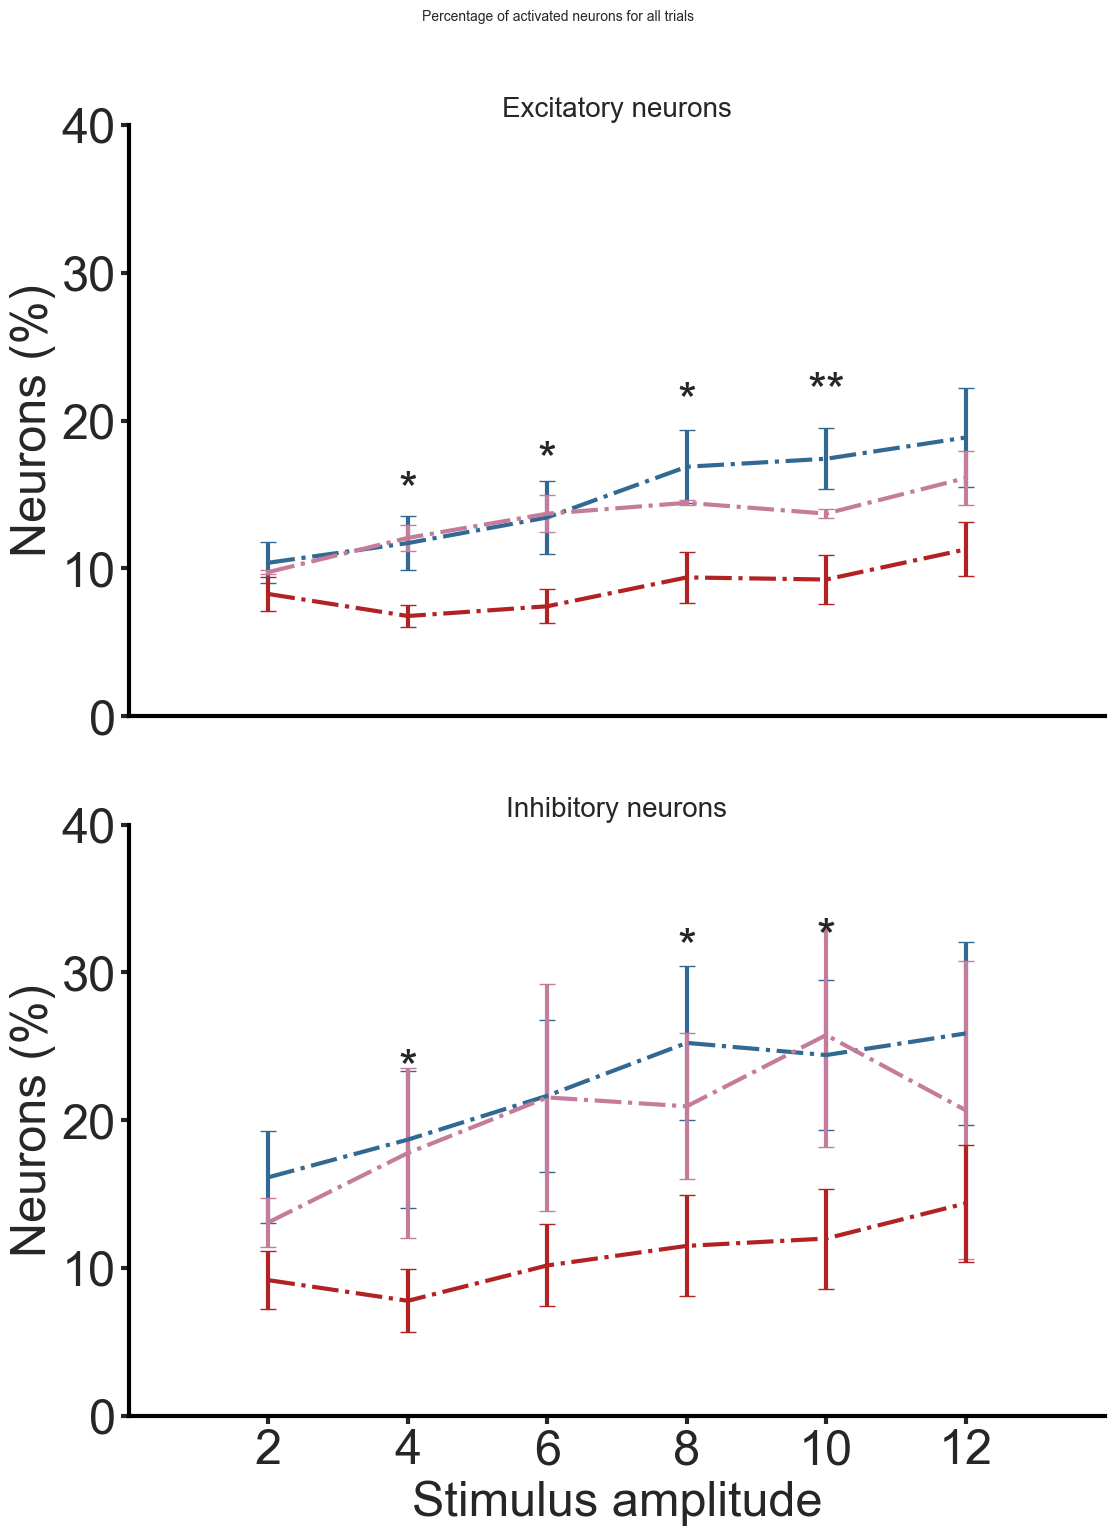

In [23]:
plot_neuron_perc_amp(recs, pattern="recruited", detected_trials=True, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "*", "*", "*", "**", "n.s"], 
                                                                                                                                       ["n.s", "*", "n.s", "*", "*", "n.s"]])

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percep

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source            SS    DF1    DF2      MS      F    p-unc    np2      eps
-----------  -------  -----  -----  ------  -----  -------  -----  -------
Genotype     116.697      2      6  58.349  0.412    0.680  0.121  nan
Amplitude    199.551      5     30  39.910  3.753    0.009  0.385    0.618
Interaction   47.629     10     30   4.763  0.448    0.910  0.130  nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  -------------  -------  -------  --------
Amplitude             -             2.000   4.000  True      True            2.602  8.000  two-sided        0.032    2.592     0.943
Amplitude             -             2.000   6.000  True      True     

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percep

                            OLS Regression Results                            
Dep. Variable:                Neurons   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     11.40
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           2.71e-08
Time:                        14:55:34   Log-Likelihood:                -717.99
No. Observations:                 190   AIC:                             1446.
Df Residuals:                     185   BIC:                             1462.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             43.3694      6

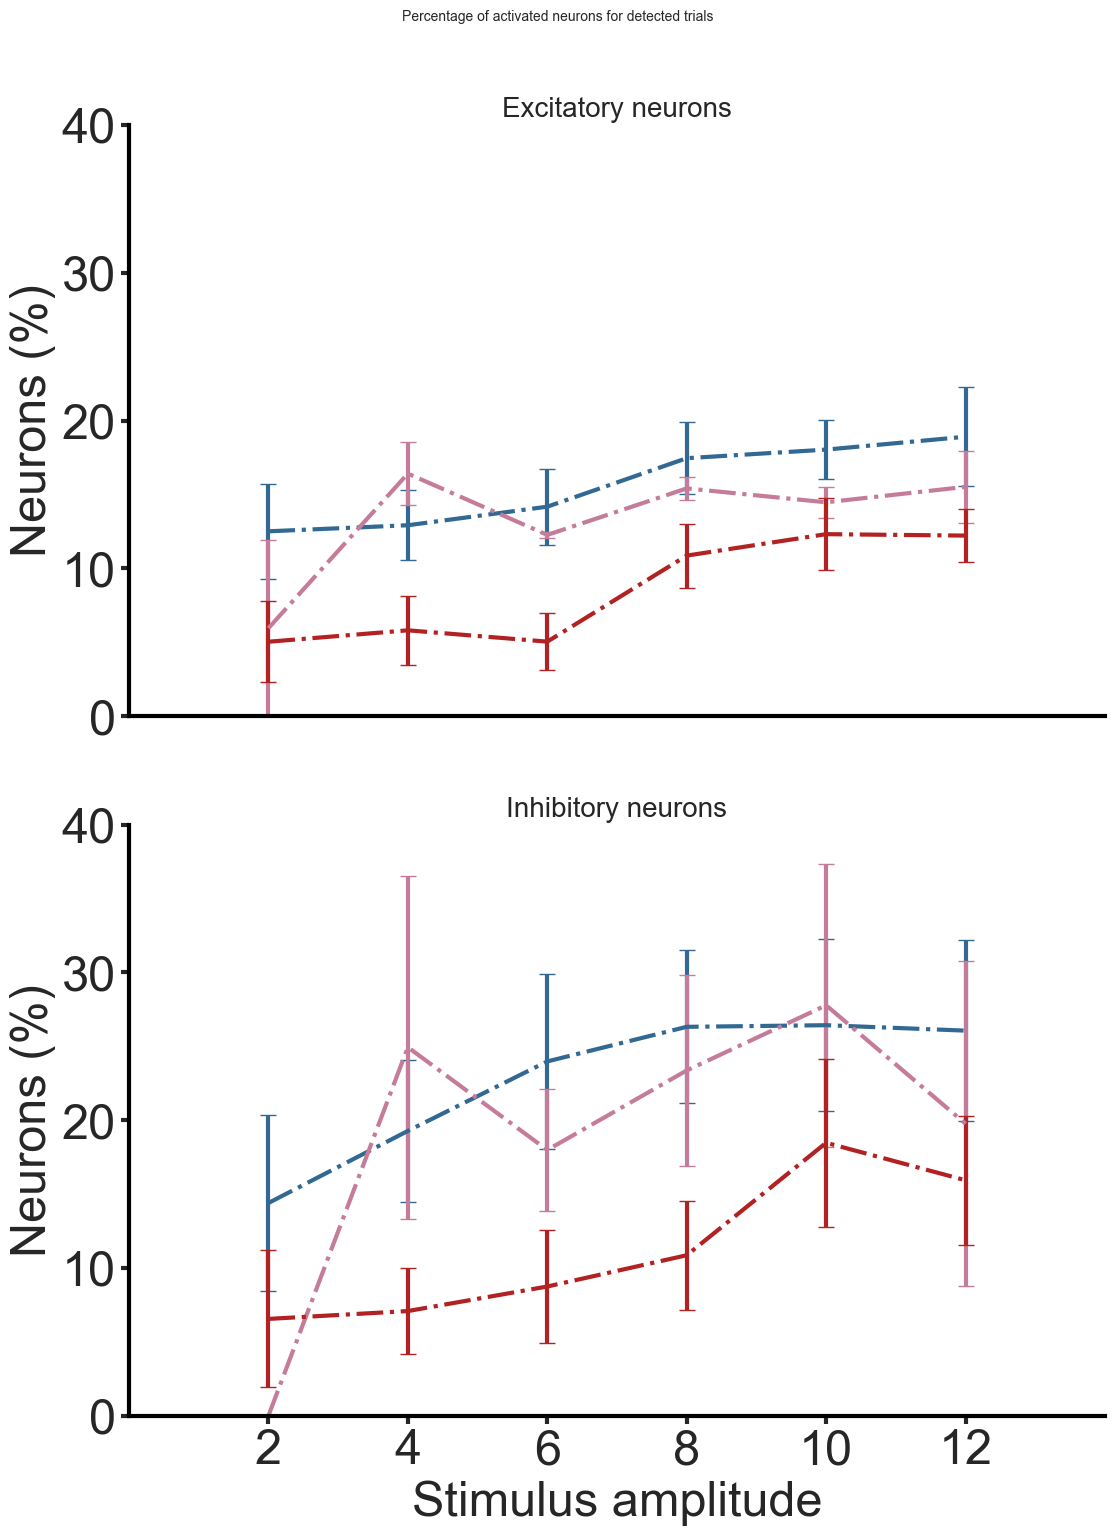

In [24]:
plot_neuron_perc_amp(recs, pattern="recruited", detected_trials=True, undetected_trials=False, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percep

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source           SS    DF1    DF2      MS      F    p-unc    np2      eps
-----------  ------  -----  -----  ------  -----  -------  -----  -------
Genotype     74.876      1      5  74.876  1.927    0.224  0.278  nan
Amplitude    26.689      5     25   5.338  1.497    0.226  0.230    0.491
Interaction  46.378      5     25   9.276  2.601    0.050  0.342  nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  -------------  -------  -------  --------
Amplitude             -             2.000   4.000  True      True            1.393  6.000  two-sided        0.213    0.716     0.364
Amplitude             -             2.000   6.000  True      True          

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\parametric.py:257: RuntimeWarning: Degrees of freedom <= 0 for slice
  vx, vy = x.var(ddof=1), y.var(ddof=1)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((

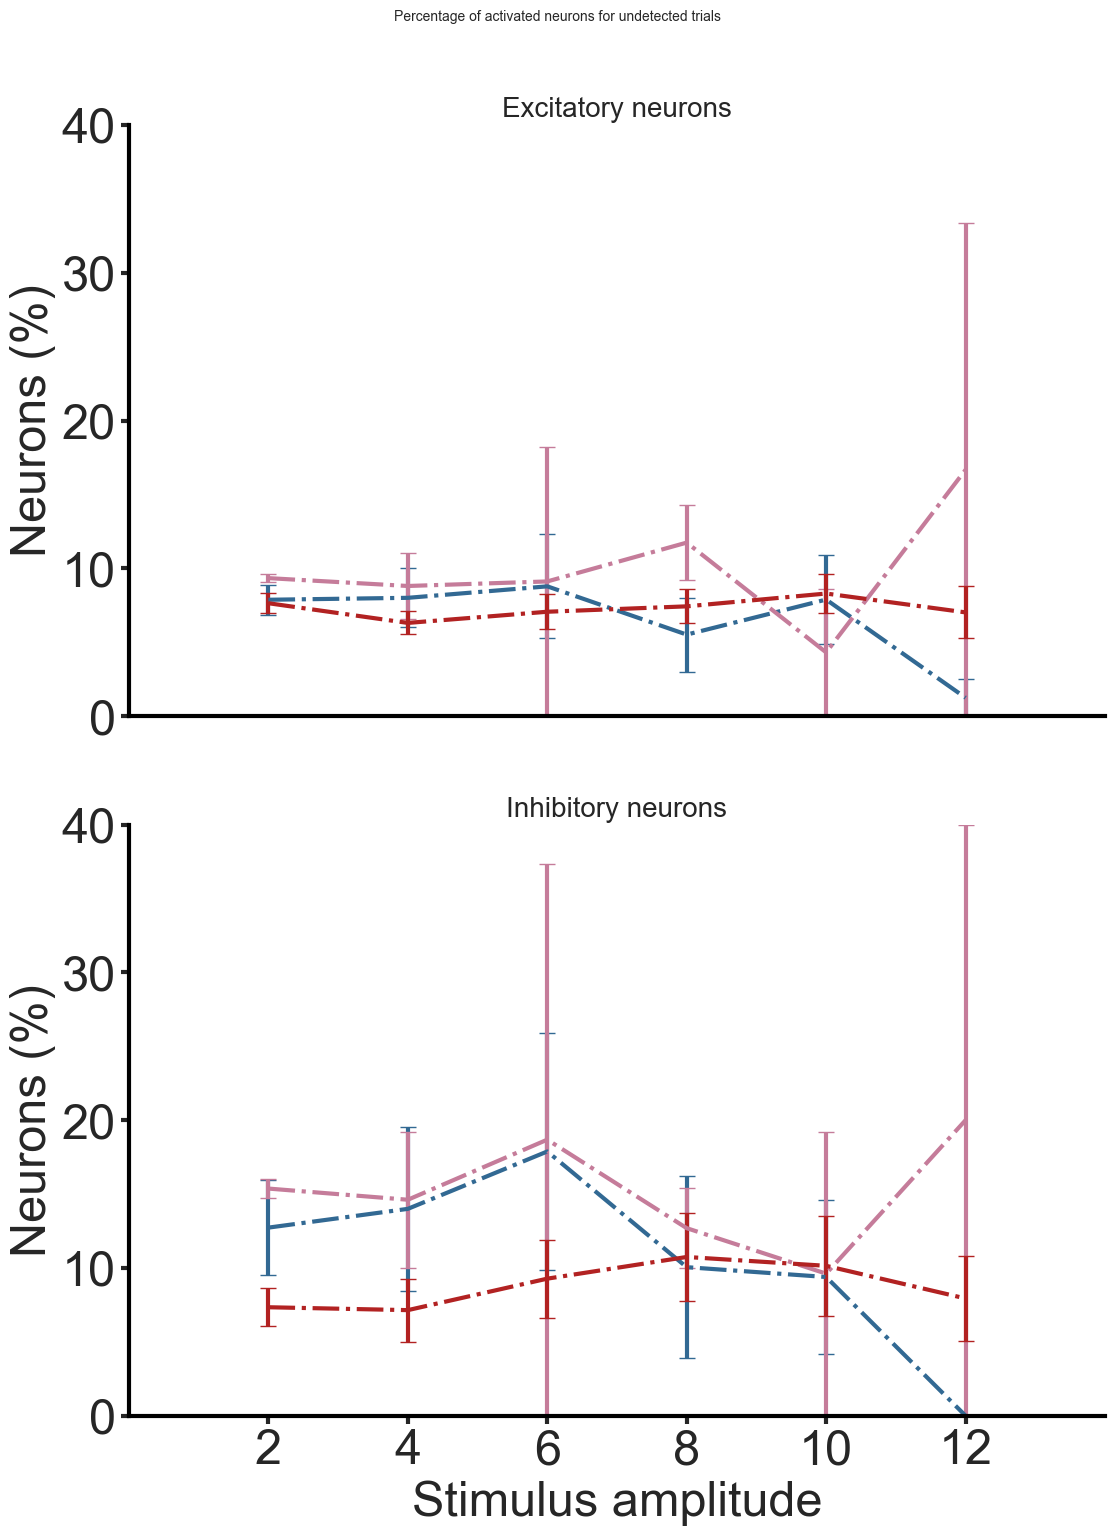

In [25]:
plot_neuron_perc_amp(recs, pattern="recruited", detected_trials=False, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

## Graph of inhibited neurons per amplitude

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source            SS    DF1    DF2      MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  -------  -----  -----  ------  -----  -------  -----------  -----  -------  ------------  ---------  ---------
Genotype     123.938      2     15  61.969  0.987    0.396      nan      0.116  nan           nan        nan        nan
Amplitude     27.332      5     75   5.466  1.717    0.141        0.179  0.103    0.361         0.000      0.019      0.000
Interaction   13.830     10     75   1.383  0.434    0.925      nan      0.055  nan           nan        nan        nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric         T     dof  alternative      p-unc    BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  ------  ------  -

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)



ANOVA SUMMARY

Source            SS    DF1    DF2       MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  -------  -----  -----  -------  -----  -------  -----------  -----  -------  ------------  ---------  ---------
Genotype     397.798      2     15  198.899  0.972    0.401      nan      0.115  nan           nan        nan        nan
Amplitude    105.600      5     75   21.120  2.611    0.031        0.081  0.148    0.410         0.000      0.043      0.000
Interaction   62.102     10     75    6.210  0.768    0.659      nan      0.093  nan           nan        nan        nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric         T     dof  alternative      p-unc    BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  ------  ------  -------------  -------  ------  --------
Amplitude             -             2.000   4.000  True      True          -0.961  17

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)


                            OLS Regression Results                            
Dep. Variable:                Neurons   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     16.13
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           1.53e-11
Time:                        14:55:35   Log-Likelihood:                -704.44
No. Observations:                 216   AIC:                             1419.
Df Residuals:                     211   BIC:                             1436.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             26.0907      3

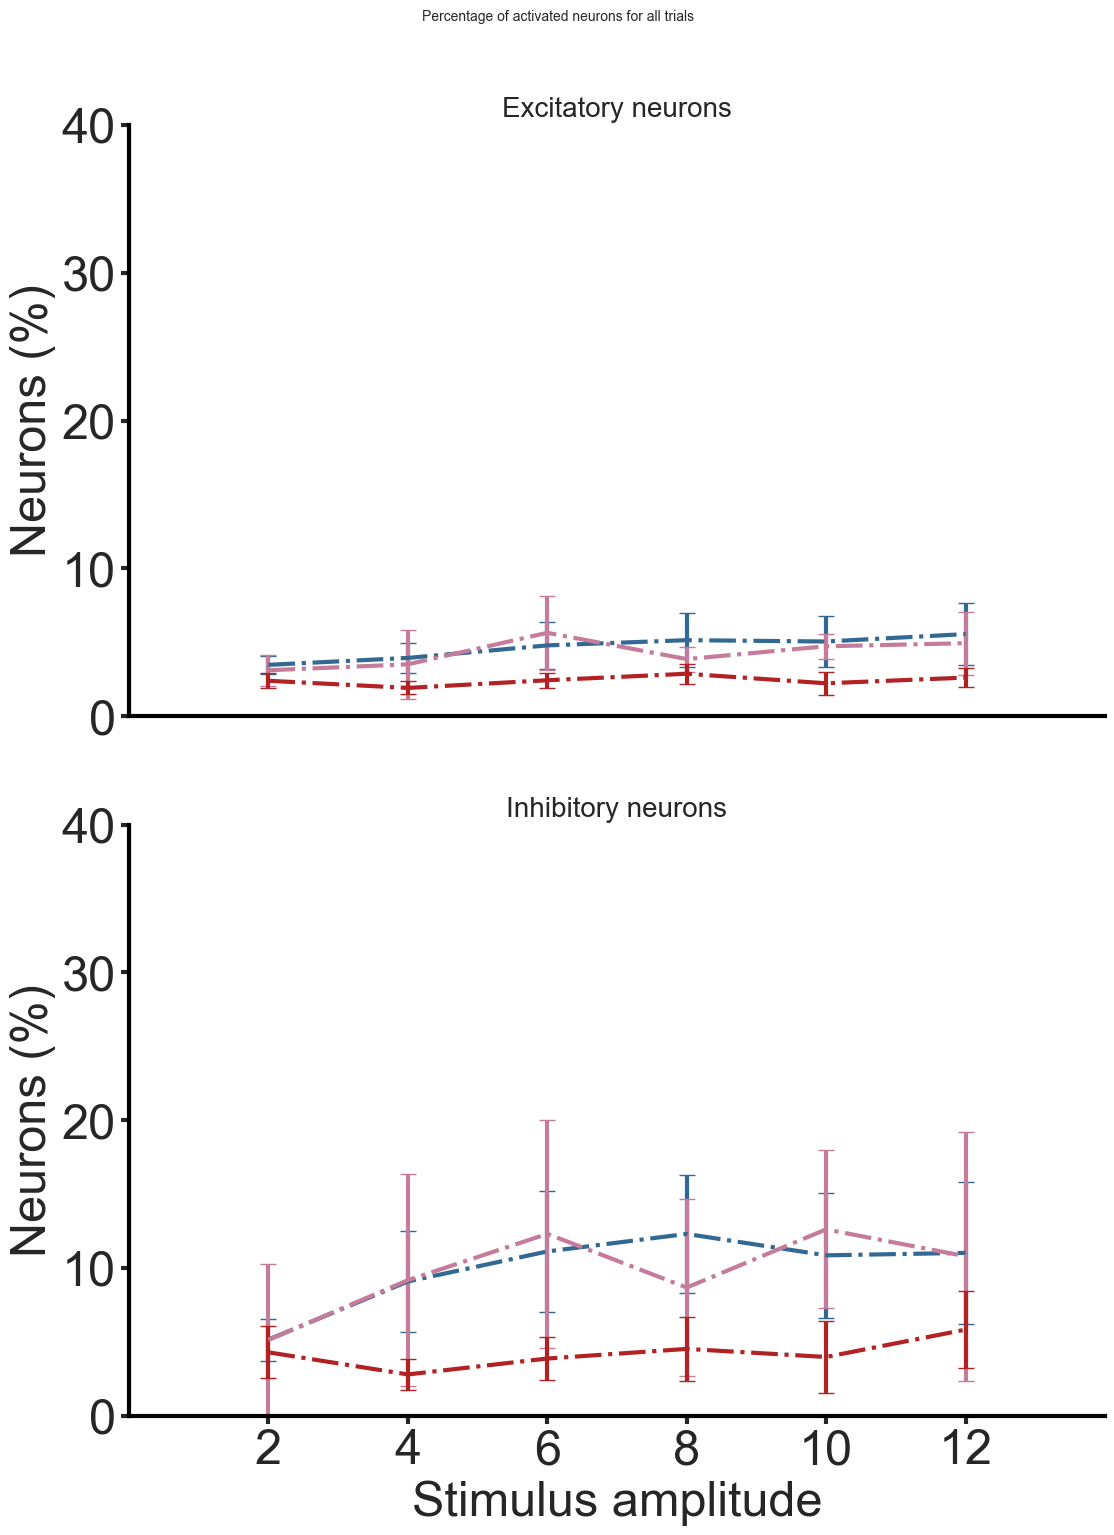

In [26]:
plot_neuron_perc_amp(recs, pattern="inhibited", detected_trials=True, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percep

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
Genotype     1.848      2      6  0.924  0.116    0.892  0.037  nan
Amplitude    5.136      5     30  1.027  0.513    0.764  0.079    0.698
Interaction  9.017     10     30  0.902  0.450    0.908  0.131  nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  -------------  -------  -------  --------
Amplitude             -             2.000   4.000  True      True            0.724  8.000  two-sided        0.490    0.400     0.328
Amplitude             -             2.000   6.000  True      True            0.214  8

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percep


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  -------------  -------  -------  --------
Amplitude             -             2.000   4.000  True      True            0.325  8.000  two-sided        0.753    0.336     0.124
Amplitude             -             2.000   6.000  True      True           -0.809  8.000  two-sided        0.442    0.421    -0.351
Amplitude             -             2.000   8.000  True      True           -1.068  8.000  two-sided        0.317    0.508    -0.338
Amplitude             -             2.000  10.000  True      True           -0.472  8.000  two-sided        0.650    0.353    -0.181
Amplitude             -             2.000  12.000  True      True           -0.772  8.000  two-sided        0.462    0.411    -0.270
Amplitude             -             4.000   6.000  T

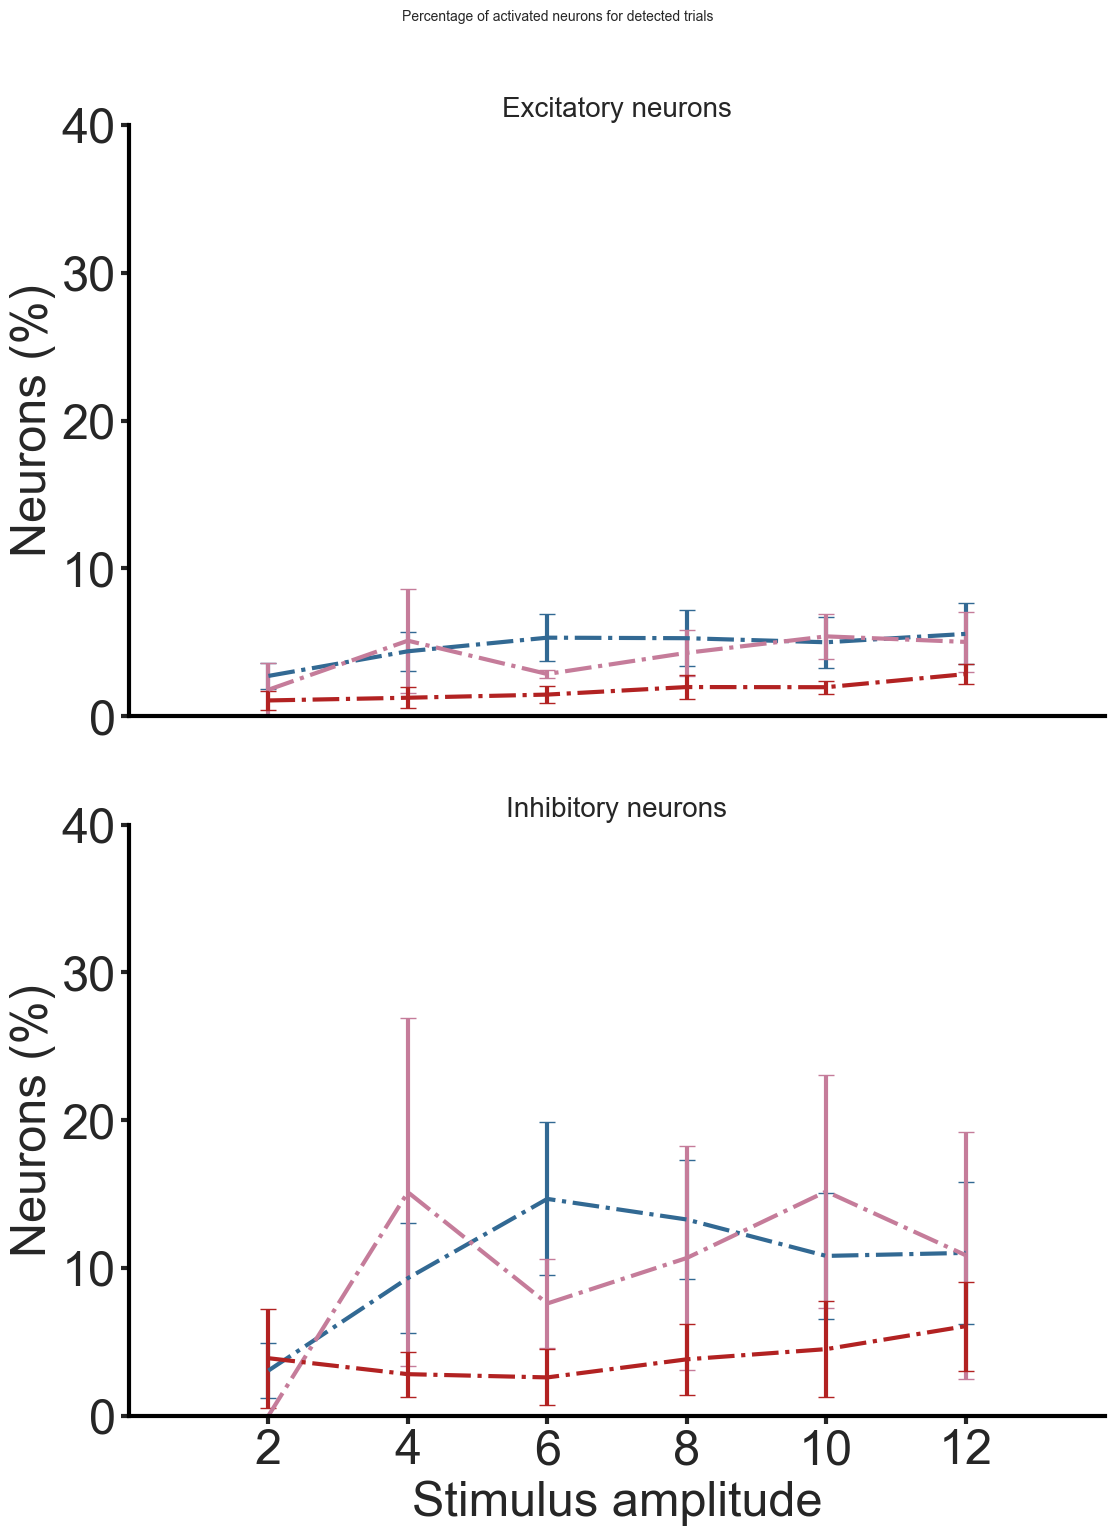

In [27]:
plot_neuron_perc_amp(recs, pattern="inhibited", detected_trials=True, undetected_trials=False, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percep

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source           SS    DF1    DF2     MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  ------  -----  -----  -----  -----  -------  -----------  -----  -------  ------------  ---------  ---------
Genotype      0.918      1      5  0.918  0.100    0.764      nan      0.020  nan           nan        nan        nan
Amplitude     2.470      5     25  0.494  0.234    0.944        0.798  0.045    0.407         0.000      0.000      0.000
Interaction  10.463      5     25  2.093  0.992    0.442      nan      0.166  nan           nan        nan        nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  ----------

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\parametric.py:257: RuntimeWarning: Degrees of freedom <= 0 for slice
  vx, vy = x.var(ddof=1), y.var(ddof=1)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((

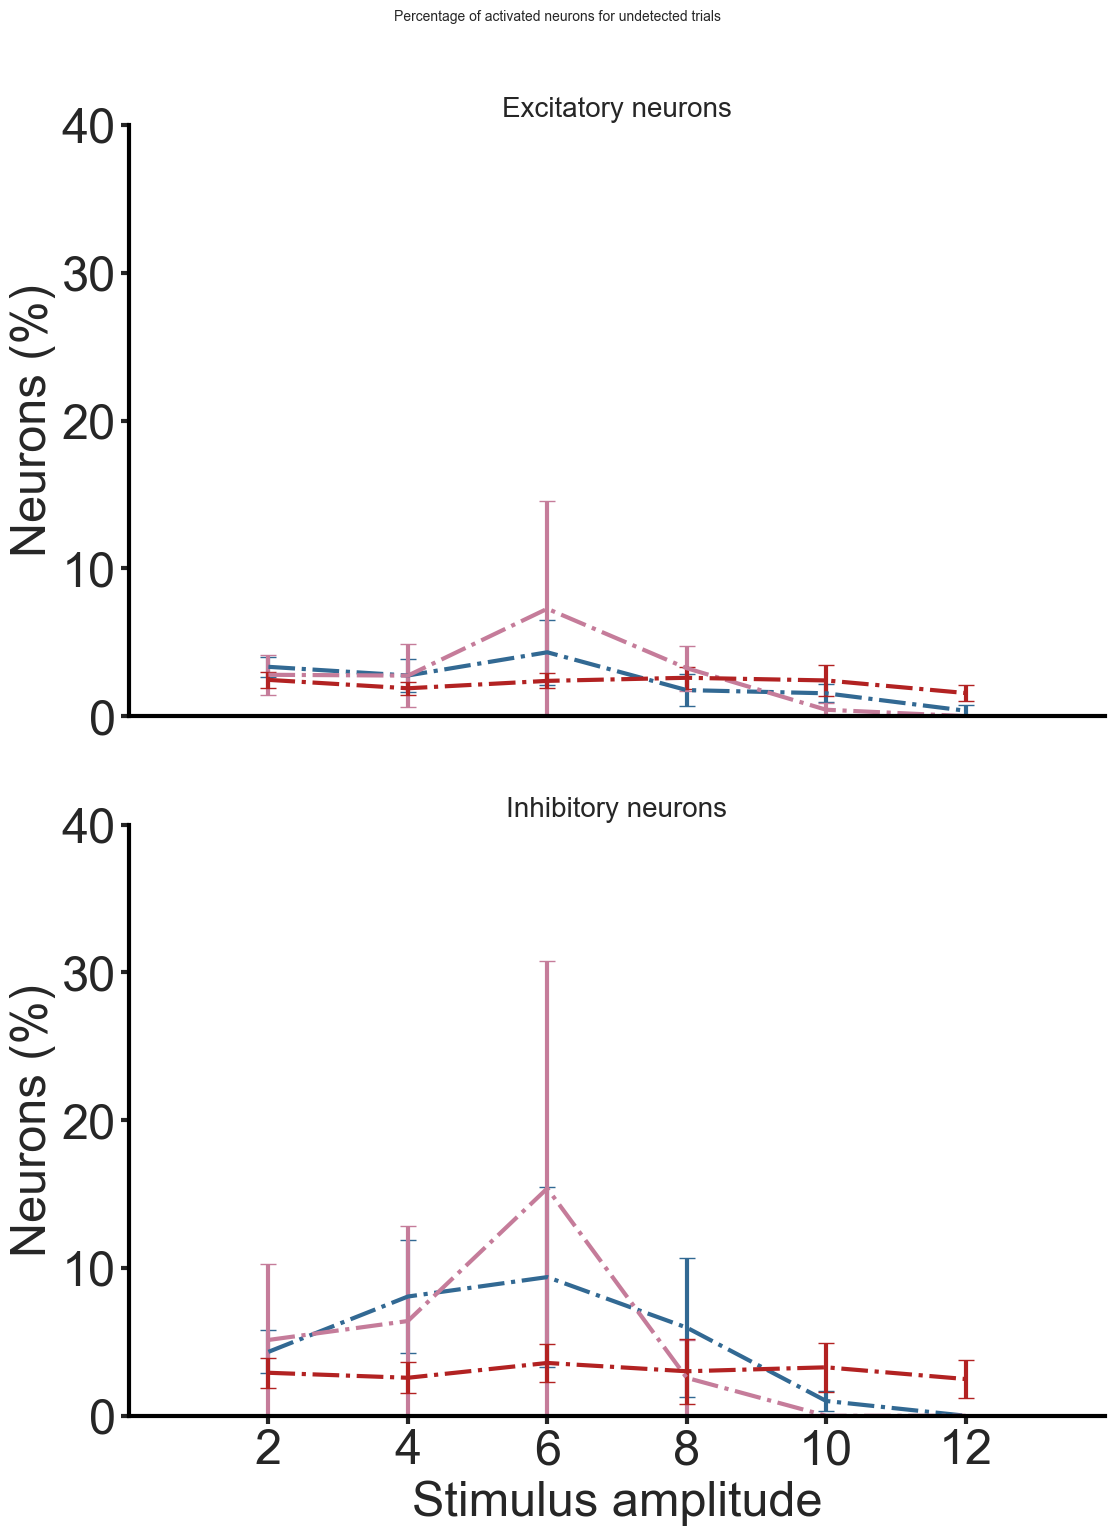

In [28]:
plot_neuron_perc_amp(recs, pattern="inhibited", detected_trials=False, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

## Graph of amplitude response from each stimulus amplitude


C:\Users\cvandromme\AppData\Local\Temp\ipykernel_24884\4152795581.py:15: RuntimeWarning: Mean of empty slice
  output = np.nanmean(np.nanmean(trials, axis=1))


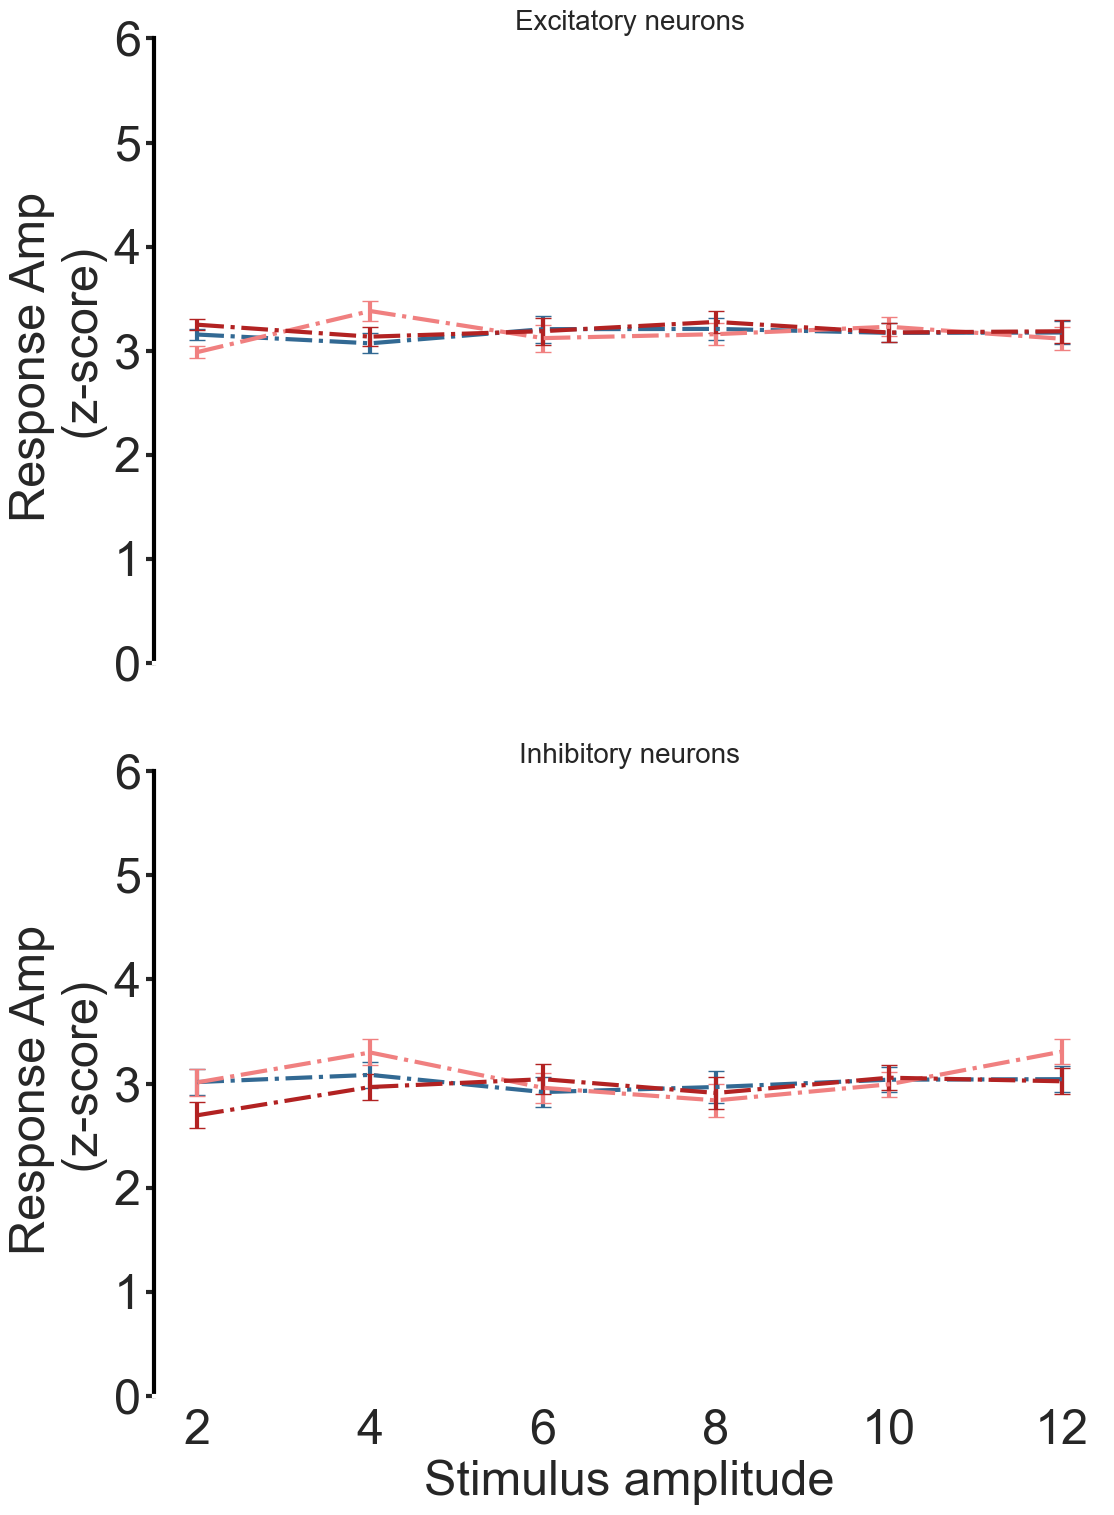

In [30]:
figs, axs = plt.subplots(2,1,figsize=(12,16))

amps=[2,4,6,8,10,12]
labels = {"EXC":"Excitatory neurons" , "INH": "Inhibitory neurons"}
for i,type in enumerate(["EXC","INH"]):
    wt,ko, ko_hypo = [],[],[]
    for rec in recs.values():
        rec.peak_delay_amp()
        mat = np.array(rec.matrices[type]["Peak_amplitude"])
        mat[mat<0]=np.nan

        _p=[]
        for amp in amps:
            trials = mat[:,rec.stim_ampl==amp]
            output = np.nanmean(np.nanmean(trials, axis=1))
            if np.isnan(output ):
                output = 0
            _p.append( output)
            
        if rec.genotype == "WT":
            wt.append(_p)

        elif rec.genotype =="KO-Hypo":
            ko_hypo.append(_p)
        elif rec.genotype =="KO":
            ko.append(_p)
        
    axs[i].errorbar(amps,np.mean(wt,axis=0),linestyle="-.",color="#326993",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].errorbar(amps,np.mean(ko,axis=0),linestyle="-.", color="lightcoral",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].errorbar(amps,np.mean(ko_hypo,axis=0),linestyle="-.", color="firebrick",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].grid(False)
    axs[i].set_facecolor("white")
    axs[i].spines["left"].set_color("black")
    axs[i].tick_params(axis='both', which='major', length=6, width=3, left=True)
    axs[i].set_ylabel("Response Amp \n (z-score)")
    axs[i].set_xlabel("Stimulus amplitude")
    axs[i].set_title(labels[type])
    axs[i].tick_params(axis='both')
    axs[i].set_xticks([2,4,6,8,10,12])
    axs[i].set_ylim([0,6])
    axs[i].spines[['right', 'top',]].set_visible(False)
axs[0].get_xaxis().set_visible(False)
figs.tight_layout()
if save_figure:
    figs.savefig(server_address + "Figure2/responsivity/resp_amp_linegraph.pdf")

# Psychometric curves like graphs for fraction of resp neurons

Number of active neurons and behavior psychometric curves comparison animal by animals

Text(0.5, 0.98, 'Percentage of neurons recruited for all trials amplitude')

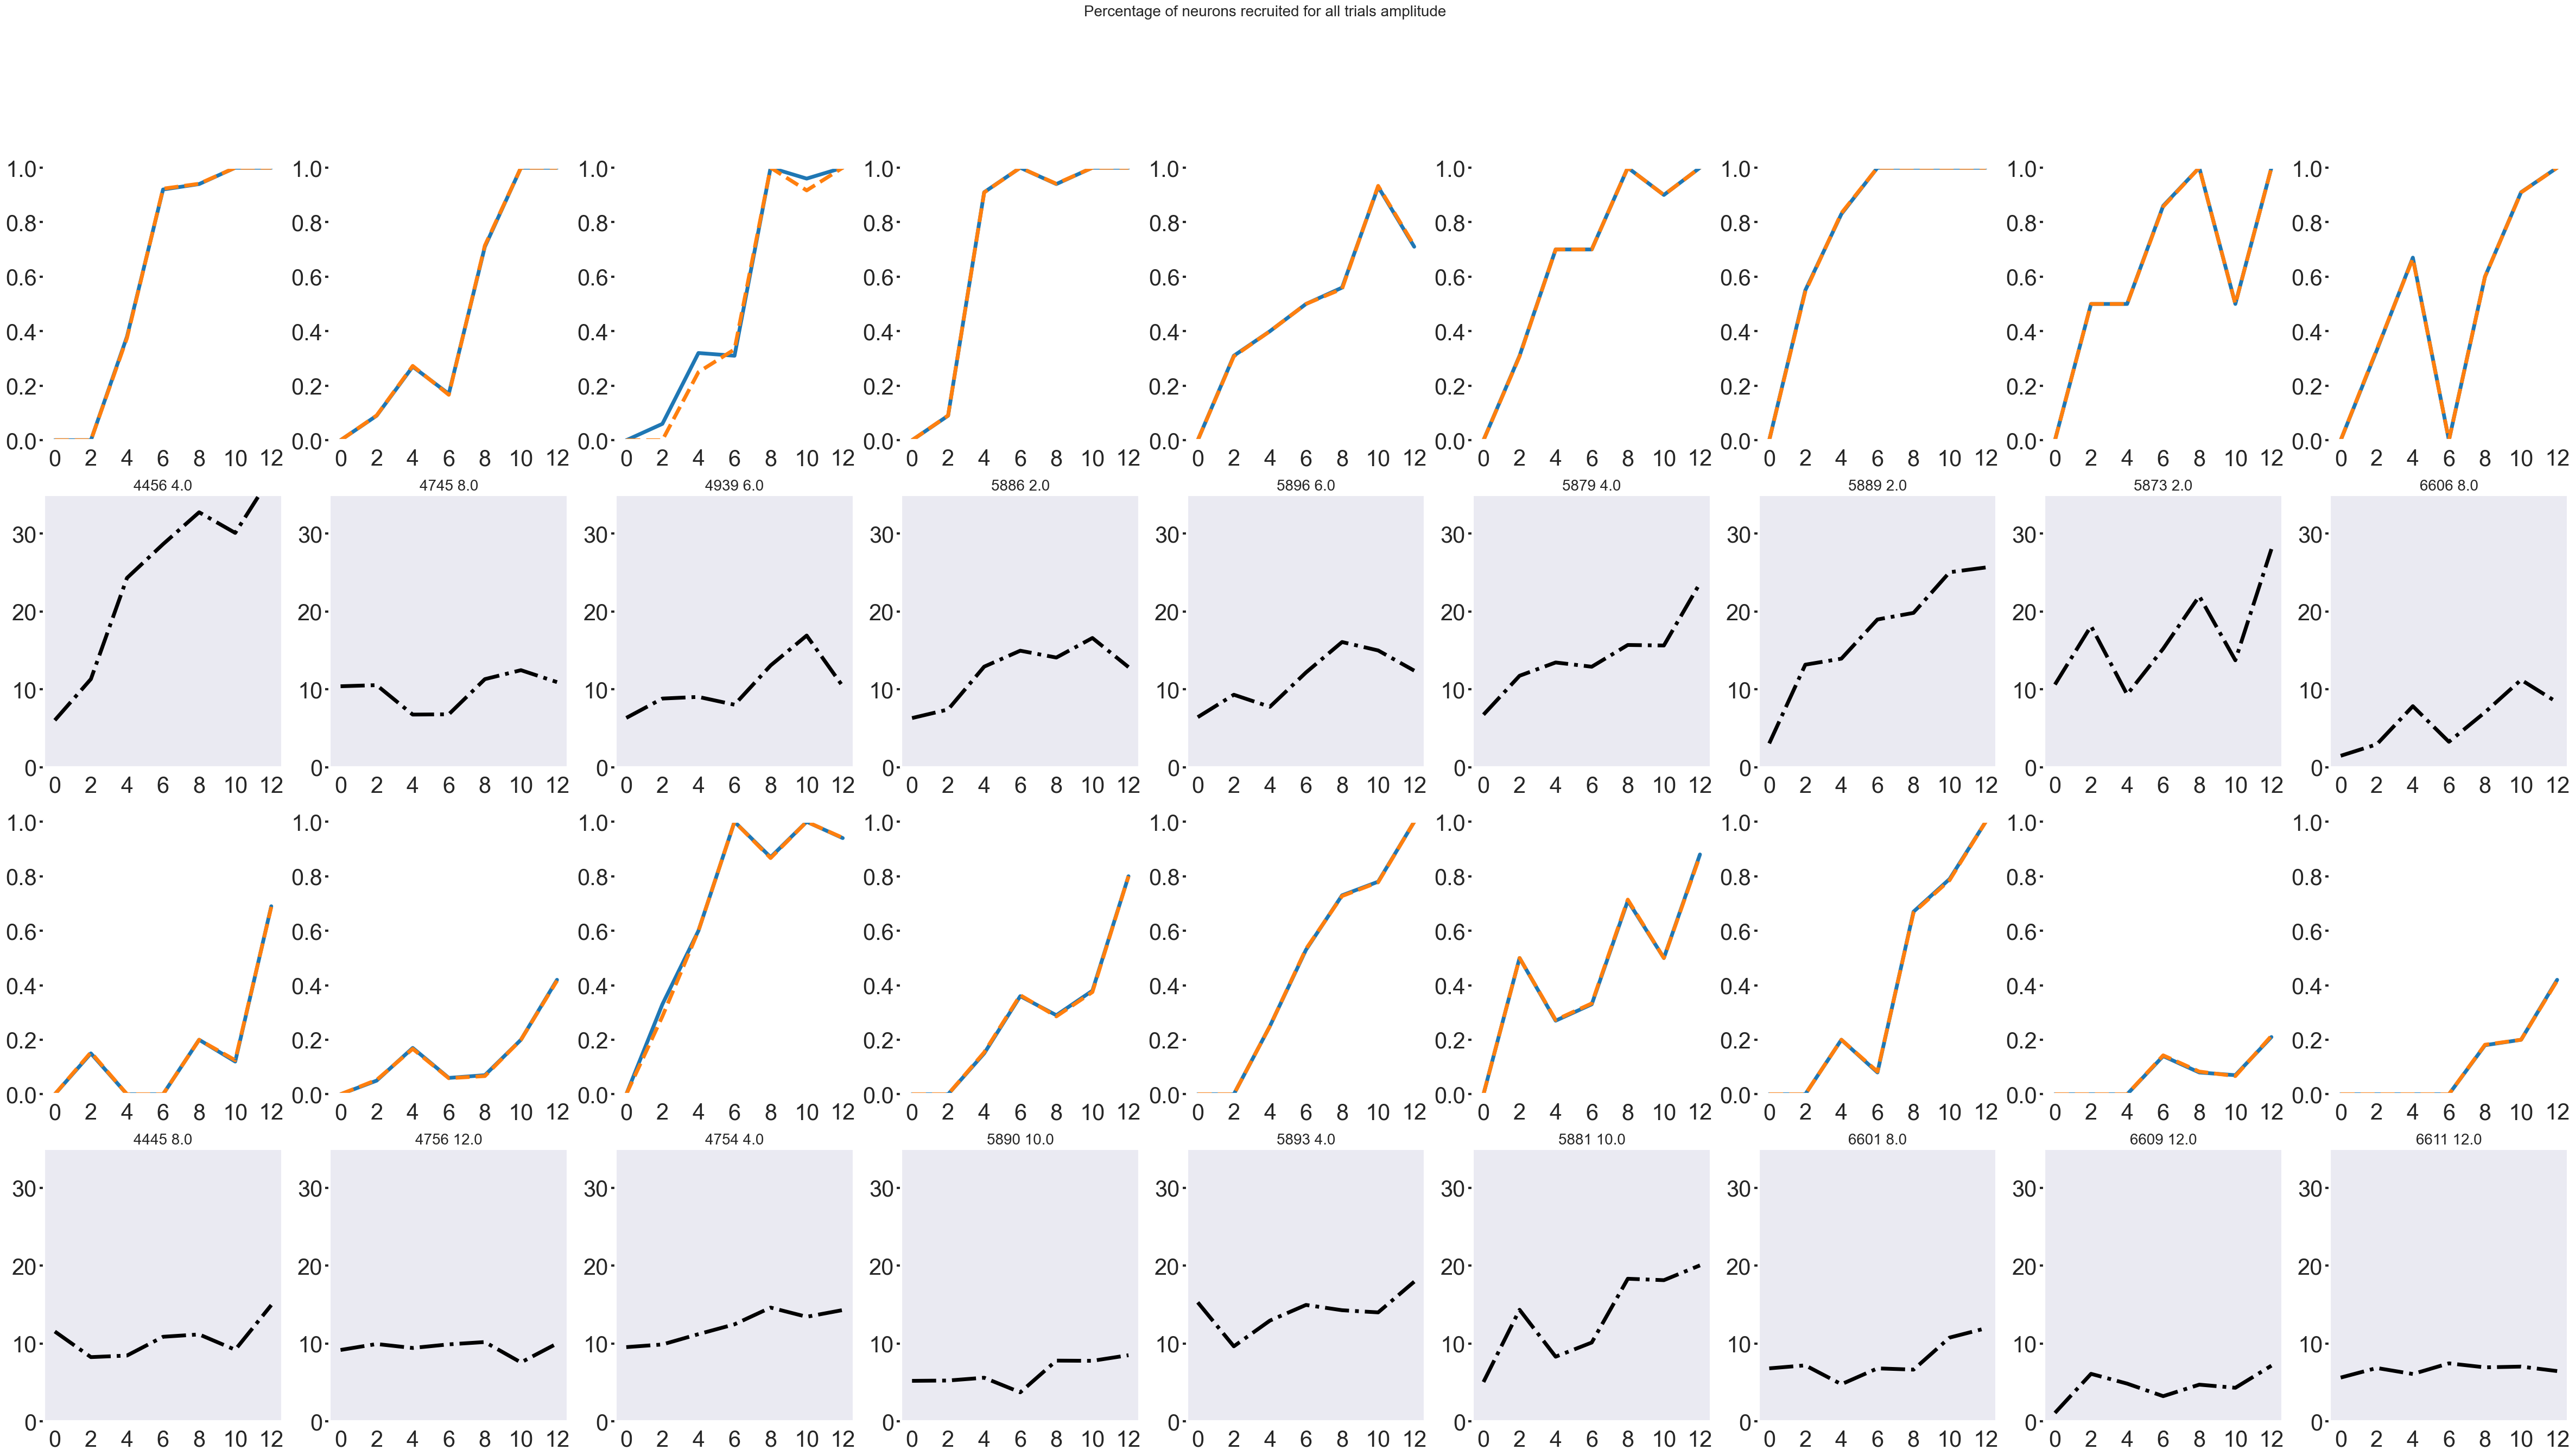

In [31]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 9, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 0] = 1
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, rec_.stim_ampl == amp]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    ax.set_title(title)
    ax.set_ylim([0,35])
for rec in recs.values():
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
# ax[2, 6].set_axis_off()
# ax[2, 7].set_axis_off()
# ax[3, 6].set_axis_off()
# ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for all trials amplitude', fontsize=20)

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'Percentage of neurons recruited for DETECTED TRIALS')

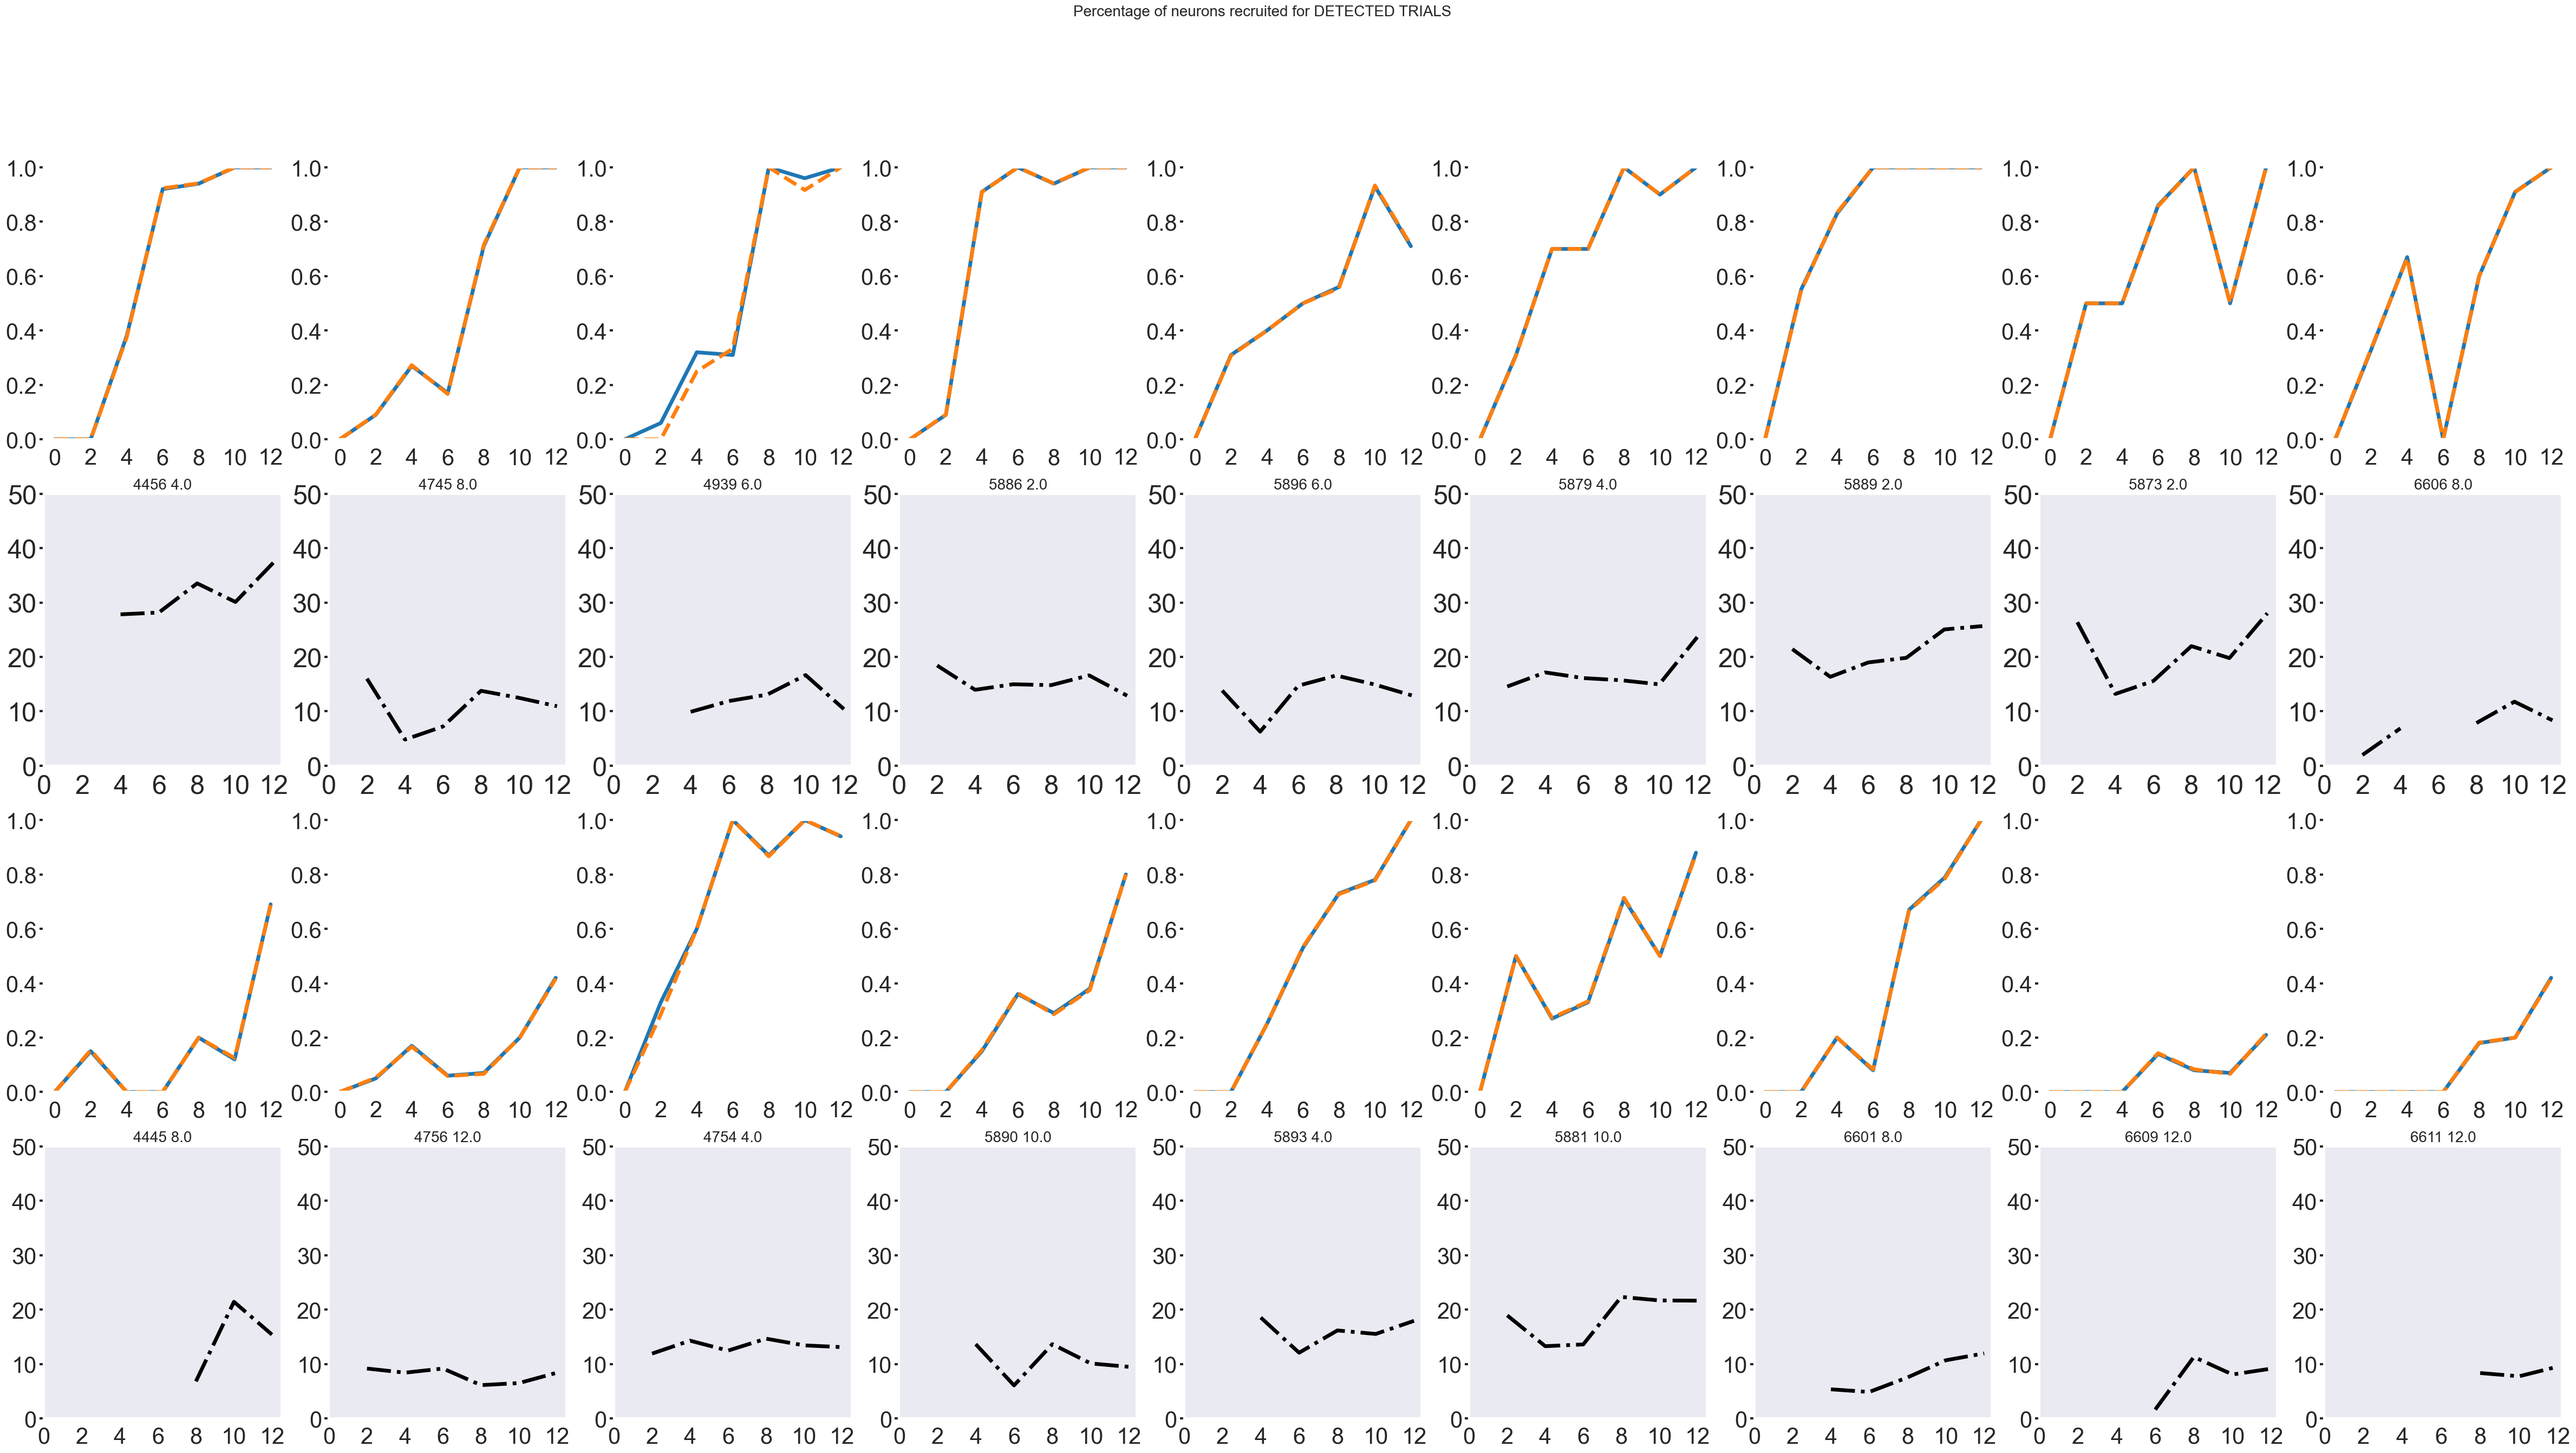

In [32]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 9, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 1] = 0
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    nb_trials= []
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, (rec_.stim_ampl == amp)&(rec_.detected_stim)]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
        nb_trials.append(len(rec.stim_ampl[rec.stim_ampl == amp]))
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    # ax.bar([0, 2, 4, 6, 8, 10, 12], nb_trials)
    ax.set_title(title)
    ax.set_ylim([0,50])
for rec in recs.values():
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
# ax[2, 6].set_axis_off()
# ax[2, 7].set_axis_off()
# ax[3, 6].set_axis_off()
# ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for DETECTED TRIALS', fontsize=20)

percentage of neurons recruited for UNDETECTED TRIALS

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889


C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5873
5881
6606
6601
6609
6611


Text(0.5, 0.98, 'Percentage of neurons recruited for UNDETECTED TRIALS')

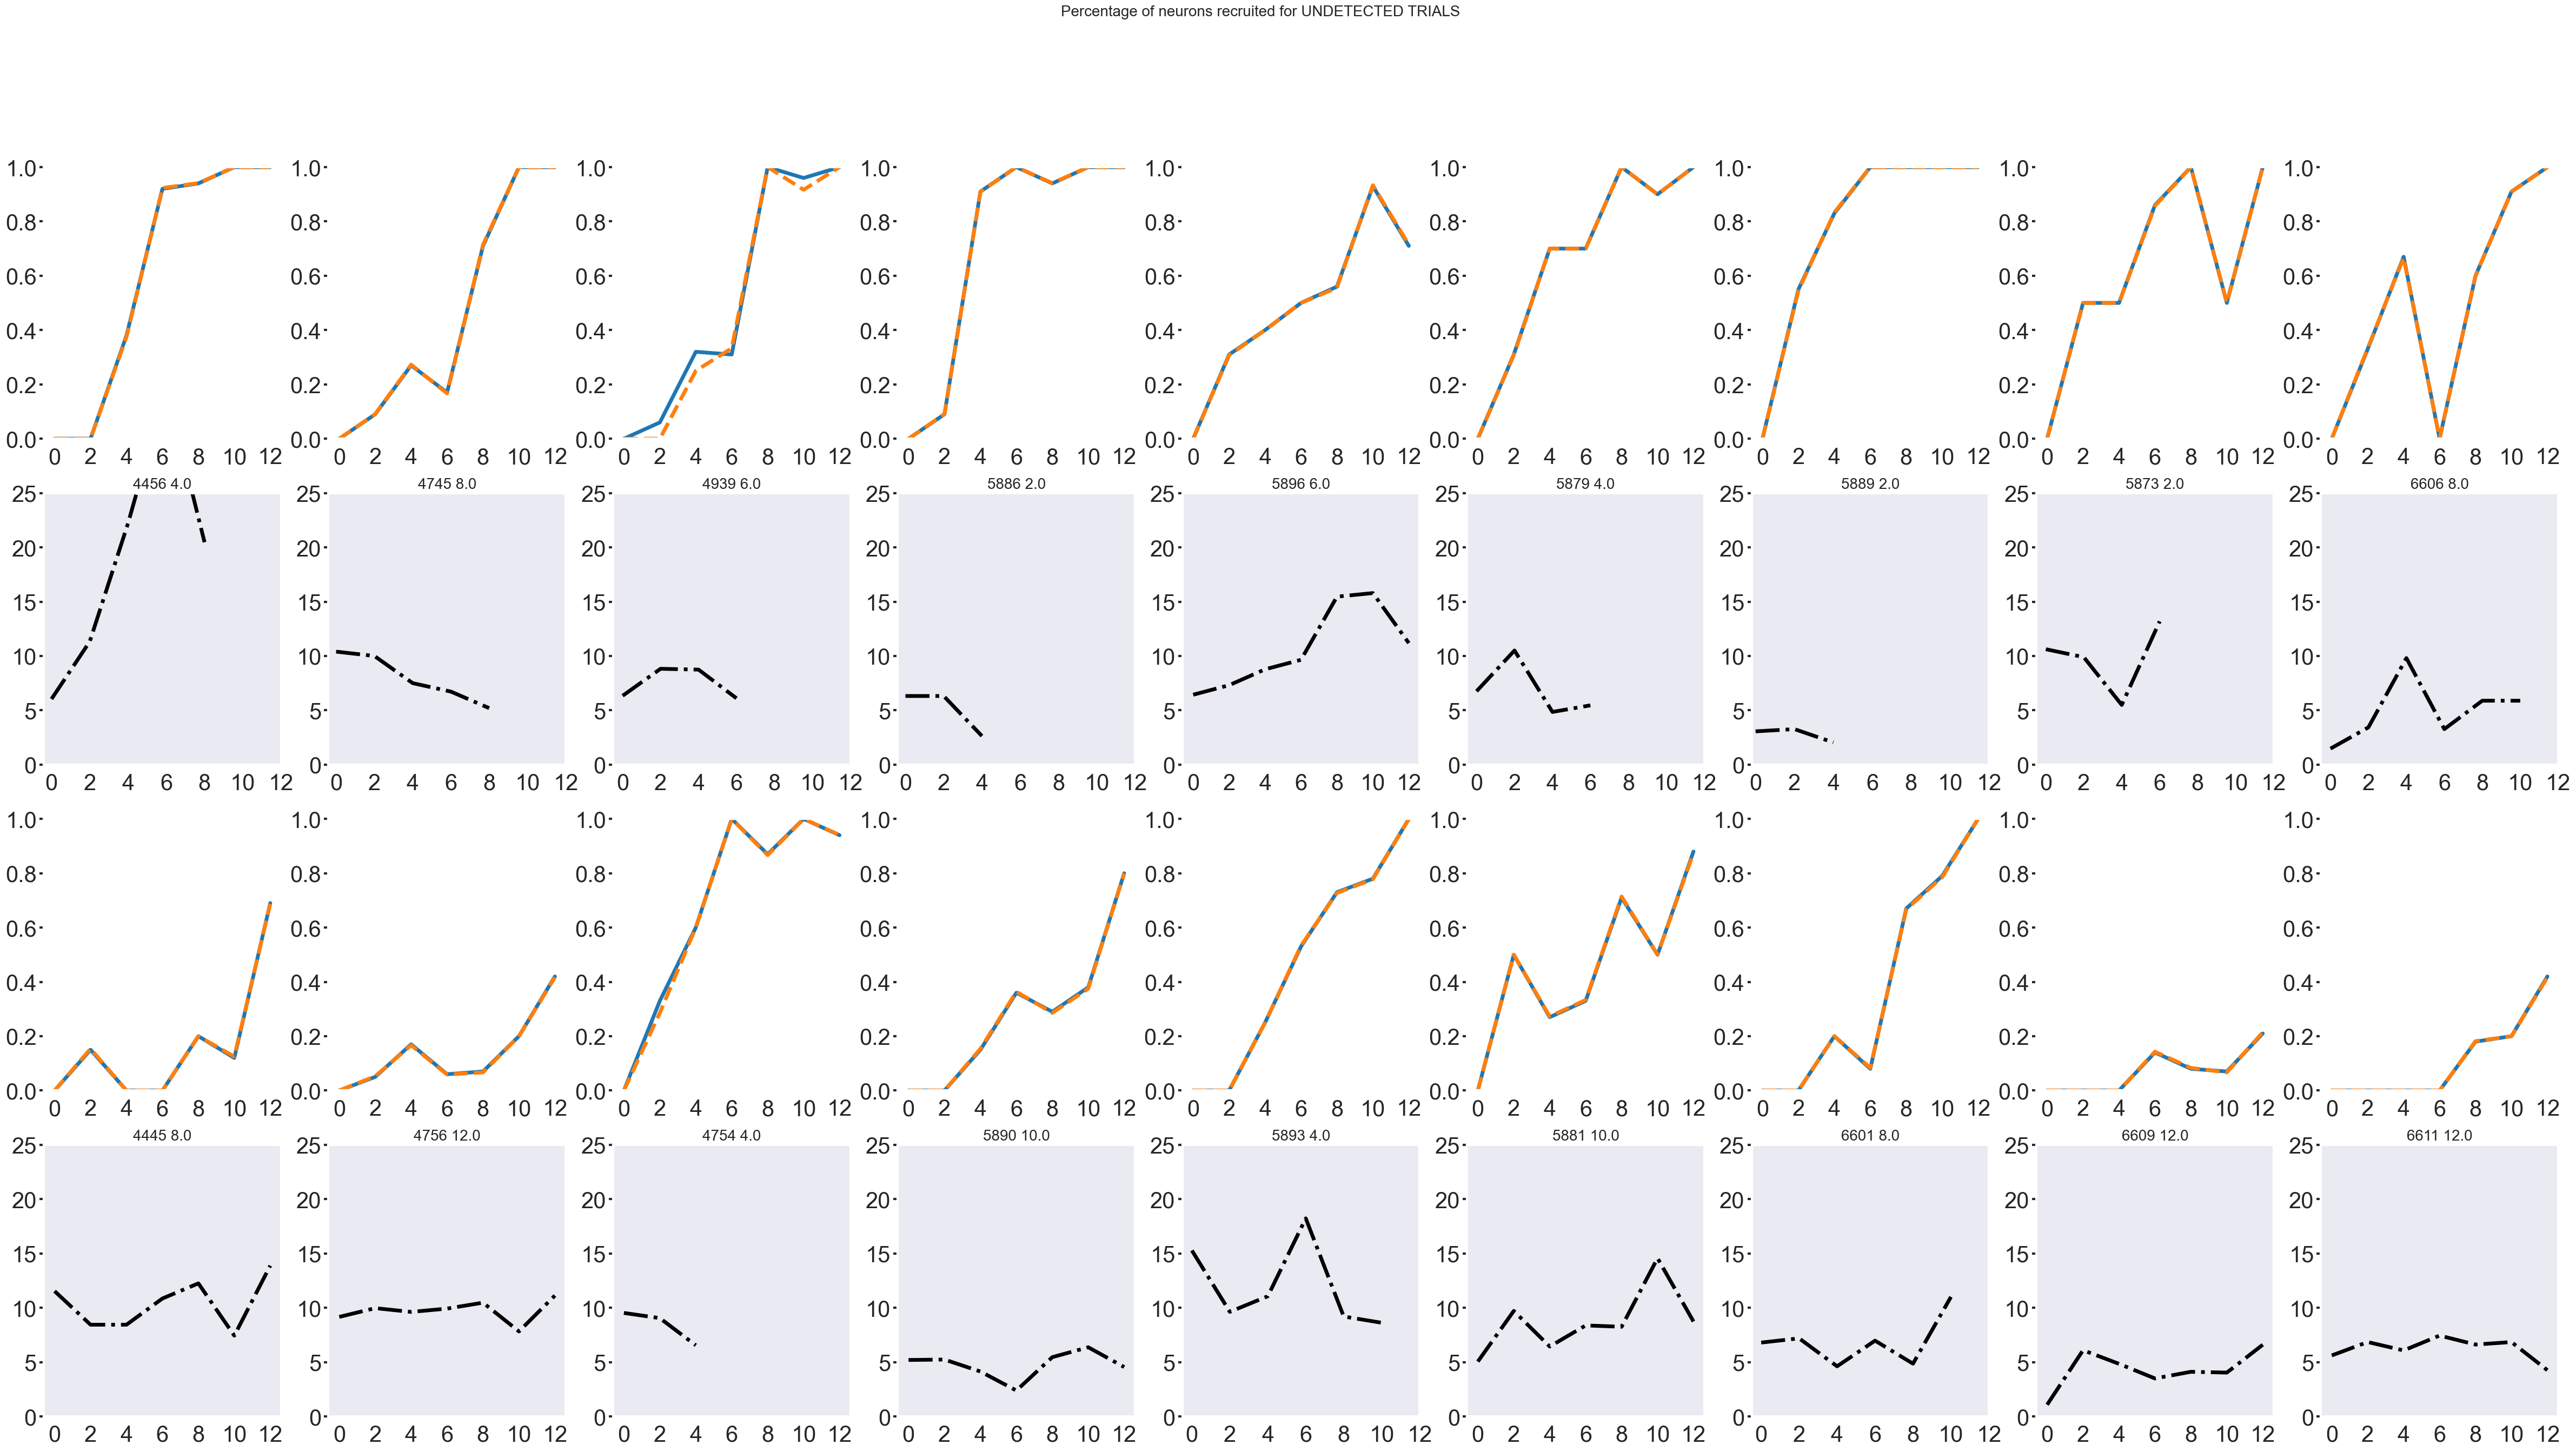

In [33]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 9, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 0] = 1
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, (rec_.stim_ampl == amp)&(~rec_.detected_stim)]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    ax.set_title(title)
    ax.set_ylim([0,25])
for rec in recs.values():
        print(rec.filename)
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])

            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
# ax[2, 6].set_axis_off()
# ax[2, 7].set_axis_off()
# ax[3, 6].set_axis_off()
# ax[3, 7].set_axis_off()

fig.suptitle('Percentage of neurons recruited for UNDETECTED TRIALS', fontsize=20)

# Signal-to-Noise ratio (nb of neurons due to stimulus vs nb of neurons bsl) 


In [34]:
def SNR( pattern, n_type, ko, stim_ampl="all"):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[n_type]["Responsivity"])
        ampl_filter = rec.stim_ampl_filter(stim_ampl=stim_ampl)
        ampl_det_filt = np.logical_and(rec.detected_stim, ampl_filter)
        ampl_undet_filt = np.logical_and(np.invert(rec.detected_stim), ampl_filter)
        #detected
        trials_detected = resp_mat[:,ampl_det_filt]
        trials_undetected = resp_mat[:,ampl_undet_filt]
        if pattern == 0:
            trials_detected[trials_detected!=0]=1
            trials_undetected[trials_undetected!=0]=1
        else:
            trials_detected[trials_detected!=pattern]=0
            trials_undetected[trials_undetected!=pattern]=0

        recruited_det = np.count_nonzero(trials_detected,axis=0)
        total_n = len(rec.zscore_exc)
        if  n_type== "INH":
            total_n = len(rec.zscore_inh)
        n_baseline = np.mean(np.count_nonzero(resp_mat[:,rec.stim_ampl==0],axis=0))
        # snr_det = (((np.mean(recruited_det)-n_baseline)/total_n)*100)  # option 1
        snr_det = np.mean(recruited_det)/n_baseline   # option 2
        #undetected
        recruited_undet = np.count_nonzero(trials_undetected,axis=0)
        # snr_undet =(((np.mean(recruited_undet)-n_baseline)/total_n)*100)  # option 1
        snr_undet = np.mean(recruited_undet)/n_baseline  # option 2

        if rec.genotype == "WT":
            wt_det.append(snr_det)
            wt_undet.append(snr_undet)
        elif rec.genotype =="KO-Hypo":
            ko_det.append(snr_det)
            ko_undet.append(snr_undet)
        elif rec.genotype == "KO" and ko =="KO":
            ko_det.append(snr_det)
            ko_undet.append(snr_undet)
    return wt_det, ko_det, wt_undet, ko_undet

Boxplot plotting.
--- SNR:  ---
ShapiroResult(statistic=0.8185177889359202, pvalue=0.03315432001875699)
ShapiroResult(statistic=0.7448225434813729, pvalue=0.0111984866453395)
MannwhitneyuResult(statistic=44.0, pvalue=0.2104895104895105)
Boxplot plotting.
--- SNR:  ---
ShapiroResult(statistic=0.8138285464512742, pvalue=0.029339034112642354)
ShapiroResult(statistic=0.6124910656703102, pvalue=0.00038118577123883807)
MannwhitneyuResult(statistic=32.0, pvalue=1.0)
Boxplot plotting.
--- SNR:  ---
ShapiroResult(statistic=0.7267357653993893, pvalue=0.0029094091984534502)
ShapiroResult(statistic=0.872026131969681, pvalue=0.19333979110858923)
MannwhitneyuResult(statistic=39.0, pvalue=0.4573923689532906)
Boxplot plotting.
--- SNR:  ---
ShapiroResult(statistic=0.5866456718332844, pvalue=6.668875799480987e-05)
ShapiroResult(statistic=0.7629009697882614, pvalue=0.017271267407980552)
MannwhitneyuResult(statistic=39.0, pvalue=0.4392309845224477)


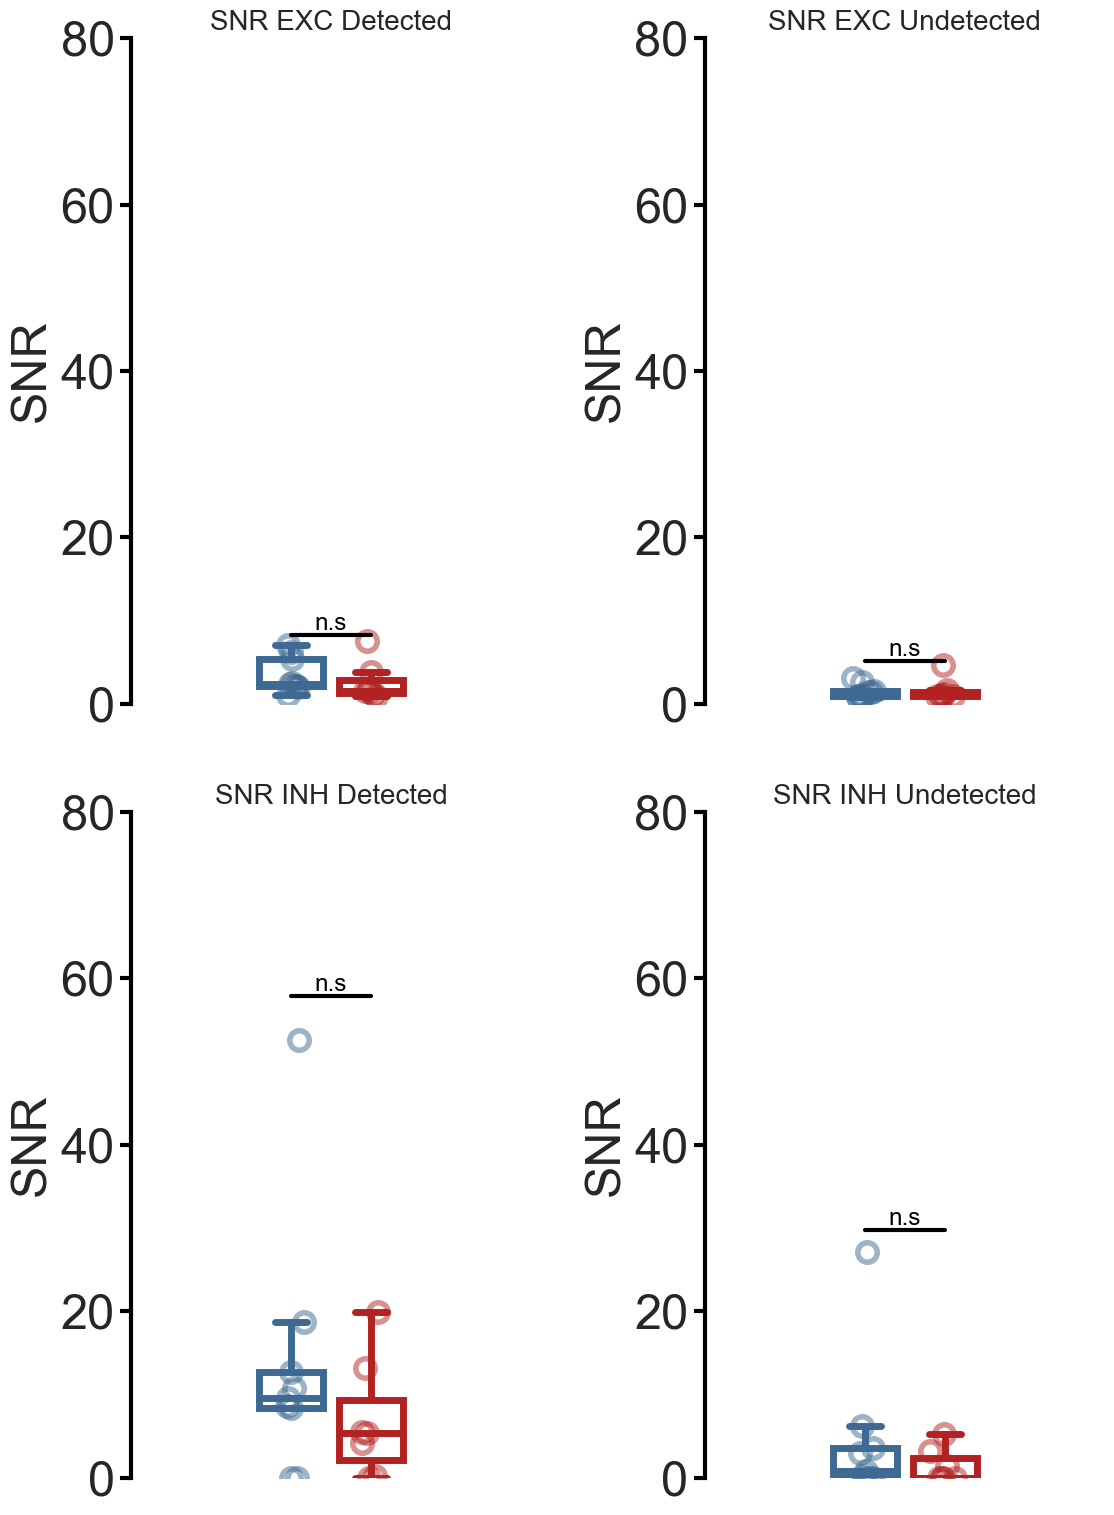

In [36]:
    wt_det, ko_det, wt_undet, ko_undet = SNR(pattern=0, n_type="EXC", ko="KO-hypo", stim_ampl="all")
    fig, axs = plt.subplots(2, 2, figsize=(12,16))
    ylim= [0,70]
    ppt.boxplot(axs[0, 0], wt_det,ko_det,"SNR",ylim=ylim)
    axs[0, 0].set_title("SNR EXC Detected")
    ppt.boxplot(axs[0, 1], wt_undet,ko_undet,"SNR",ylim=ylim)
    axs[0, 1].set_title("SNR EXC Undetected")
    wt_det1, ko_det1, wt_undet1, ko_undet1 = fraction_resp(pattern=0, n_type="INH", ko_hypo_only=True, stim_ampl="all")
    ppt.boxplot(axs[1, 0], wt_det1,ko_det1,"SNR",ylim=ylim)
    axs[1, 0].set_title("SNR INH Detected")
    ppt.boxplot(axs[1, 1], wt_undet1,ko_undet1,"SNR",ylim=ylim)
    axs[1, 1].set_title("SNR INH Undetected")
    fig.tight_layout()
    if save_figure:
        fig.savefig(server_address + "Figure2/responsivity/SNR.pdf")

# Fraction of neurons active during no-Gos

Boxplot plotting.
--- Neurons(%):  ---
ShapiroResult(statistic=0.9020889336508191, pvalue=0.26435498979486527)
ShapiroResult(statistic=0.9616626235653164, pvalue=0.8328662760851382)
LeveneResult(statistic=0.11839006352699233, pvalue=0.7359005469793434)
Equal variances :TtestResult(statistic=0.022715273474766318, pvalue=0.9821979788147785, df=14.0)
Boxplot plotting.
--- Neurons(%):  ---
ShapiroResult(statistic=0.9020889336508191, pvalue=0.26435498979486527)
ShapiroResult(statistic=0.9495054732689385, pvalue=0.7251950633634988)
LeveneResult(statistic=0.18845975284137378, pvalue=0.6708172798524852)
Equal variances :TtestResult(statistic=-0.045941043079824516, pvalue=0.9640061286203784, df=14.0)
Boxplot plotting.
--- Neurons(%):  ---
ShapiroResult(statistic=0.9113568640771863, pvalue=0.32548716611280304)
ShapiroResult(statistic=0.9698697274117903, pvalue=0.8975093504560134)
LeveneResult(statistic=0.09840978888585729, pvalue=0.758371720338429)
Equal variances :TtestResult(statistic=0.016808

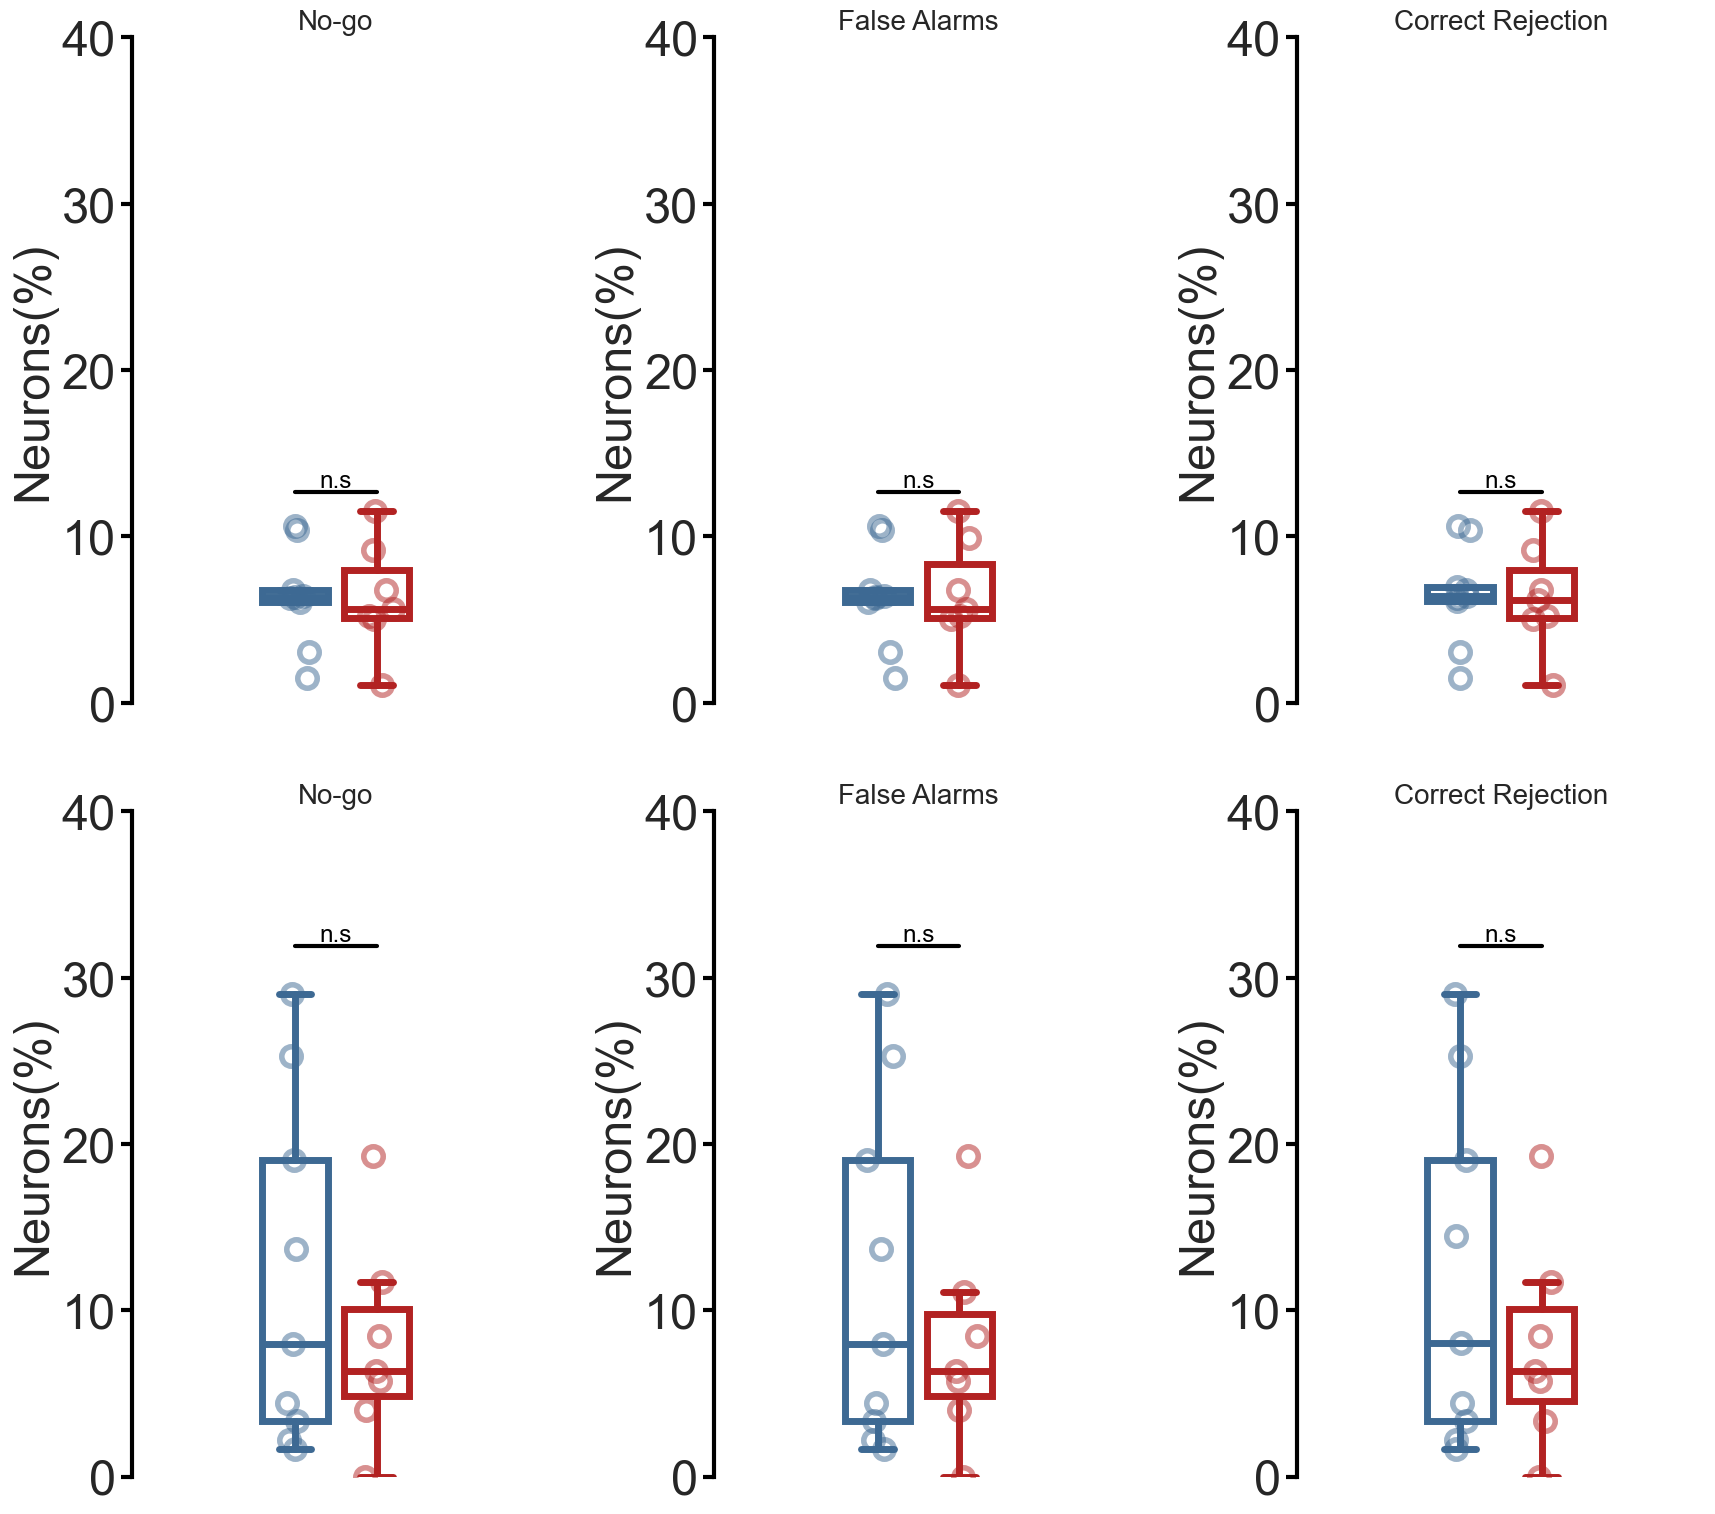

In [37]:
def nogo_fraction(n_type, ko, fa_cr_discrimination=True, return_fa=True):
    wt_det, ko_det = [], []
    
    for rec in recs.values():
        resp_mat = rec.matrices["EXC"]["Responsivity"]
        total_n = len(rec.zscore_exc)
        if n_type == "INH":
            resp_mat = rec.matrices["INH"]["Responsivity"]
            total_n = len(rec.zscore_inh)

        if fa_cr_discrimination:
            fa_timing, cr_timing = [], []
            no_go_timing = rec.stim_time[rec.stim_ampl==0]
            for i in no_go_timing:
                for y in rec.lick_time:
                    if y-i<30:
                        fa_timing.append(i)
                    else:    
                        cr_timing.append(i)
            n_baseline_fa = (np.mean(np.count_nonzero(resp_mat[:, np.isin(rec.stim_time, fa_timing)], axis=0)) / total_n) * 100          
            n_baseline_cr = (np.mean(np.count_nonzero(resp_mat[:, np.isin(rec.stim_time, cr_timing)], axis=0)) / total_n) * 100   
            
            if return_fa:
                n_baseline = n_baseline_fa
            else:
                n_baseline = n_baseline_cr
        else:
            n_baseline = (np.mean(np.count_nonzero(resp_mat[:, rec.stim_ampl == 0], axis=0)) / total_n) * 100
            
        if rec.genotype == "WT":
            wt_det.append(n_baseline)
        elif rec.genotype == "KO-Hypo":
            ko_det.append(n_baseline)

        elif rec.genotype == "KO" and ko == "KO":
            ko_det.append(n_baseline)

    return wt_det, ko_det

wt_exc_nogo, ko_exc_nogo = nogo_fraction(n_type="EXC", ko="KO-hypo", fa_cr_discrimination=False)
wt_exc_fa, ko_exc_fa = nogo_fraction(n_type="EXC", ko="ko-hypo", fa_cr_discrimination=True, return_fa=True)
wt_exc_cr, ko_exc_cr = nogo_fraction(n_type="EXC", ko="ko-hypo", fa_cr_discrimination=True, return_fa=False)
wt_inh_nogo, ko_inh_nogo = nogo_fraction(n_type="INH", ko="ko-hypo", fa_cr_discrimination=False)
wt_inh_fa, ko_inh_fa = nogo_fraction(n_type="INH",ko="ko-hypo", fa_cr_discrimination=True, return_fa=True)
wt_inh_cr, ko_inh_cr = nogo_fraction(n_type="INH", ko="ko-hypo", fa_cr_discrimination=True, return_fa=False)
fig, axs = plt.subplots(2, 3, figsize=(18, 16))
ylim = [0, 40]
ppt.boxplot(axs[0,0], wt_exc_nogo, ko_exc_nogo, paired=False, ylabel="Neurons(%)", ylim=ylim)
ppt.boxplot(axs[0,1], wt_exc_fa, ko_exc_fa, paired=False, ylabel="Neurons(%)", ylim=ylim)
ppt.boxplot(axs[0,2], wt_exc_cr, ko_exc_cr, paired=False, ylabel="Neurons(%)", ylim=ylim)
axs[0,0].set_title("No-go")
axs[0,1].set_title("False Alarms")
axs[0,2].set_title("Correct Rejection")
ppt.boxplot(axs[1,0], wt_inh_nogo, ko_inh_nogo, paired=False, ylabel="Neurons(%)", ylim=ylim)
ppt.boxplot(axs[1,1], wt_inh_fa, ko_inh_fa, paired=False, ylabel="Neurons(%)", ylim=ylim)
ppt.boxplot(axs[1,2], wt_inh_cr, ko_inh_cr, paired=False, ylabel="Neurons(%)", ylim=ylim)
axs[1,0].set_title("No-go")
axs[1,1].set_title("False Alarms")
axs[1,2].set_title("Correct Rejection")
fig.tight_layout()
if save_figure:
    fig.savefig(server_address + "Figure2/responsivity/nogo.pdf")

# Level of inhibition (nb of exc inhibited/ nb of inh activated) (No nogo normalization)

Boxplot plotting.
--- Level of inhibition:  ---
ShapiroResult(statistic=0.9075502197750696, pvalue=0.3371349706979153)
ShapiroResult(statistic=0.7659480444447422, pvalue=0.01856553491057596)
MannwhitneyuResult(statistic=37.0, pvalue=0.33566433566433573)
Boxplot plotting.
--- Level of inhibition:  ---
ShapiroResult(statistic=0.8337432594814178, pvalue=0.06492187587221089)
ShapiroResult(statistic=0.9197062246155165, pvalue=0.46711328417669595)
LeveneResult(statistic=1.4561185301787818, pvalue=0.2490489210212653)
Equal variances :TtestResult(statistic=-0.17170501769249547, pvalue=0.866313472073851, df=13.0)


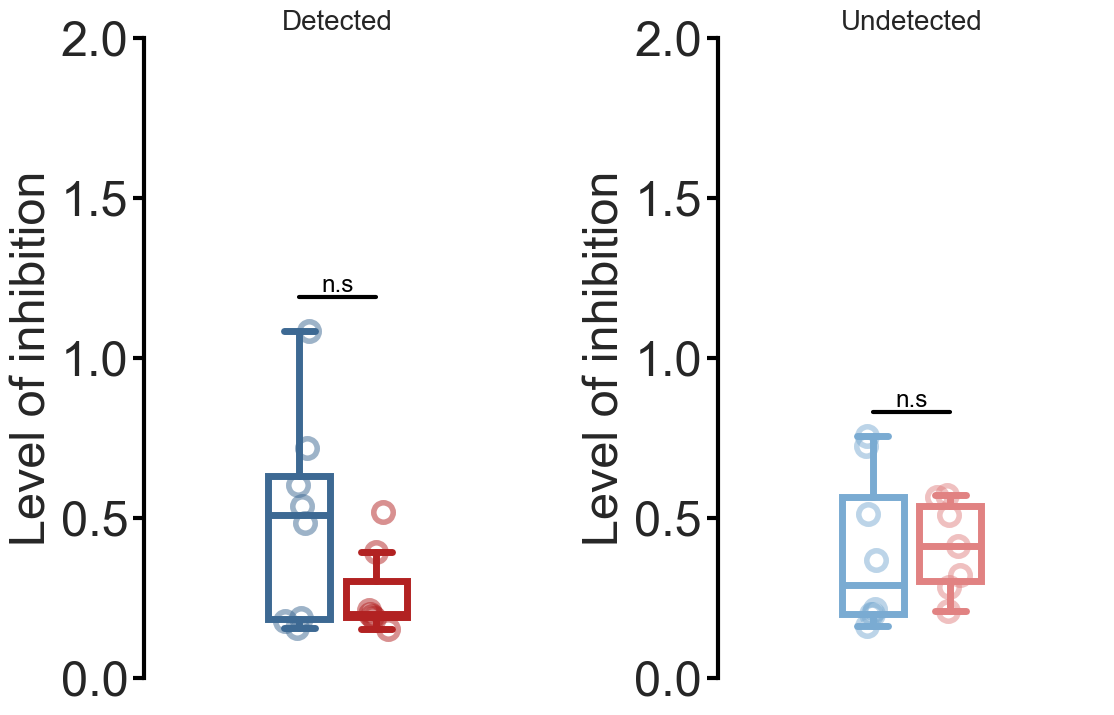

In [38]:
wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=-1, n_type="EXC", ko_hypo_only=True, stim_ampl="all",
                                                   no_go_normalize=False)
wt_det1, ko_det1, wt_undet1, ko_undet1 = fraction_resp(pattern=1, n_type="INH", ko_hypo_only=True, stim_ampl="all",
                                                       no_go_normalize=False)
wt_nan = np.logical_and(wt_det1>0,wt_undet1>0)
ko_nan = np.logical_and(ko_det1>0,ko_undet1>0)
wt_det, ko_det, wt_undet, ko_undet = wt_det[wt_nan], ko_det[ko_nan], wt_undet[wt_nan], ko_undet[ko_nan]
wt_det1, ko_det1, wt_undet1, ko_undet1 = wt_det1[wt_nan], ko_det1[ko_nan], wt_undet1[wt_nan], ko_undet1[ko_nan]
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
ylim = [0, 2]
ppt.boxplot(axs[0], np.divide(wt_det, wt_det1), np.divide(ko_det, ko_det1), "Level of inhibition", ylim=ylim, colors=[ppt.wt_color, ppt.hypo_color])
axs[0].set_title("Detected")
ppt.boxplot(axs[1], np.divide(wt_undet, wt_undet1), np.divide(ko_undet, ko_undet1), "Level of inhibition", ylim=ylim, colors=[ppt.wt_light_color, ppt.hypo_light_color])
axs[1].set_title("Undetected")
fig.tight_layout()
if save_figure:
    fig.savefig(server_address + "Figure2/responsivity/inhbib_level.pdf")

# E/I ratio 

C:\Users\cvandromme\AppData\Local\Temp\ipykernel_24884\3496670754.py:7: RuntimeWarning: divide by zero encountered in divide
  y0=np.round(np.divide(wt_det,wt_det1),3)
C:\Users\cvandromme\AppData\Local\Temp\ipykernel_24884\3496670754.py:14: RuntimeWarning: divide by zero encountered in divide
  y2=np.round(np.divide(wt_undet,wt_undet1),3)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\AppData\Local\Temp\ipykernel_24884\3496670754.py:45: RuntimeWarning: divide by zero encountered in divide
  y1=np.round(np.divide(ko_undet, ko_undet1 ),3)


[0.703 0.68  0.815   inf 1.162 1.059 0.85  0.531 0.647]
[0.762 2.473 0.485 2.444 5.553 1.032 0.949]
Boxplot plotting.
--- E/I ratio:  ---
ShapiroResult(statistic=0.9387040290970746, pvalue=0.5983756219885573)
ShapiroResult(statistic=0.7995038389943271, pvalue=0.04050374573122431)
MannwhitneyuResult(statistic=16.0, pvalue=0.1892773892773893)
[0.636 1.28  0.447 0.75  4.079 0.281   inf 0.425 0.392]
[0.629 1.397 1.061 0.35  0.57  2.645 1.607]
Boxplot plotting.
--- E/I ratio:  ---
ShapiroResult(statistic=0.6216727105825623, pvalue=0.00028452726652708694)
ShapiroResult(statistic=0.9142064781360583, pvalue=0.4257658349000677)
MannwhitneyuResult(statistic=20.0, pvalue=0.39689199689199695)
Boxplot plotting.
--- E/I ratio:  ---
ShapiroResult(statistic=0.9072870041817211, pvalue=0.3774081393624373)
ShapiroResult(statistic=0.6358849204872021, pvalue=0.0007104239980592065)
WilcoxonResult(statistic=12.0, pvalue=0.8125)
Boxplot plotting.
--- E/I ratio:  ---
ShapiroResult(statistic=0.7995038389943271,

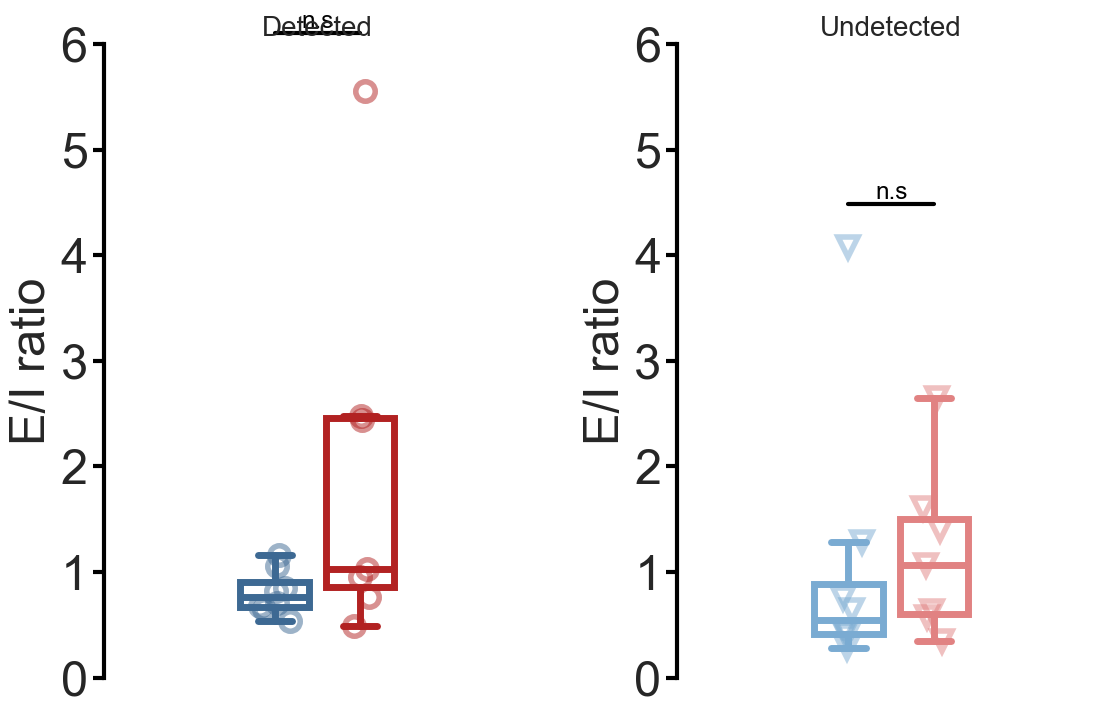

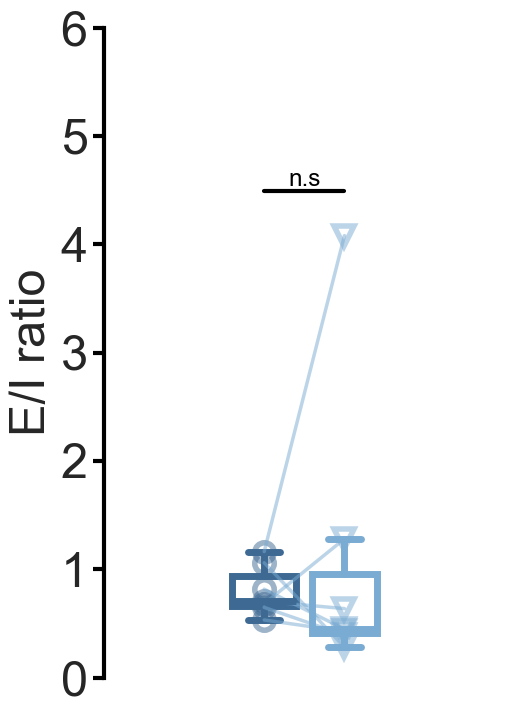

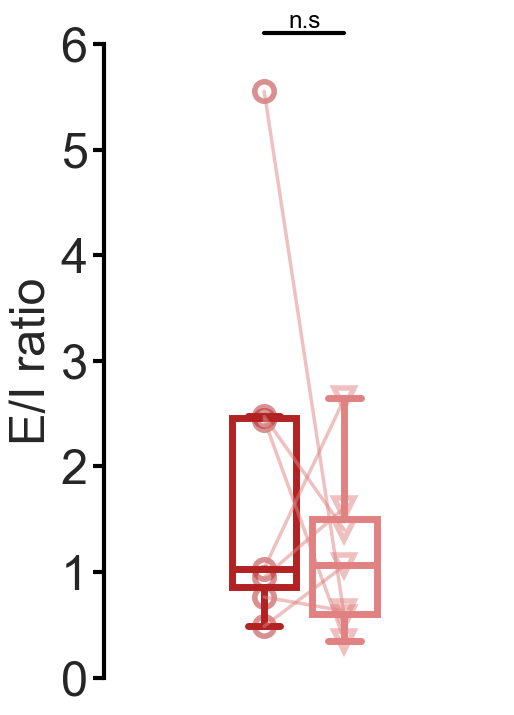

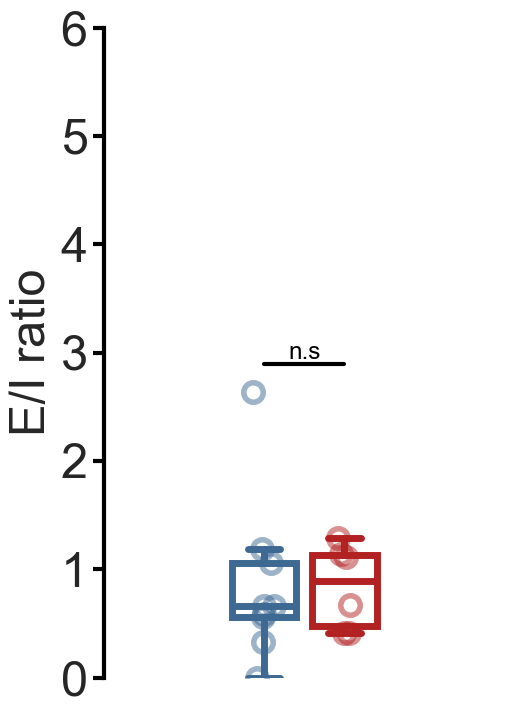

In [39]:
stim = "threshold"
wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=1, n_type="EXC", ko_hypo_only=True, stim_ampl=stim, no_go_normalize=False)
wt_det1, ko_det1, wt_undet1, ko_undet1 = fraction_resp(pattern=1, n_type="INH", ko_hypo_only=True, stim_ampl=stim, no_go_normalize=False)

ylim =[0,6]
fig, axs = plt.subplots(1, 2, figsize=(12,8))
y0=np.round(np.divide(wt_det,wt_det1),3)
y1=np.round(np.divide(ko_det,ko_det1),3)
print(y0)
print(y1)
ppt.boxplot(axs[0],y0[np.isfinite(y0)] ,y1[np.isfinite(y1)],"E/I ratio",
            colors=[ppt.wt_color, ppt.hypo_color], ylim=ylim)
axs[0].set_title("Detected")
y2=np.round(np.divide(wt_undet,wt_undet1),3)
y3=np.round(np.divide(ko_undet,ko_undet1),3)
print(y2)
print(y3)
ppt.boxplot(axs[1],y2[np.isfinite(y2)], y3[np.isfinite(y3)],"E/I ratio",
            colors=[ppt.wt_light_color, ppt.hypo_light_color],ylim=ylim, det_marker=False)
axs[1].set_title("Undetected")
fig.tight_layout()
if save_figure:
    fig.savefig(server_address + "Figure2/responsivity/EI_ratio_" + stim +".pdf")

#wt only
fig, ax = plt.subplots(1, 1, figsize=(6,8))
ppt.boxplot(ax,y0[np.isfinite(y0) & np.isfinite(y2)], y2[np.isfinite(y0) & np.isfinite(y2)],"E/I ratio",
            colors=[ppt.wt_color, ppt.wt_light_color], paired=True,ylim=ylim, det_marker=True)
fig.tight_layout()
if save_figure:
    fig.savefig(server_address + "Figure2/responsivity/EI_ratio_WT-only_"+ stim +".pdf")

#ko only
fig, ax = plt.subplots(1, 1, figsize=(6,8))
ppt.boxplot(ax,y1[np.isfinite(y1) & np.isfinite(y3)], y3[np.isfinite(y1) & np.isfinite(y3)],"E/I ratio",
            colors=[ppt.hypo_color, ppt.hypo_light_color], paired=True,ylim=ylim, det_marker=True)
fig.tight_layout()
if save_figure:
    fig.savefig(server_address + "Figure2/responsivity/EI_ratio_ko-only_"+ stim +".pdf")

#no-go only
wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=1, n_type="EXC", ko_hypo_only=True, stim_ampl=[0], no_go_normalize=False)
wt_det1, ko_det1, wt_undet1, ko_undet1 = fraction_resp(pattern=1, n_type="INH", ko_hypo_only=True, stim_ampl=[0], no_go_normalize=False)
y0=np.round(np.divide(wt_undet, wt_undet1),3)
y1=np.round(np.divide(ko_undet, ko_undet1 ),3)
fig, ax = plt.subplots(1, 1, figsize=(6,8))
ppt.boxplot(ax,y0[np.isfinite(y0)], y1[np.isfinite(y1) ],"E/I ratio",
            colors=[ppt.wt_color, ppt.hypo_color], paired=False,ylim=ylim, det_marker=True)
fig.tight_layout()
if save_figure:
    fig.savefig(server_address + "Figure2/responsivity/EI_ratio_no_go.pdf")

# Nb and percentage of neurons in the fields of view

In [40]:
def quantify_neur(n_type, ko="all"):
    wt_n, ko_n, wt_per, ko_per = [],[],[],[]
    for rec in recs.values():
        if n_type == "EXC":
            n_neur = rec.zscore_exc.shape[0]
        elif n_type == "INH":
            n_neur = rec.zscore_inh.shape[0]
            
        n_perc = (n_neur/(rec.zscore_inh.shape[0]+rec.zscore_exc.shape[0]))*100
        
        if rec.genotype == "WT":
            wt_n.append(n_neur)
            wt_per.append(n_perc)
        elif rec.genotype =="KO-Hypo":
            ko_n.append(n_neur)
            ko_per.append(n_perc)
        elif rec.genotype == "KO" and ko =="KO":
            ko_n.append(n_neur)
            ko_per.append(n_perc)

    return wt_n, ko_n, wt_per, ko_per

In [41]:
quantify_neur("EXC")

([127, 125, 101, 38, 76, 55, 49, 91, 51],
 [98, 131, 66, 103, 103, 62, 84],
 [90.0709219858156,
  86.20689655172413,
  84.16666666666667,
  80.85106382978722,
  88.37209302325581,
  75.34246575342466,
  76.5625,
  75.83333333333333,
  77.27272727272727],
 [87.5,
  91.6083916083916,
  76.74418604651163,
  84.42622950819673,
  82.39999999999999,
  88.57142857142857,
  82.35294117647058])

Boxplot plotting.
--- Nb Neurons exc:  ---
ShapiroResult(statistic=0.9076382047186158, pvalue=0.2996925304219764)
ShapiroResult(statistic=0.9413786086062781, pvalue=0.6511672632749509)
LeveneResult(statistic=1.5788151748687693, pvalue=0.22949336710469695)
Equal variances :TtestResult(statistic=-0.8792846087252066, pvalue=0.3940891646999024, df=14.0)
Boxplot plotting.
--- Nb Neurons inh:  ---
ShapiroResult(statistic=0.9273854656802926, pvalue=0.4568551541196089)
ShapiroResult(statistic=0.9438615117080946, pvalue=0.6737090076605775)
LeveneResult(statistic=0.03395005134223266, pvalue=0.8564553738303113)
Equal variances :TtestResult(statistic=0.14690035885702998, pvalue=0.8853051284462476, df=14.0)
Boxplot plotting.
--- % Neurons exc:  ---
ShapiroResult(statistic=0.8921495679092057, pvalue=0.2099138921611129)
ShapiroResult(statistic=0.973394958736427, pvalue=0.9217718150306008)
LeveneResult(statistic=0.6832715512960998, pvalue=0.42232734799562677)
Equal variances :TtestResult(statistic=-1.

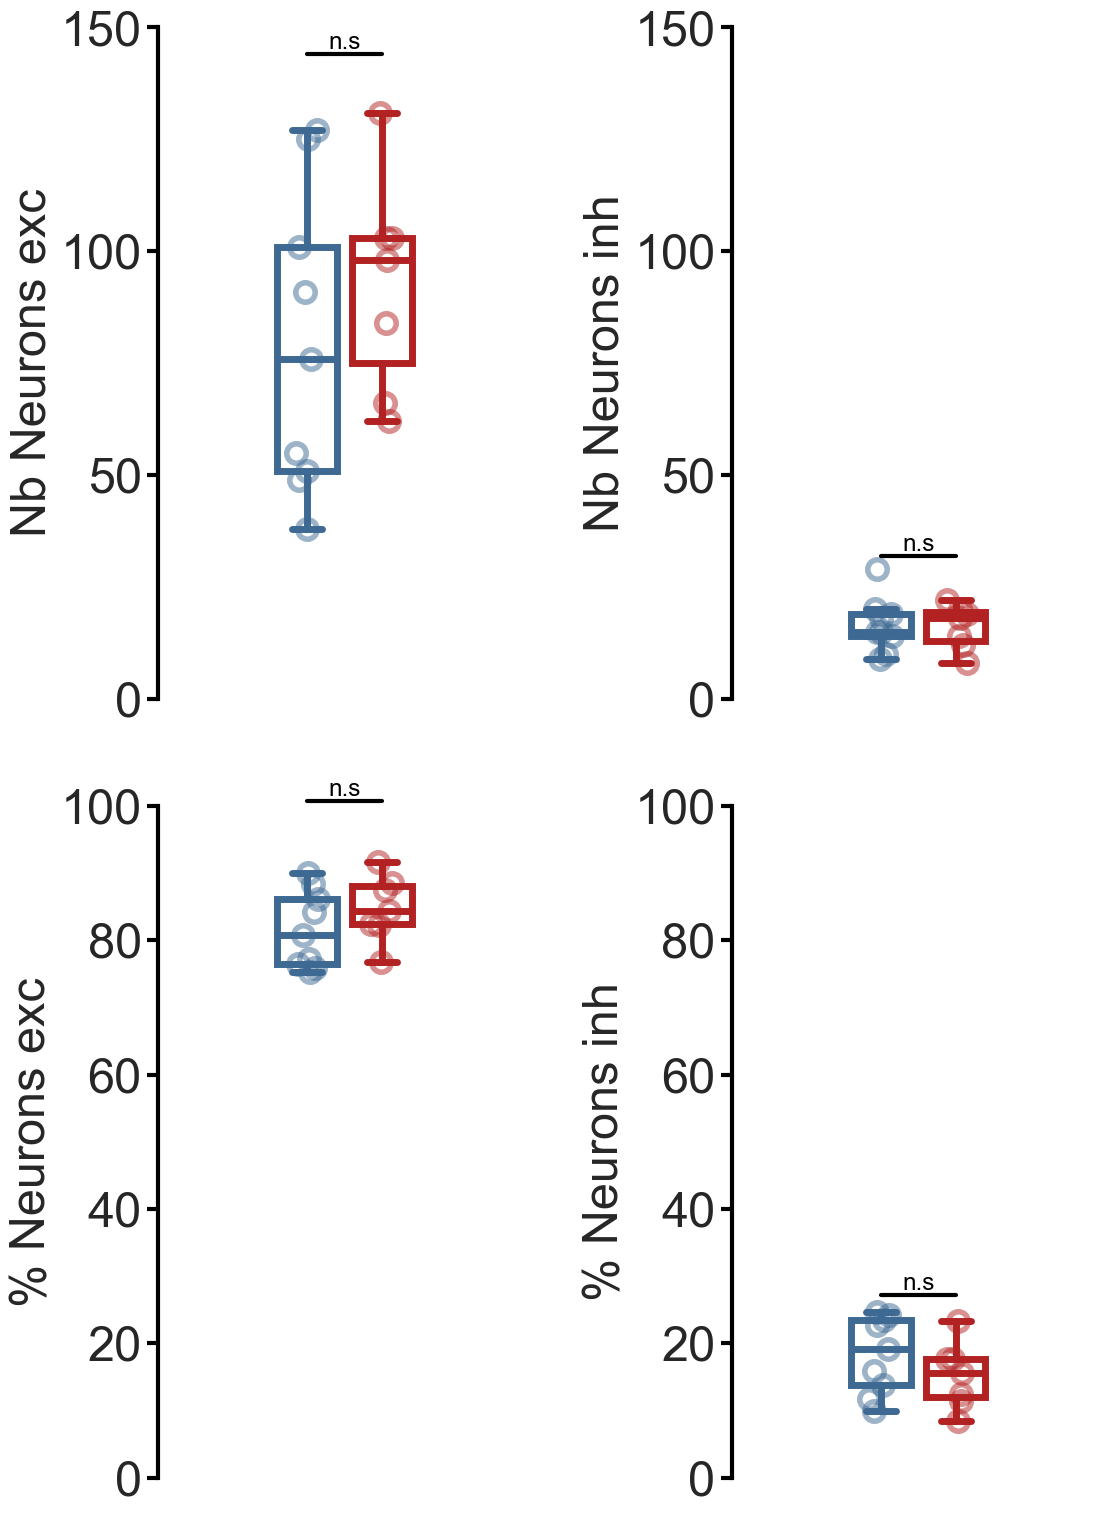

In [42]:
wt_exc, ko_exc, wt_per_e, ko_per_e = quantify_neur("EXC",ko="KO-hy")
wt_inh, ko_inh, wt_per_i, ko_per_i = quantify_neur("INH",ko="KO-hypo")
fig, axs = plt.subplots(2, 2, figsize=(12,16))
ppt.boxplot(axs[0,0],wt_exc ,ko_exc,"Nb Neurons exc",ylim=[0, 150])
ppt.boxplot(axs[0,1],wt_inh ,ko_inh,"Nb Neurons inh",ylim=[0, 150])
ppt.boxplot(axs[1,0],wt_per_e ,ko_per_e,"% Neurons exc",ylim=[0, 100])
ppt.boxplot(axs[1,1],wt_per_i ,ko_per_i,"% Neurons inh",ylim=[0, 100])
fig.tight_layout()
if save_figure:
    fig.savefig(server_address + "Figure2/responsivity/neurons_field_of_view.pdf")

# Difference in zscore during no-gos between WT and KO

Boxplot plotting.
--- Delta zscore: All trials ---
ShapiroResult(statistic=0.9266705318228973, pvalue=0.45030173074714325)
ShapiroResult(statistic=0.7185370216067317, pvalue=0.005886636159938272)
MannwhitneyuResult(statistic=48.0, pvalue=0.09073426573426574)
Boxplot plotting.
--- Delta zscore: Detected trials ---
ShapiroResult(statistic=0.9579774458689645, pvalue=0.7769302460486034)
ShapiroResult(statistic=0.6572720471750721, pvalue=0.0012437667504356428)
MannwhitneyuResult(statistic=54.0, pvalue=0.016433566433566436)
Boxplot plotting.
--- Delta zscore: Undetected trials ---
ShapiroResult(statistic=0.8713505717405305, pvalue=0.1271154250129805)
ShapiroResult(statistic=0.9282670701521877, pvalue=0.5362594771991602)
LeveneResult(statistic=0.0004953641006905618, pvalue=0.9825572399041785)
Equal variances :TtestResult(statistic=0.7110637588519388, pvalue=0.48872310948318864, df=14.0)
Boxplot plotting.
--- Delta zscore: Raw mean zscore ---
ShapiroResult(statistic=0.9688513149696539, pvalue=

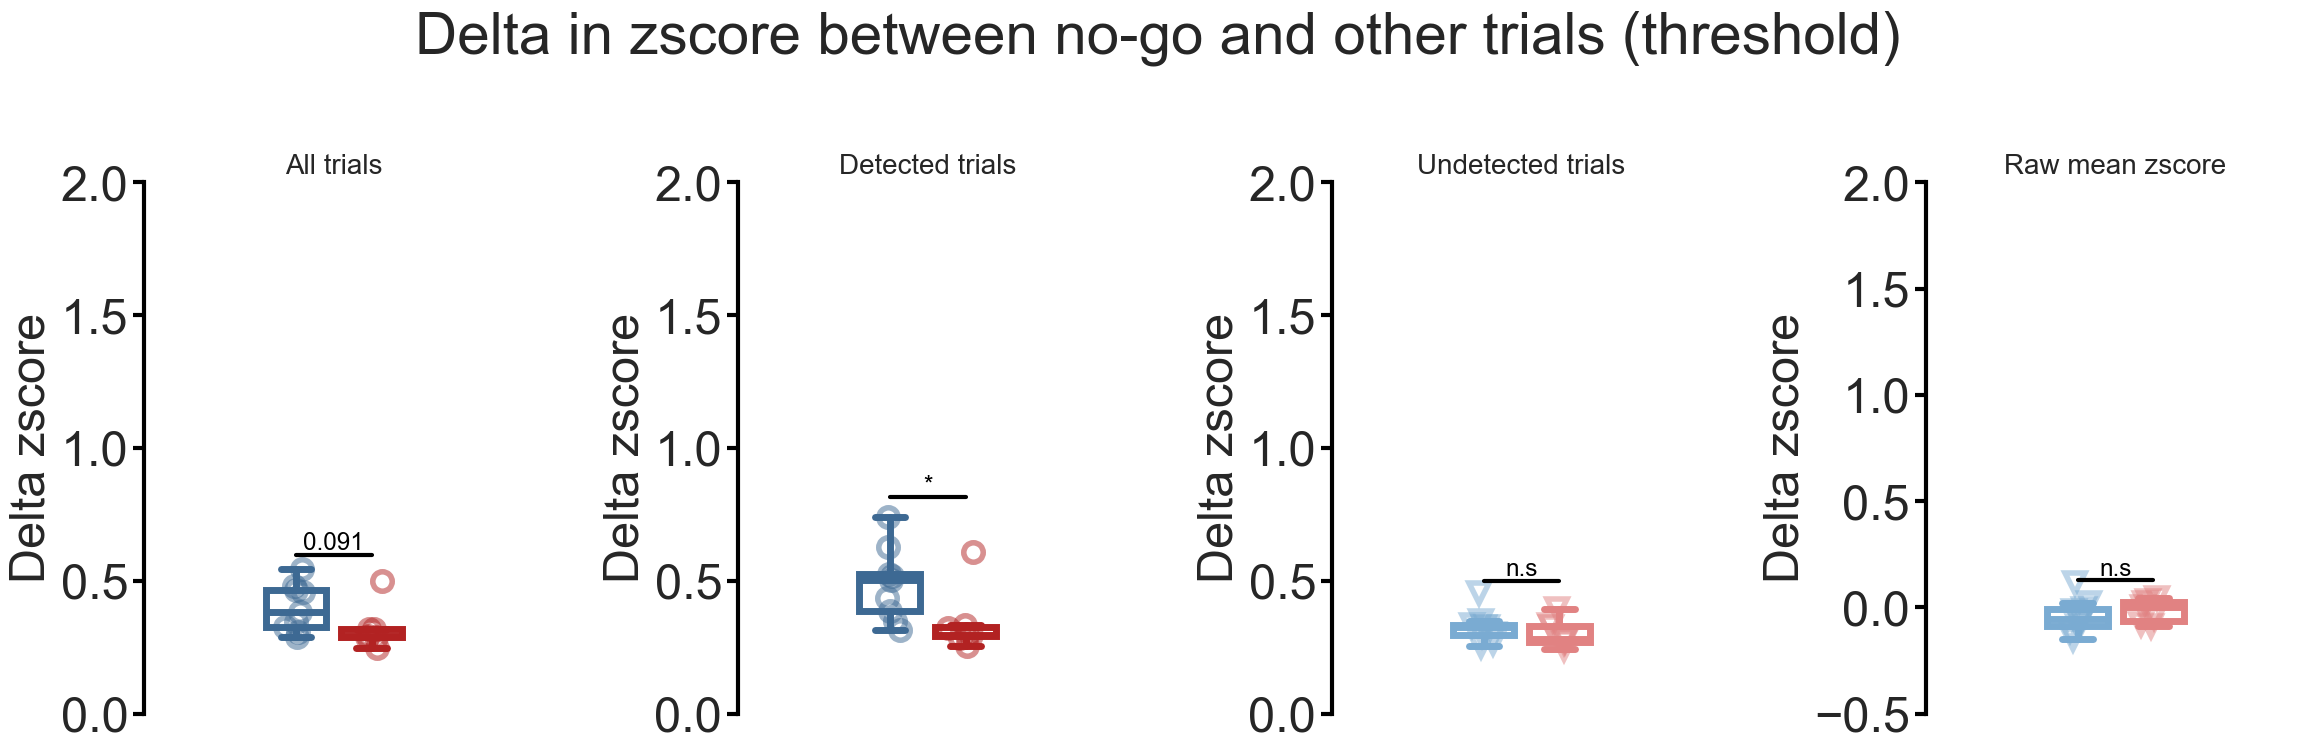

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24, 8))
wt, ko, hypo = [], [], []
wt_det, ko_det, hypo_det = [], [], []
wt_undet, ko_undet, hypo_undet = [], [], []
wt_nogo, ko_nogo, hypo_nogo = [], [], []
for rec in recs.values():
    zscore = get_zscore(rec, exc_neurons=True, inh_neurons=False, time_span="stim", window=0.5, estimator="Mean", sort=False, amp_sort=False, single_frame_estimator=True)[0]
    
    no_go_filter = rec.stim_ampl_filter(stim_ampl=[0], include_no_go=True)
    # det_filter = rec.detected_stim
    # undet_filter = ~rec.detected_stim & ~no_go_filter
    # all_filter = ~no_go_filter
    det_filter = rec.detected_stim & rec.stim_ampl_filter(stim_ampl="threshold", include_no_go=False)
    undet_filter = ~rec.detected_stim & ~no_go_filter & rec.stim_ampl_filter(stim_ampl="threshold", include_no_go=False)
    all_filter = ~no_go_filter & rec.stim_ampl_filter(stim_ampl="threshold", include_no_go=False)
    
    mean_zscore_no_go = np.mean(zscore[:, no_go_filter], axis=1)[:, np.newaxis]
    det_zscore = abs(zscore[:, det_filter] - mean_zscore_no_go)
    undet_zscore = abs(zscore[:, undet_filter] - mean_zscore_no_go)
    all_zscore = abs(zscore[:, all_filter] - mean_zscore_no_go)
    
    if rec.genotype == "WT":
        wt.append(np.mean(np.mean(all_zscore, axis=0)))
        wt_det.append(np.mean(np.mean(det_zscore, axis=0)))
        wt_undet.append(np.mean(np.mean(undet_zscore, axis=0)))
        wt_nogo.append(np.mean(np.mean(mean_zscore_no_go, axis=0)))
    else:
        ko.append(np.mean(np.mean(all_zscore, axis=0)))
        ko_det.append(np.mean(np.mean(det_zscore, axis=0)))
        ko_undet.append(np.mean(np.mean(undet_zscore, axis=0)))
        ko_nogo.append(np.mean(np.mean(mean_zscore_no_go, axis=0)))
    if rec.genotype == "KO-Hypo":
        hypo.append(np.mean(np.mean(all_zscore, axis=0)))
        hypo_det.append(np.mean(np.mean(det_zscore, axis=0)))
        hypo_undet.append(np.mean(np.mean(undet_zscore, axis=0)))
        hypo_nogo.append(np.mean(np.mean(mean_zscore_no_go, axis=0)))
        
ppt.boxplot(ax[0], wt, hypo, "Delta zscore", paired=False, title="All trials", colors=[ppt.wt_color, ppt.hypo_color])
ppt.boxplot(ax[1], wt_det, hypo_det, "Delta zscore", paired=False, title="Detected trials", colors=[ppt.wt_color, ppt.hypo_color])
ppt.boxplot(ax[2], wt_undet, hypo_undet, "Delta zscore", paired=False, title="Undetected trials", colors=[ppt.wt_light_color, ppt.hypo_light_color], det_marker=False)
ppt.boxplot(ax[3], wt_nogo, hypo_nogo, "Delta zscore", paired=False, title="Raw mean zscore", colors=[ppt.wt_light_color, ppt.hypo_light_color], det_marker=False)
# fig.suptitle("Delta in zscore between no-go and other trials")
fig.suptitle("Delta in zscore between no-go and other trials (threshold)")
plt.tight_layout()
# fig.savefig(server_address + "Figure2/responsivity/delta_zscore_nogo_.pdf")
if save_figure:
    fig.savefig(server_address + "Figure2/responsivity/delta_zscore_nogo_threshold.pdf")

In [ ]:
def prelick_comparison():
    wt, ko = {"bsl":[],"timeout":[],"FA":[]}, {"bsl":[],"timeout":[],"FA":[]}
    j, i_wt, i_ko = 0, 0, 0
    
    fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(54, 16))
    
    for rec in recs.values():
        # baseline
        # idx_bsl = rec.stim_time - int(2 * rec.sf)
        # bsl_prelick_trace = rec.zscore_exc[:, np.linspace(idx_bsl- int(0.5 * rec.sf), rec.stim_time - int(0.5 * rec.sf), int(2 * rec.sf) + 1, dtype=int)]
        # bsl_prelick = np.mean(bsl_prelick_trace)
        bsl_prelick = get_zscore(rec, exc_neurons=True, inh_neurons=False, time_span="baseline", window=2, estimator="Mean", sort=False, amp_sort=False, single_frame_estimator=True)[0]
        print(bsl_prelick.shape)

        # timeout
        # idx_timeout = rec.timeout_time[rec.timeout_time < rec.zscore_exc.shape[1]]
        # timeout_prelick_trace = rec.zscore_exc[:, np.linspace(idx_timeout - int(0.5 * rec.sf), idx_timeout, int(0.5 * rec.sf) + 1, dtype=int)]
        # timeout_prelick = np.mean(timeout_prelick_trace,)
        timeout_prelick = get_zscore(rec, exc_neurons=True, inh_neurons=False, time_span="pre_isolated_timeout", window=0.5, estimator="Mean", sort=False, amp_sort=False, single_frame_estimator=True)[0]
        print(timeout_prelick.shape)
        

        # fa
        # idx_fa = []
        # no_go_timing = rec.stim_time[rec.stim_ampl == 0]
        # for i in no_go_timing:
        #     for y in rec.lick_time:
        #         if y-i < 30:
        #             idx_fa.append(i)
        # idx_fa =np.array(idx_fa)
        # fa_prelick_trace = rec.zscore_exc[:,np.linspace(idx_fa - int(0.5 * rec.sf), idx_fa, int(0.5 * rec.sf) + 1, dtype=int)]
        # fa_prelick = np.mean(fa_prelick_trace)

        if rec.genotype == "WT":
            wt["bsl"].append(np.mean(np.mean(bsl_prelick, axis=1)))
            wt["timeout"].append(np.mean(np.mean(timeout_prelick, axis=1)))
            # wt["FA"].append(fa_prelick)
            j = 0
            i = copy.copy(i_wt)
            i_wt += 1
        else:
            j = 1
            i = copy.copy(i_ko)
            i_ko += 1
        if rec.genotype == "KO-Hypo":
            ko["bsl"].append(np.mean(np.mean(bsl_prelick, axis=1)))
            ko["timeout"].append(np.mean(np.mean(timeout_prelick, axis=1)))
            # ko["FA"].append(fa_prelick)
            

        colors = [[ppt.wt_color, ppt.wt_color], [ppt.all_ko_color, ppt.all_ko_color]]
        ppt.boxplot(ax[j, i], np.mean(bsl_prelick, axis=1), np.mean(timeout_prelick, axis=1), "Mean zscore", paired=True, title=f"{rec.filename} {rec.genotype}", ylim=[], colors=colors[j], det_marker=True, force_markers_identity=True)
        
    fig2, axs = plt.subplots(nrows=1, ncols=4, figsize=(24, 8))
    ppt.boxplot(axs[0], wt["bsl"], wt["timeout"], "Mean zscore", paired=True, title="Baseline vs. Timeout (WT)", ylim=[], colors=[ppt.wt_color, ppt.wt_color], det_marker=True, force_markers_identity=True)
    ppt.boxplot(axs[1], ko["bsl"], ko["timeout"], "Mean zscore", paired=True, title="Baseline vs. Timeout (KO-Hypo)", ylim=[], colors=[ppt.hypo_color, ppt.hypo_color], det_marker=True, force_markers_identity=True)
    ppt.boxplot(axs[2], wt["bsl"], ko["bsl"], "Mean zscore", paired=False, title="Baseline", ylim=[], colors=[ppt.wt_color, ppt.hypo_color], det_marker=True, force_markers_identity=True)
    ppt.boxplot(axs[3], wt["timeout"], ko["timeout"], "Mean zscore", paired=False, title="Timeout", ylim=[], colors=[ppt.wt_color, ppt.hypo_color], det_marker=True, force_markers_identity=True)
    plt.tight_layout()
    return wt, ko

wt_, ko_ = prelick_comparison()


In [54]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(30, 8))
wt, ko, hypo = [], [], []
wt_to, ko_to, hypo_to = [], [], []
wt_st, ko_st, hypo_st = [], [], []
for rec in recs.values():
    zscore_all_stim = get_zscore(rec, exc_neurons=True, inh_neurons=False, time_span="stim", window=0.5, estimator="Mean", sort=False, amp_sort=False, single_frame_estimator=True)[0].T
    zscore_det = zscore_all_stim[rec.detected_stim]
    zscore_pre_timeout = get_zscore(rec, exc_neurons=True, inh_neurons=False, time_span="pre_isolated_timeout", window=0.5, estimator="Mean", sort=False, amp_sort=False, single_frame_estimator=True)[0].T
    if rec.genotype == "WT":
        wt.append(np.mean(cosine_similarity(zscore_pre_timeout, zscore_det)))
        wt_to.append(np.mean(cosine_similarity(zscore_pre_timeout)))
        wt_st.append(np.mean(cosine_similarity(zscore_det)))
    else:
        ko.append(np.mean(cosine_similarity(zscore_pre_timeout, zscore_det)))
        ko_to.append(np.mean(cosine_similarity(zscore_pre_timeout)))
        ko_st.append(np.mean(cosine_similarity(zscore_det)))
    if rec.genotype == "KO-Hypo":
        hypo.append(np.mean(cosine_similarity(zscore_pre_timeout, zscore_det)))
        hypo_to.append(np.mean(cosine_similarity(zscore_pre_timeout)))
        hypo_st.append(np.mean(cosine_similarity(zscore_det)))
        
ppt.boxplot(ax[0], wt, hypo, "Mean cosine similarity", paired=False, title="Cosine sim. hit & pre-timeout", ylim=[], colors=[ppt.wt_color, ppt.hypo_color], det_marker=True, force_markers_identity=True)
ppt.boxplot(ax[1], wt_st, wt_to, "Mean cosine similarity", paired=True, title="Cosine sim. hit vs. pre-timeout", ylim=[], colors=[ppt.wt_color, ppt.wt_color], det_marker=True, force_markers_identity=False)
ppt.boxplot(ax[2], hypo_st, hypo_to, "Mean cosine similarity", paired=True, title="Cosine sim. hit vs. pre-timeout", ylim=[], colors=[ppt.hypo_color, ppt.hypo_color], det_marker=True, force_markers_identity=False)
ppt.boxplot(ax[3], wt_st, hypo_st, "Mean cosine similarity", paired=False, title="Cosine sim. hit", ylim=[], colors=[ppt.wt_color, ppt.hypo_color], det_marker=True, force_markers_identity=True)
ppt.boxplot(ax[4], wt_to, hypo_to, "Mean cosine similarity", paired=False, title="Cosine sim. pre-timeout", ylim=[], colors=[ppt.wt_color, ppt.hypo_color], det_marker=False, force_markers_identity=True)

TypeError: FigureBase.subplots() got an unexpected keyword argument 'figsize'

Boxplot plotting.
--- Mean zscore: 4445 KO-Hypo ---
ShapiroResult(statistic=0.9279439503304472, pvalue=4.534717160385069e-05)
ShapiroResult(statistic=0.8602296892624286, pvalue=3.675041877026029e-08)
WilcoxonResult(statistic=397.0, pvalue=6.567705160262022e-13)
Boxplot plotting.
--- Mean zscore: 4456 WT ---
ShapiroResult(statistic=0.9467608981156111, pvalue=7.8645120924248e-05)
ShapiroResult(statistic=0.9245783756949455, pvalue=2.533744698118776e-06)
WilcoxonResult(statistic=3023.0, pvalue=0.012250794640713844)
Boxplot plotting.
--- Mean zscore: 4745 WT ---
ShapiroResult(statistic=0.9186540319889483, pvalue=1.3156801310132948e-06)
ShapiroResult(statistic=0.9571106190084989, pvalue=0.0005561115400928121)
WilcoxonResult(statistic=1798.0, pvalue=1.3525457547611062e-07)
Boxplot plotting.
--- Mean zscore: 4756 KO-Hypo ---
ShapiroResult(statistic=0.9761409597899964, pvalue=0.020768956517260077)
ShapiroResult(statistic=0.8958111646644282, pvalue=4.2523857513379974e-08)
WilcoxonResult(statisti

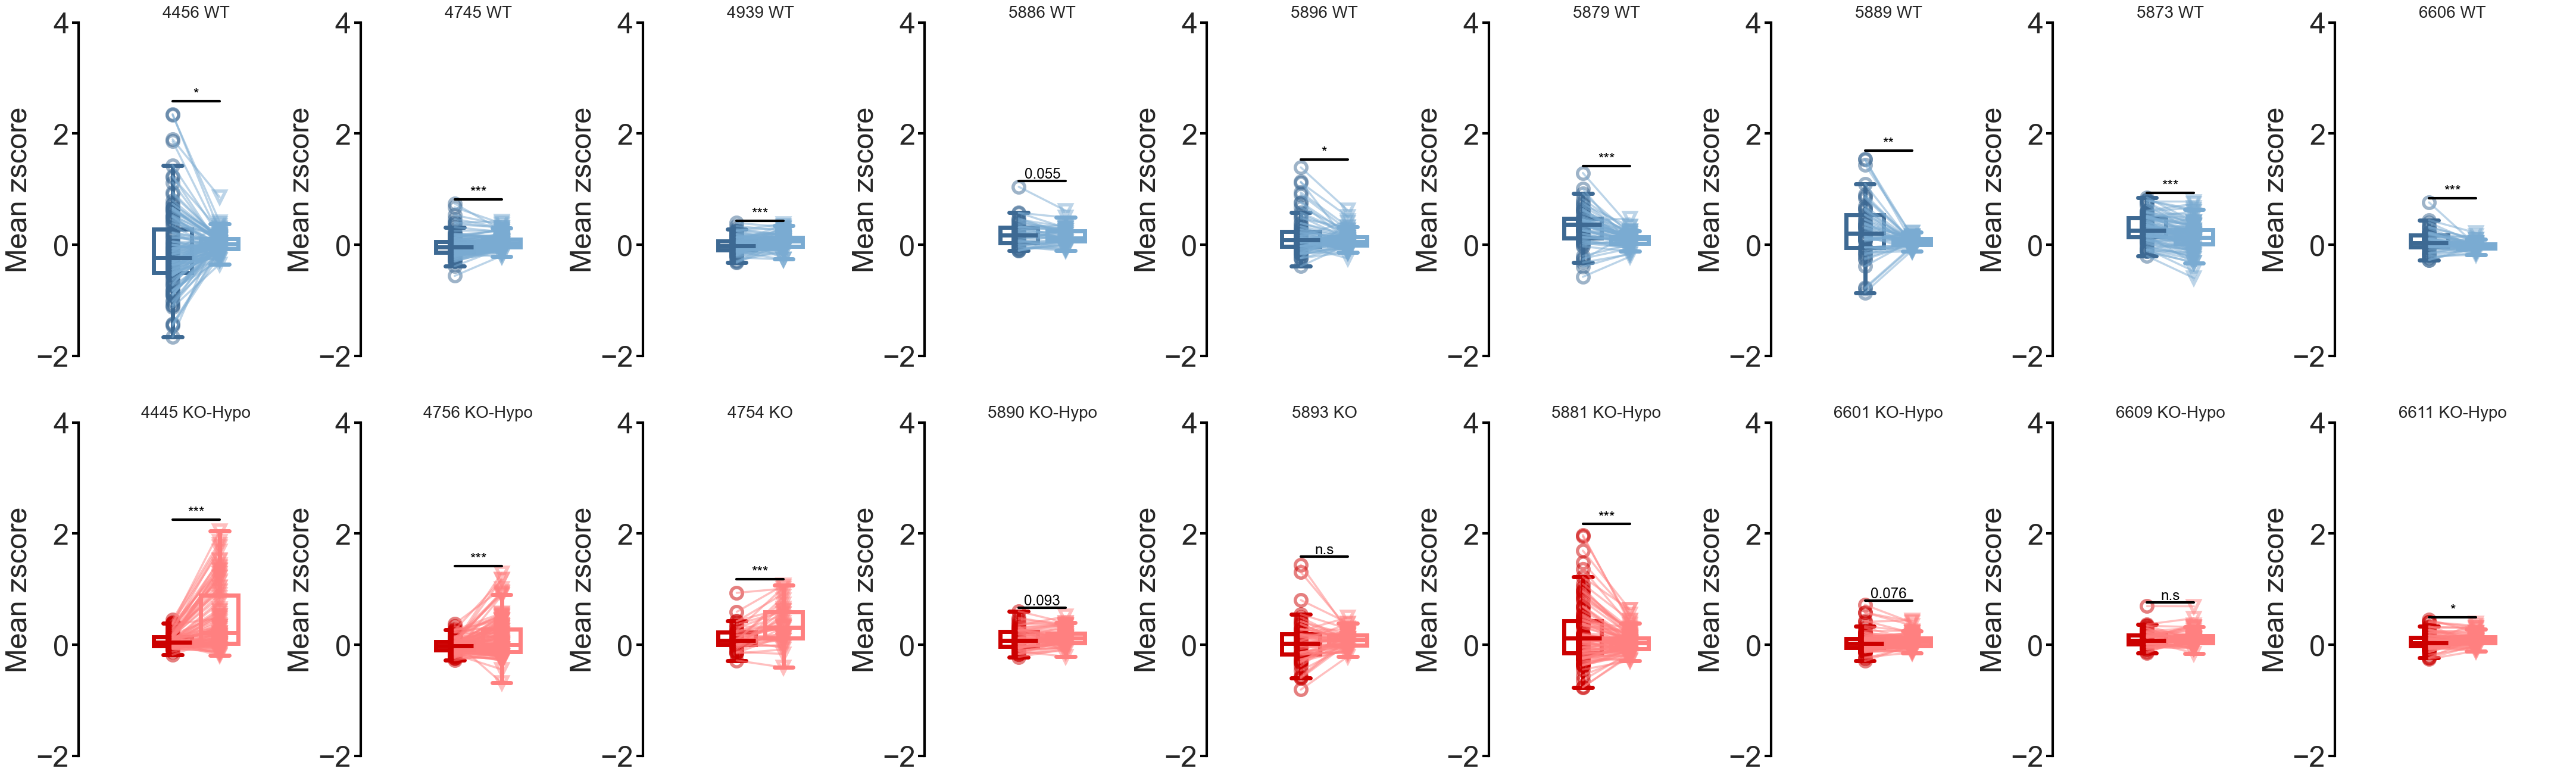

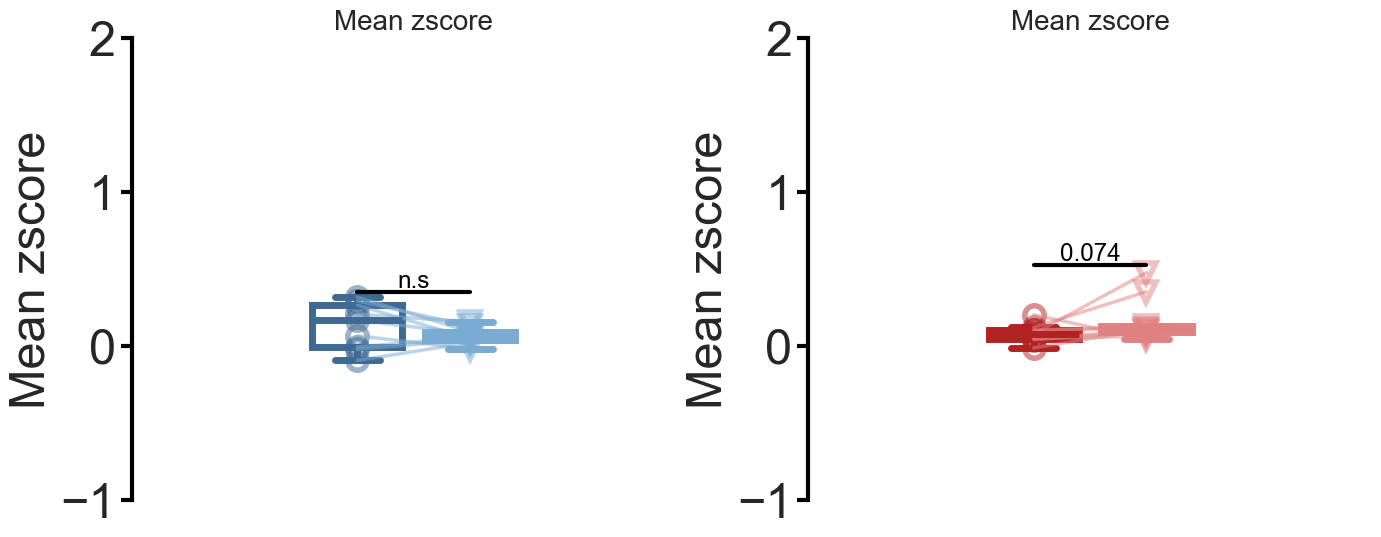

In [92]:
fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(54, 16))
j, i_wt, i_ko = 0, 0, 0
det_wt, det_hypo, timeout_wt, timeout_hypo = [], [], [], []
for rec in recs.values():
    zscore_all_stim = get_zscore(rec, exc_neurons=True, inh_neurons=False, time_span="stim", window=0.5, estimator="Mean", sort=False, amp_sort=False, single_frame_estimator=True)[0]
    zscore_det = np.mean(zscore_all_stim[:, rec.detected_stim], axis=1)
    zscore_pre_timeout = np.mean(get_zscore(rec, exc_neurons=True, inh_neurons=False, time_span="pre_isolated_timeout", window=0.5, estimator="Mean", sort=False, amp_sort=False, single_frame_estimator=True)[0], axis=1)
    
    delta = abs(zscore_det - zscore_pre_timeout)
    
    if rec.genotype == "WT":
        j = 0
        i = copy.copy(i_wt)
        i_wt += 1
        det_wt.append(np.mean(zscore_det))
        timeout_wt.append(np.mean(zscore_pre_timeout))
    else:
        j = 1
        i = copy.copy(i_ko)
        i_ko += 1
        det_hypo.append(np.mean(zscore_det))
        timeout_hypo.append(np.mean(zscore_pre_timeout))
    
    colors = [[ppt.wt_color, ppt.wt_light_color], [ppt.all_ko_color, ppt.all_ko_light_color]]
    ppt.boxplot(ax[j, i], zscore_det, zscore_pre_timeout, "Mean zscore", paired=True, title=f"{rec.filename} {rec.genotype}", ylim=[-2, 4], colors=colors[j], det_marker=True, force_markers_identity=False)

fig2, axs = plt.subplots(1, 2, figsize=(16, 6))
ppt.boxplot(axs[0], det_wt, timeout_wt, "Mean zscore", paired=True, title=f"Mean zscore", ylim=[], colors=[ppt.wt_color, ppt.wt_light_color], det_marker=True, force_markers_identity=False)
ppt.boxplot(axs[1], det_hypo, timeout_hypo, "Mean zscore", paired=True, title=f"Mean zscore", ylim=[], colors=[ppt.hypo_color, ppt.hypo_light_color], det_marker=True, force_markers_identity=False)